## Importing Libraries

In [27]:
import os
import json
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasketch import MinHash
from collections import Counter
import matplotlib.pyplot as plt
from itertools import permutations
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from collections import defaultdict
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Data Loading

In [28]:
# Load the standard and actual routes data
with open('Dataset/standard_routes.json', 'r') as file:
    standard_routes = json.load(file)

with open('Dataset/actual_routes.json', 'r') as file:
    actual_routes = json.load(file)

#### Sample Data Exploration

In [29]:
# Analyzing the structure of the data
structure_standard = {"total_routes": len(standard_routes), "example_route": standard_routes[0]}
structure_actual = {"total_routes": len(actual_routes), "example_route": actual_routes[0]}

In [30]:
structure_standard

{'total_routes': 20,
 'example_route': {'id': 's1',
  'route': [{'from': 'Genoa',
    'to': 'Monza',
    'merchandise': {'honey': 30, 'water': 46, 'tomatoes': 14}},
   {'from': 'Monza', 'to': 'Piacenza', 'merchandise': {'honey': 10}},
   {'from': 'Piacenza',
    'to': 'Bergamo',
    'merchandise': {'bread': 38, 'butter': 2, 'tomatoes': 30}},
   {'from': 'Bergamo', 'to': 'Novara', 'merchandise': {'butter': 9}},
   {'from': 'Novara',
    'to': 'Milan',
    'merchandise': {'tomatoes': 47, 'pens': 37}},
   {'from': 'Milan', 'to': 'Parma', 'merchandise': {'coca-cola': 40}},
   {'from': 'Parma',
    'to': 'Verona',
    'merchandise': {'water': 26, 'chocolate': 36}},
   {'from': 'Verona',
    'to': 'Trento',
    'merchandise': {'milk': 26, 'coffee': 36, 'butter': 21}},
   {'from': 'Trento',
    'to': 'Bolzano',
    'merchandise': {'butter': 22, 'water': 18, 'tea': 23}}]}}

In [31]:
structure_actual

{'total_routes': 509,
 'example_route': {'id': 'a19621',
  'driver': 'D4',
  'route': [{'from': 'Rome',
    'to': 'Sassari',
    'merchandise': {'sugar': 17, 'honey': 42}},
   {'from': 'Sassari',
    'to': 'Florence',
    'merchandise': {'sugar': 29, 'honey': 42}},
   {'from': 'Florence',
    'to': 'Ravenna',
    'merchandise': {'sugar': 42, 'milk': 22}},
   {'from': 'Ravenna',
    'to': 'Forlì',
    'merchandise': {'coffee': 31, 'coca-cola': 37}},
   {'from': 'Forlì',
    'to': 'Ferrara',
    'merchandise': {'coffee': 30, 'coca-cola': 3}},
   {'from': 'Ferrara',
    'to': 'Modena',
    'merchandise': {'sugar': 4, 'pens': 11}},
   {'from': 'Modena', 'to': 'Forlì', 'merchandise': {'honey': 4, 'water': 48}},
   {'from': 'Forlì',
    'to': 'Bologna',
    'merchandise': {'honey': 50, 'water': 45}},
   {'from': 'Bologna',
    'to': 'Forlì',
    'merchandise': {'butter': 28, 'honey': 30, 'tomatoes': 43}},
   {'from': 'Forlì',
    'to': 'Prato',
    'merchandise': {'butter': 50, 'honey': 30, 

## Data Preprocessing

In [32]:
# Data Cleaning Example: Normalize city names
def normalize_city_names(city):
    if "-" in city:
        city = city.replace("-", " ")
        
    return city.strip().lower().replace(" ", "_")

def normalize_merchant_names(merchants):
    return {normalize_city_names(merchant): qty for merchant, qty in merchants.items()}

def convert_merchandise_quantities(merchandise):
    return {item: int(qty) for item, qty in merchandise.items()}

def normalize_trip(trip):
    return {
        "from": normalize_city_names(trip["from"]),
        "to": normalize_city_names(trip["to"]),
        "merchandise": convert_merchandise_quantities(trip["merchandise"])
    }

def normalize_route(route):
    return [normalize_trip(trip) for trip in route]

def normalize_routes(routes):
    return [normalize_route(route) for route in routes]

def normalize_data(data, type_):
    if type_ == "standard":
        return {
            "s_id": data["id"],
            "route": normalize_route(data["route"])
        }
    elif type_ == "actual":
        return {
            "a_id": data["id"],
            "driver": data["driver"],
            "s_id": data["sroute"],
            "route": normalize_route(data["route"])
        }
    else:
        raise ValueError("Invalid type_ value. Valid values are 'standard' and 'actual'")
    
def normalize_standard_routes(standard_routes_):
    return [normalize_data(route, "standard") for route in standard_routes_]

def normalize_actual_routes(actual_routes_):
    return [normalize_data(route, "actual") for route in actual_routes_]

standard_routes_df = pd.DataFrame(normalize_standard_routes(standard_routes))
actual_routes_df = pd.DataFrame(normalize_actual_routes(actual_routes))

In [33]:
standard_routes_df.head()

,s_id,route
0,s1,"[{'from': 'genoa', 'to': 'monza', 'merchandise..."
1,s2,"[{'from': 'genoa', 'to': 'turin', 'merchandise..."
2,s3,"[{'from': 'milan', 'to': 'monza', 'merchandise..."
3,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand..."
4,s5,"[{'from': 'taranto', 'to': 'salerno', 'merchan..."


In [34]:
actual_routes_df.sample(10)

,a_id,driver,s_id,route
302,a94992,D17,s5,"[{'from': 'taranto', 'to': 'salerno', 'merchan..."
331,a15654,D13,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand..."
363,a78455,D50,s4,"[{'from': 'reggio_emilia', 'to': 'piacenza', '..."
51,a51469,D33,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand..."
116,a95613,D49,s9,"[{'from': 'ravenna', 'to': 'forlì', 'merchandi..."
244,a24681,D26,s19,"[{'from': 'trieste', 'to': 'ferrara', 'merchan..."
357,a88685,D47,s15,"[{'from': 'parma', 'to': 'modena', 'merchandis..."
169,a46355,D43,s7,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi..."
483,a54091,D16,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand..."
167,a91218,D43,s7,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi..."


## Data Exploration

In [35]:
# Finding the number of actual routes for each driver and standard route
actual_routes_count = actual_routes_df.groupby(['driver', 's_id']).size().reset_index(name='count')
actual_routes_count

,driver,s_id,count
0,D13,s4,26
1,D13,s6,28
2,D16,s13,42
3,D16,s4,21
4,D17,s5,12
5,D18,s13,20
6,D23,s6,30
7,D24,s10,52
8,D26,s1,24
9,D26,s19,25


<Axes: xlabel='driver'>

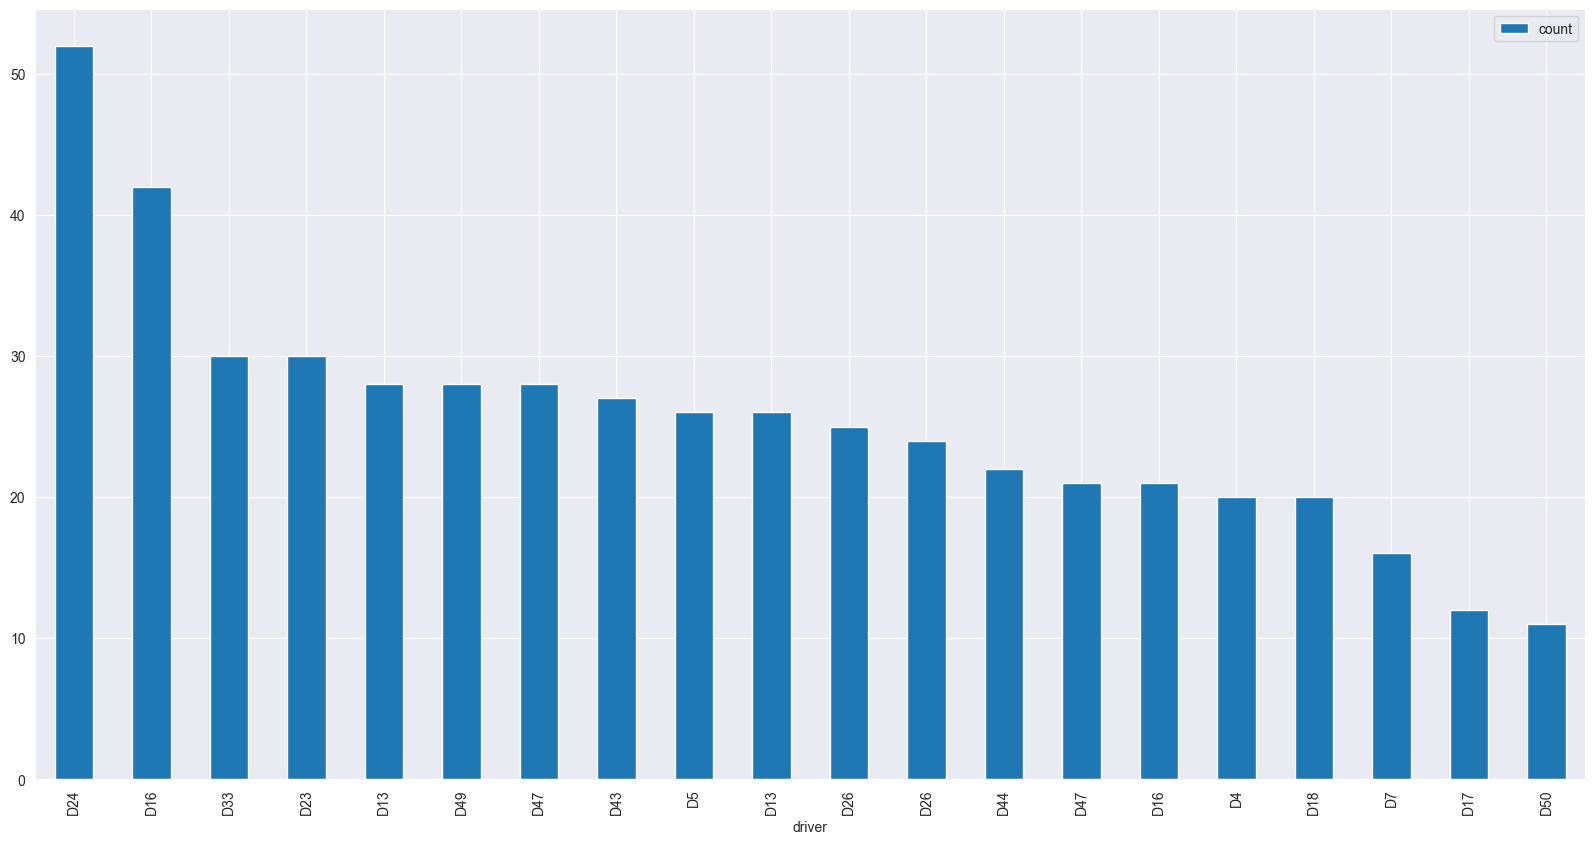

In [36]:
# Show the graph for number of actual routes for each driver and standard route using a bar chart and should be sorted in descending order
actual_routes_count.sort_values(by='count', ascending=False).plot.bar(x='driver', y='count', figsize=(20, 10))

In [37]:
# Finding the number of drivers for each standard route
standard_routes_count = actual_routes_count.groupby('s_id').size().reset_index(name='count')
standard_routes_count

,s_id,count
0,s1,1
1,s10,1
2,s13,2
3,s15,1
4,s17,2
5,s18,1
6,s19,1
7,s2,1
8,s4,4
9,s5,1


In [38]:
# Finding the number of standard routes for each driver
driver_routes_count = actual_routes_count.groupby('driver').size().reset_index(name='count')
driver_routes_count.sample(10)

,driver,count
0,D13,2
1,D16,2
7,D33,1
3,D18,1
11,D47,2
14,D50,1
8,D4,1
15,D7,1
6,D26,2
10,D44,1


In [56]:
driver_routes_count.head(100)

,driver,count
0,D13,2
1,D16,2
2,D17,1
3,D18,1
4,D23,1
5,D24,1
6,D26,2
7,D33,1
8,D4,1
9,D43,1


In [39]:
def route_to_string(route_):
    """
    Convert a route (list of leg dictionaries) to a standardized string format.
    
    @param route_: list of leg (trips) dictionaries. (A route is a list of trips from one location to another with merchandise)
    
    @return: string representation of the route
    """
    return ' '.join(["{}-{}".format(leg['from'], leg['to']) for leg in route_])

def calculate_drivers_actual_route_statistics(driver_routes, std_route_dict):
    """
    Calculate statistics for a driver's routes.
    
    @param driver_routes: DataFrame containing the driver's routes
    @param std_route_dict: dictionary mapping standard route IDs to their route strings
    
    @return: dictionary containing the statistics (total_actual_routes, same_varied_actual_routes, same_std_route, different_varied_actual_routes)
    """
    same_varied_actual_routes = Counter()  # Number of actual routes that are the same as another actual route
    different_varied_actual_routes = 0  # Number of actual routes that are different from the standard route
    same_std_route = 0  # Number of actual routes that are the same as the standard route
    
    for _, route_row in driver_routes.iterrows():
        # get the standard route from the dictionary using the standard route ID from the actual route of driver
        std_route = std_route_dict.get(route_row['s_id'], "")
        
        # get the actual route followed by the driver as a string ignoring the merchandise
        act_route = route_to_string(route_row['route'])  
        
        same_varied_actual_routes.update([act_route])  # update the counter for the actual route
        if act_route == std_route:  # if the actual route is the same as the standard route
            same_std_route += 1
        else:  # if the actual route is different from the standard route
            different_varied_actual_routes += 1
    
    # get the number of actual routes that are the same as another actual route
    repeated_actual_routes = sum(1 for count in same_varied_actual_routes.values() if count > 1)
    
    return {
        'total_actual_routes': len(driver_routes),
        'same_varied_actual_routes': repeated_actual_routes,
        'same_std_route': same_std_route,
        'different_varied_actual_routes': different_varied_actual_routes - repeated_actual_routes
    }

def analyze_driver_routes(actual_routes_df_, standard_routes_df_):
    """
    Analyze routes for all drivers.
    
    @param actual_routes_df_: DataFrame containing the actual routes
    @param standard_routes_df_: DataFrame containing the standard routes
    
    @return: dictionary mapping driver IDs to their route statistics
    """
    driver_actual_routes_analysis = {}

    # Create a dictionary mapping standard route IDs to their route strings
    std_route_dict = {row['s_id']: route_to_string(row['route']) for _, row in standard_routes_df_.iterrows()}

    for driver_ in actual_routes_df_['driver'].unique():
        driver_routes = actual_routes_df_[actual_routes_df_['driver'] == driver_]
        driver_actual_routes_analysis[driver_] = calculate_drivers_actual_route_statistics(driver_routes, std_route_dict)

    return driver_actual_routes_analysis

In [40]:
# Use the analyze_driver_routes function to get the analysis
driver_actual_routes_followed_analysis = analyze_driver_routes(actual_routes_df, standard_routes_df)

# Convert the analysis to a DataFrame
driver_actual_routes_followed_analysis_df = pd.DataFrame(driver_actual_routes_followed_analysis).T
driver_actual_routes_followed_analysis_df

,total_actual_routes,same_varied_actual_routes,same_std_route,different_varied_actual_routes
D4,20,3,2,15
D47,49,6,11,32
D33,30,4,8,18
D26,49,8,12,29
D49,28,3,4,21
D13,54,5,8,41
D43,27,5,2,20
D23,30,6,12,12
D16,63,8,8,47
D24,52,9,5,38


<Axes: >

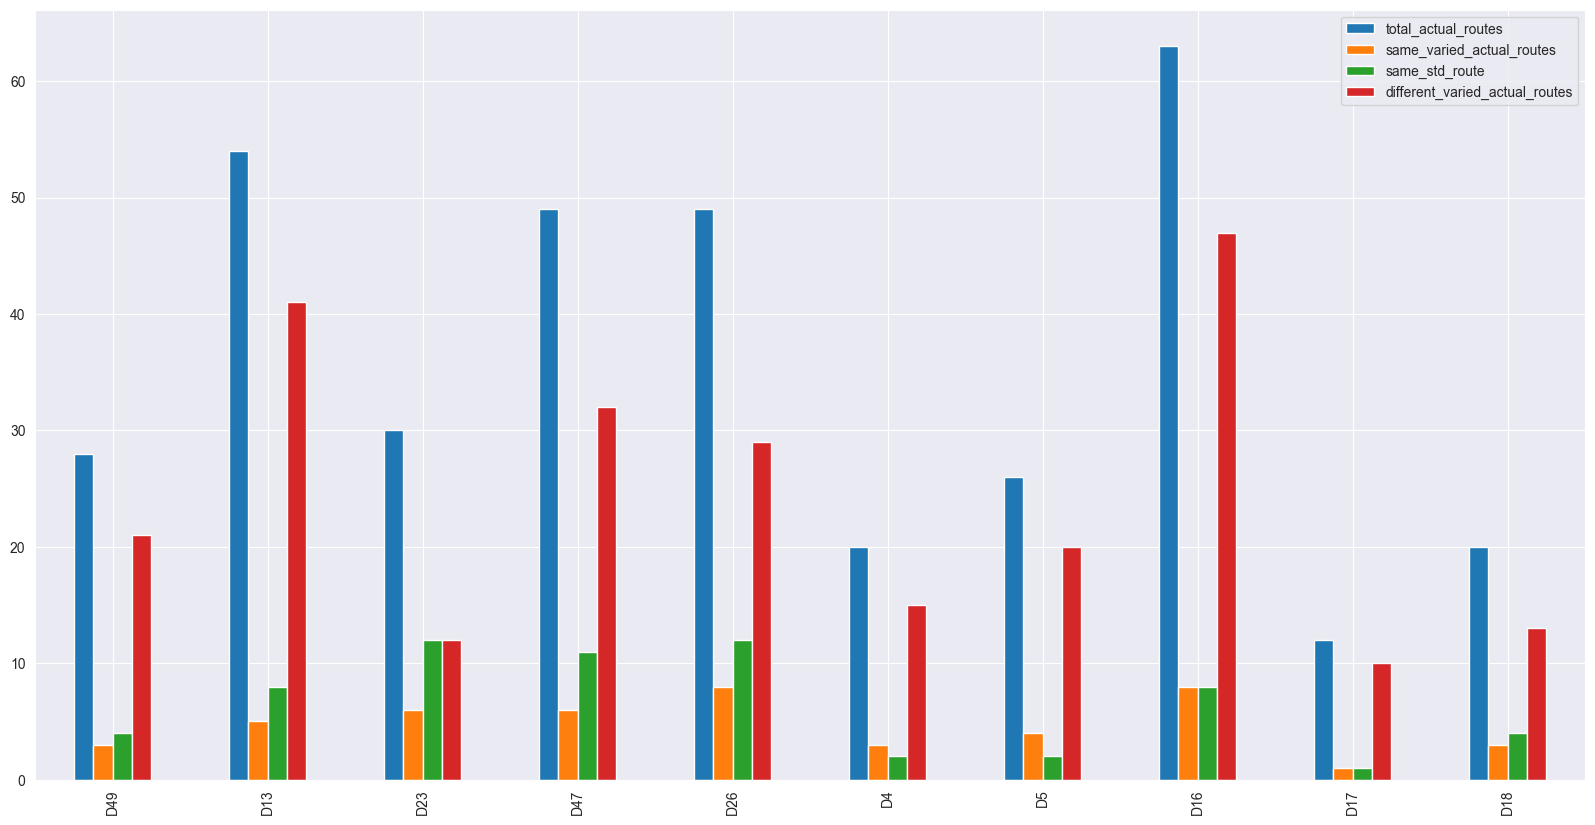

In [41]:
# Randomly plot analysis for 10 drivers
random_drivers = random.sample(list(driver_actual_routes_followed_analysis.keys()), 10)
driver_actual_routes_followed_analysis_df.loc[random_drivers].plot.bar(figsize=(20, 10))

# Data Mining Project

## Importing Libraries

In [46]:
import os
import json
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasketch import MinHash
from collections import Counter
import matplotlib.pyplot as plt
from itertools import permutations
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## 1. Data Preprocessing and Encoding (Vectorization)

### 1.1 RouteDataProcessor

In [47]:
# DataLoader class
class RouteDataProcessor:
    """
    A class to load the data and create vocabulary.
    """

    def __init__(self, std_routes_path, act_routes_path, normalize=True):
        """
        Initialize the DataLoader class.

        @param std_routes_path: path to the standard routes file
        @param act_routes_path: path to the actual routes file
        @param normalize: whether to normalize the data (default: True)
        """
        ###############################################################
        # Loading the data
        ###############################################################
        # Load the standard and actual routes data
        with open(std_routes_path, 'r') as file_:
            standard_routes_ = json.load(file_)

        with open(act_routes_path, 'r') as file_:
            actual_routes_ = json.load(file_)
        ###############################################################
        # Data Preprocessing
        ###############################################################
        if normalize:
            # Normalize the data
            standard_routes_ = self.normalize_standard_routes(standard_routes_)
            actual_routes_ = self.normalize_actual_routes(actual_routes_)
            
        # Create standard and actual routes dataframes
        self.standard_routes_df = pd.DataFrame(standard_routes_)
        self.standard_routes_df['type'] = 'standard'
        self.actual_routes_df = pd.DataFrame(actual_routes_)
        self.actual_routes_df['type'] = 'actual'

        # create cities and trips sequences for each route
        self.standard_routes_df['cities_sequence'] = self.standard_routes_df['route'].apply(
            self.get_route_cities_sequence)
        self.standard_routes_df['trips_sequence'] = self.standard_routes_df['route'].apply(self.get_trips_sequence)

        self.actual_routes_df['cities_sequence'] = self.actual_routes_df['route'].apply(self.get_route_cities_sequence)
        self.actual_routes_df['trips_sequence'] = self.actual_routes_df['route'].apply(self.get_trips_sequence)

        ###############################################################
        # Build the vocabulary
        ###############################################################
        self.cities = set()
        self.cities_pair = set()
        self.trips = set()
        self.merchandise = set()
        self.drivers = set()

        self.max_trip = 0  # Maximum number of trips across all routes
        self.minimum_quantity = float('inf')  # min. qty merchandise across all routes
        self.maximum_quantity = 0  # max. qty merchandise across all routes
        self.vocabulary_size = 0  # size of the vocabulary

        self.city2id = {}
        self.id2city = {}
        self.cities_pair2id = {}
        self.id2cities_pair = {}
        self.trip2id = {}
        self.id2trip = {}
        self.merchandise2id = {}
        self.id2merchandise = {}
        self.driver2id = {}
        self.id2driver = {}

        # Build the vocabulary
        self._build_vocabulary(self.standard_routes_df)
        self._build_vocabulary(self.actual_routes_df)
        ###############################################################
        # Create mappings
        ###############################################################
        self._create_mappings()
        
    @staticmethod
    def normalize_city_names(city):
        if "-" in city:
            city = city.replace("-", " ")

        return city.strip().lower().replace(" ", "_")

    @staticmethod
    def convert_merchandise_quantities(merchandise):
        return {item: int(qty) for item, qty in merchandise.items()}

    @staticmethod
    def normalize_routes(self, routes):
        return [self.normalize_route(route) for route in routes]
    
    @staticmethod
    def get_route_cities_sequence(route):
        """
        Get the sequence of cities in a route.
        e.g. route: [{'from': 'city1', 'to': 'city2'}, {'from': 'city2', 'to': 'city3'}, {'from': 'city3', 'to': 'city4'}]
        cities_sequence: ['city1', 'city2', 'city3', 'city4']

        @param route: route

        @return: sequence of cities in the route
        """
        cities_sequence = []
        for trip in route:
            if len(cities_sequence) == 0:
                cities_sequence.append(trip['from'])
                cities_sequence.append(trip['to'])
            else:
                cities_sequence.append(trip['to'])

        return cities_sequence

    @staticmethod
    def get_trips_sequence(route):
        """
        Get the sequence of city pairs in a route.
        e.g. route: [{'from': 'city1', 'to': 'city2'}, {'from': 'city2', 'to': 'city3'}, {'from': 'city3', 'to': 'city4'}]
        cities_pair_sequence: ['city1-city2', 'city2-city3', 'city3-city4']

        @param route: route

        @return: sequence of city pairs in the route
        """
        cities_pair_sequence = []
        for trip in route:
            cities_pair_sequence.append(
                tuple(
                    [trip['from']] +
                    [trip['to']] +
                    [(merch, qty) for merch, qty in trip['merchandise'].items()]
                )
            )

        return cities_pair_sequence
    
    def normalize_merchant_names(self, merchants):
        return {self.normalize_city_names(merchant): qty for merchant, qty in merchants.items()}
    
    def normalize_trip(self, trip):
        return {
            "from": self.normalize_city_names(trip["from"]),
            "to": self.normalize_city_names(trip["to"]),
            "merchandise": self.convert_merchandise_quantities(trip["merchandise"])
        }
    
    def normalize_route(self, route):
        return [self.normalize_trip(trip) for trip in route]
    
    def normalize_data(self, data, type_):
        if type_ == "standard":
            return {
                "s_id": data["id"],
                "route": self.normalize_route(data["route"])
            }
        elif type_ == "actual":
            return {
                "a_id": data["id"],
                "driver": data["driver"],
                "s_id": data["sroute"],
                "route": self.normalize_route(data["route"])
            }
        else:
            raise ValueError("Invalid type_ value. Valid values are 'standard' and 'actual'")
        
    def normalize_standard_routes(self, standard_routes_):
        return [self.normalize_data(route, "standard") for route in standard_routes_]
    
    def normalize_actual_routes(self, actual_routes_):
        return [self.normalize_data(route, "actual") for route in actual_routes_]
    
    def _build_vocabulary(self, routes_df_):
        """
        Build the vocabulary.
        """
        # Iterate through each route
        for _, row in routes_df_.iterrows():
            # Iterate through each trip in the route
            for i, trip in enumerate(row['route'], start=1):
                # Add the cities to the vocabulary
                self.cities.add(trip['from'])
                self.cities.add(trip['to'])

                # Add the city pair as a trip to the vocabulary
                self.cities_pair.add(f"{trip['from']}-{trip['to']}")

                # Add the driver to the vocabulary
                self.drivers.add(row.get('driver', ""))

                # add merchandise to the vocabulary
                merchandise_ = []
                for item, qty in trip['merchandise'].items():
                    merchandise_.append((item, qty))
                    # Add the merchandise to the vocabulary
                    self.merchandise.add(item)

                    # Update the minimum and maximum quantity of merchandise
                    self.minimum_quantity = min(self.minimum_quantity, qty)
                    self.maximum_quantity = max(self.maximum_quantity, qty)
                
                # Add the trip to the vocabulary
                self.trips.add(tuple([trip['from']] + [trip['to']] + merchandise_))
                
                # Update the maximum number of trips in a route
                self.max_trip = max(self.max_trip, i)

                # Update the minimum and maximum quantity of merchandise
                try:
                    self.minimum_quantity = min(self.minimum_quantity, min(trip['merchandise'].values()))
                except:
                    print(trip)
                    raise ValueError
                self.maximum_quantity = max(self.maximum_quantity, max(trip['merchandise'].values()))

    def _create_mappings(self):
        # Create mappings
        self.city2id = {city: i for i, city in enumerate(self.cities)}
        self.id2city = {i: city for i, city in enumerate(self.cities)}

        self.cities_pair2id = {city_pair: i for i, city_pair in enumerate(self.cities_pair)}
        self.id2cities_pair = {i: city_pair for i, city_pair in enumerate(self.cities_pair)}

        self.trip2id = {trip: i for i, trip in enumerate(self.trips)}
        self.id2trip = {i: trip for i, trip in enumerate(self.trips)}

        self.merchandise2id = {merchandise: i for i, merchandise in enumerate(self.merchandise)}
        self.id2merchandise = {i: merchandise for i, merchandise in enumerate(self.merchandise)}
        
        try:
            self.drivers.remove(np.nan)  # remove 'nan' from the drivers set
        except KeyError:
            pass
        
        try:
            self.drivers.remove("")  # remove empty string from the drivers set
        except KeyError:
            pass
        
        self.driver2id = {driver: i for i, driver in enumerate(self.drivers)}
        self.id2driver = {i: driver for i, driver in enumerate(self.drivers)}

        # Update the vocabulary size
        self.vocabulary_size = len(self.cities) + len(self.trips) + len(self.merchandise) + len(self.drivers)
        
    def get_vocabulary_size(self):
        """
        Get the vocabulary size.

        @return: vocabulary size
        """
        return self.vocabulary_size

    def get_max_trip(self):
        """
        Get the maximum number of trips in a route.

        @return: maximum number of trips in a route
        """
        return self.max_trip

    def get_city_id(self, city):
        """
        Get the ID of a city.

        @param city: city name

        @return: city ID
        """
        return self.city2id.get(city, -1)

    def get_city(self, city_id):
        """
        Get the name of a city.

        @param city_id: city ID

        @return: city name
        """
        return self.id2city.get(city_id, "")

    def get_cities_pair_id(self, cities_pair):
        """
        Get the ID of a city pair.

        :param cities_pair: city pair

        :return:  ID
        """
        return self.cities_pair2id.get(cities_pair, -1)

    def get_cities_pair(self, cities_pair_id):
        """
        Get the name of a city pair.

        :param cities_pair_id: city pair ID

        :return: city pair 
        """
        return self.id2cities_pair.get(cities_pair_id, "")

    def get_merchandise_id(self, merchandise):
        """
        Get the ID of a merchandise.

        @param merchandise: merchandise name

        @return: merchandise ID
        """
        return self.merchandise2id.get(merchandise, -1)

    def get_merchandise(self, merchandise_id):
        """
        Get the name of a merchandise.

        @param merchandise_id: merchandise ID

        @return: merchandise name
        """
        return self.id2merchandise.get(merchandise_id, "")

    def get_trip_id(self, trip):
        """
        Get the ID of a trip.

        @param trip: trip

        @return: trip ID
        """
        return self.trip2id.get(trip, -1)

    def get_trip(self, trip_id):
        """
        Get the trip.

        @param trip_id: trip ID

        @return: trip
        """
        return self.id2trip.get(trip_id, "")

    def get_driver_id(self, driver):
        """
        Get the ID of a driver.

        @param driver: driver name

        @return: driver ID
        """
        return self.driver2id.get(driver, -1)

    def get_driver(self, driver_id):
        """
        Get the name of a driver.

        @param driver_id: driver ID

        @return: driver name
        """
        return self.id2driver.get(driver_id, "")

    def get_standard_routes_df(self):
        """
        Get the standard routes DataFrame.

        @return: standard routes DataFrame
        """
        return self.standard_routes_df

    def get_actual_routes_df(self):
        """
        Get the actual routes DataFrame.

        @return: actual routes DataFrame
        """
        return self.actual_routes_df

    def get_routes_df(self):
        """
        Get the routes DataFrame.

        @return: routes DataFrame
        """
        return self.standard_routes_df, self.actual_routes_df

In [48]:
CWD = os.getcwd()
# DATASET_DIR = os.path.join(CWD, 'Dataset', '20_standard_1k_variations')
# STANDARD_ROUTES_PATH = os.path.join(DATASET_DIR, 'standard.json')
# ACTUAL_ROUTES_PATH = os.path.join(DATASET_DIR, 'actual.json')

DATASET_DIR = os.path.join(CWD, 'Dataset')
STANDARD_ROUTES_PATH = os.path.join(DATASET_DIR, 'standard_routes.json')
ACTUAL_ROUTES_PATH = os.path.join(DATASET_DIR, 'actual_routes.json')

In [52]:
# Create a route_data_processor from the standard and actual routes data
route_data_processor = RouteDataProcessor(STANDARD_ROUTES_PATH, ACTUAL_ROUTES_PATH)

vocabulary_size = route_data_processor.get_vocabulary_size()
max_trip = route_data_processor.get_max_trip()
num_cities = len(route_data_processor.cities)
num_city_pairs = len(route_data_processor.cities_pair)
num_merchandise = len(route_data_processor.merchandise)
max_merchandise_quantity = route_data_processor.maximum_quantity
min_merchandise_quantity = route_data_processor.minimum_quantity
num_trips = len(route_data_processor.trips)
num_drivers = len(route_data_processor.drivers)

print(f"Vocabulary Size: {vocabulary_size}")
print(f"Maximum Number(length) of Trips across all Route: {max_trip}")
print(f"Number of Cities: {num_cities}")
print(f"Number of City Pairs: {num_city_pairs}")
print(f"Number of Merchandise: {num_merchandise}")
print(f"Maximum Quantity of Merchandise: {max_merchandise_quantity}")
print(f"Minimum Quantity of Merchandise: {min_merchandise_quantity}")
print(f"Number of Total Trips: {num_trips}")
print(f"Number of Drivers: {num_drivers}")

Vocabulary Size: 3256
Maximum Number(length) of Trips across all Route: 17
Number of Cities: 46
Number of City Pairs: 371
Number of Merchandise: 12
Maximum Quantity of Merchandise: 50
Minimum Quantity of Merchandise: 1
Number of Total Trips: 3182
Number of Drivers: 16


In [57]:
# get the standard and actual routes dataframes
standard_routes_df = route_data_processor.get_standard_routes_df()
actual_routes_df = route_data_processor.get_actual_routes_df()

In [58]:
standard_routes_df.head()

,s_id,route,type,cities_sequence,trips_sequence
0,s1,"[{'from': 'genoa', 'to': 'monza', 'merchandise...",standard,"[genoa, monza, piacenza, bergamo, novara, mila...","[(genoa, monza, (honey, 30), (water, 46), (tom..."
1,s2,"[{'from': 'genoa', 'to': 'turin', 'merchandise...",standard,"[genoa, turin, bergamo, brescia, monza, parma,...","[(genoa, turin, (chocolate, 17), (honey, 18), ..."
2,s3,"[{'from': 'milan', 'to': 'monza', 'merchandise...",standard,"[milan, monza, piacenza, parma, bologna, moden...","[(milan, monza, (water, 10), (sugar, 28), (tom..."
3,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand...",standard,"[piacenza, milan, bergamo, brescia, verona, pa...","[(piacenza, milan, (pens, 47), (butter, 50), (..."
4,s5,"[{'from': 'taranto', 'to': 'salerno', 'merchan...",standard,"[taranto, salerno, bari, naples, rome, pescara...","[(taranto, salerno, (butter, 39), (tea, 4), (s..."


In [59]:
actual_routes_df.head()

,a_id,driver,s_id,route,type,cities_sequence,trips_sequence
0,a19621,D4,s8,"[{'from': 'rome', 'to': 'sassari', 'merchandis...",actual,"[rome, sassari, florence, ravenna, forlì, ferr...","[(rome, sassari, (sugar, 17), (honey, 42)), (s..."
1,a46090,D4,s8,"[{'from': 'rome', 'to': 'sassari', 'merchandis...",actual,"[rome, sassari, florence, ravenna, forlì, ferr...","[(rome, sassari, (sugar, 15), (honey, 45)), (s..."
2,a38595,D4,s8,"[{'from': 'rome', 'to': 'sassari', 'merchandis...",actual,"[rome, sassari, florence, ravenna, forlì, ferr...","[(rome, sassari, (sugar, 17), (honey, 42)), (s..."
3,a74451,D4,s8,"[{'from': 'rome', 'to': 'sassari', 'merchandis...",actual,"[rome, sassari, florence, ravenna, forlì, ferr...","[(rome, sassari, (sugar, 17), (honey, 42)), (s..."
4,a46127,D4,s8,"[{'from': 'rome', 'to': 'sassari', 'merchandis...",actual,"[rome, sassari, florence, ravenna, forlì, ferr...","[(rome, sassari, (sugar, 4), (honey, 42)), (sa..."


### 1.2 Encoding (Vectorization) of Routes

In [60]:
# Vectorizer class
class RouteVectorizer:
    """
    A class to encode the routes using different suitable encoding schemes.
    """
    def __init__(self, routes_df_, routes_vocab, vectorizer_tech='one-hot', vect_args=None, permutation=256, signatures=True):
        """
        Initialize the RouteVectorizer class.

        @param routes_df_: DataFrame containing the routes
        @param routes_vocab: vocabulary of the routes
        @param vectorizer_tech: vectorization technique to use (default: 'one-hot')
        @param vect_args: arguments for the vectorizer (default: None)
        @param permutation: permutation to use for the vectorization technique (default: 256)
        """
        self.routes_df_ = routes_df_
        self.routes_vocab = routes_vocab
        self.vectorizer_tech = vectorizer_tech
        self.vect_args = vect_args
        self.permutation_val = permutation
        
        # Initialize the vectorizer
        self.vectorizer = self._initialize_vectorizer()
        
        # Encode the data
        self.encoded_routes = self._encode_data(self.routes_df_)
        self.routes_df_['encoded_routes'] = self.encoded_routes
        
        # vectorize the encoded routes
        self.routes_df_['routes_matrix'], self.routes_df_['vectorized_routes'] = zip(*routes_df_['encoded_routes'].apply(lambda val: self._vectorize_data(val)))
        
        # Create the minhash signatures
        if signatures:
            self.routes_df_['minhash_signatures'] = self.routes_df_['routes_matrix'].apply(self._minhash_vectorize_data)
        
    def _initialize_vectorizer(self, vect_args=None):
        """
        Initialize the vectorizer.
        """
        if self.vectorizer_tech == 'one-hot':
            if vect_args is not None:
                return OneHotEncoder(**vect_args)
            else:
                return OneHotEncoder()
        elif self.vectorizer_tech == 'count':
            if vect_args is not None:
                return CountVectorizer(**vect_args)
            else:
                return CountVectorizer()
        elif self.vectorizer_tech == 'tfidf':
            if vect_args is not None:
                return TfidfVectorizer(**vect_args)
            else:
                return TfidfVectorizer()
        else:
            raise ValueError("Invalid vectorizer value. Valid values are 'one-hot' and 'count'")
        
    def _encode_data(self, df_):
        """
        Encode the data.

        @param df_: DataFrame containing the data to encode

        @return: encoded DataFrame
        """
        encoded_routes = list()
        for _, row in df_.iterrows():
            encoded_route = list()
            for trip in row['route']:
                encoded_cities = (
                    self.routes_vocab.city2id[trip['from']], 
                    self.routes_vocab.city2id[trip['to']]
                )
                encoded_merchandise = {
                    self.routes_vocab.merchandise2id[item]: qty for item, qty in trip['merchandise'].items()
                }
                
                # e.g. ((1, 2), {3: 10, 4: 20})
                encoded_trip = encoded_cities, encoded_merchandise
                encoded_route.append(encoded_trip)  # list of encoded trips
                
            encoded_routes.append(encoded_route)
            
        return encoded_routes
    
    def _vectorize_data(self, encoded_routes_):
        """
        Vectorize the encoded routes.
        
        @param encoded_routes_: encoded routes
        
        @return: routes matrix and route vector
        """
        cities_vector_length = len(self.routes_vocab.city2id)
        merch_vector_length = len(self.routes_vocab.merchandise2id)
        max_trip_count = self.routes_vocab.max_trip
        
        routes_matrix = np.zeros((max_trip_count, cities_vector_length + merch_vector_length))
        
        for index, (cities, merchandise) in enumerate(encoded_routes_):
            # vectorize the cities
            cities_vector = np.zeros(len(self.routes_vocab.city2id))
            cities_vector[cities[0]] = 2 * index + 1  # to make start cities odd
            cities_vector[cities[1]] = 2 * index + 2  # to make end cities even
            
            # vectorize the merchandise
            merchandise_vector = np.zeros(len(self.routes_vocab.merchandise2id))
            for merch, qty in merchandise.items():
                merchandise_vector[merch] = qty
                
            # normalize the merchandise vectors
            merchandise_vector = merchandise_vector / self.routes_vocab.maximum_quantity
            # merchandise_vector = merchandise_vector / (self.routes_vocab.max_trip * 2)
            
            # vectorize the trip
            trip_vector = np.concatenate([cities_vector, merchandise_vector])
            
            routes_matrix[index, :] = trip_vector  # add the trip vector to the vector matrix
            
        route_vector_ = np.array(routes_matrix.flatten())
        
        return routes_matrix, route_vector_
    
    def _minhash_vectorize_data(self, vectorized_routes_):
        """
        Create the minhash signatures for the vectorized routes.
        
        @param vectorized_routes_: vectorized routes
        
        @return: minhash signatures for the vectorized routes
        """
        # Create the minhash signatures for the vectorized routes
        minhash_signatures = MinHash(num_perm=self.permutation_val)
        minhash_signatures.update(vectorized_routes_.tobytes())
        
        return list(minhash_signatures.hashvalues)
    
    def get_routes_df(self):
        """
        Get the routes DataFrame.
        
        @return: routes DataFrame
        """
        return self.routes_df_
    
    def get_vectorized_routes(self):
        """
        Get the vectorized routes.
        
        @return: vectorized routes
        """
        return self.routes_df_['vectorized_routes'].values
    
    def get_minhash_signatures(self):
        """
        Get the minhash signatures for the vectorized routes.
        
        @return: minhash signatures for the vectorized routes
        """
        return self.routes_df_['minhash_signatures'].values
    
    def get_routes_matrix(self):
        """
        Get the route's matrix.
        
        @return: routes matrix
        """
        return self.routes_df_['routes_matrix'].values
    
    def get_routes_matrix_shape(self):
        """
        Get the shape of the route's matrix.
        
        @return: shape of the routes matrix
        """
        return self.routes_df_['routes_matrix'].values.shape
    
    def get_routes_matrix_flattened(self):
        """
        Get the flattened route's matrix.
        
        @return: flattened routes matrix
        """
        
        return self.routes_df_['routes_matrix'].values.flatten()
    
    def get_routes_matrix_flattened_shape(self):
        """
        Get the shape of the flattened routes' matrix.
        
        @return: shape of the flattened routes matrix
        """
        return self.routes_df_['routes_matrix'].values.flatten().shape

In [61]:
# create a route vectorizer
std_route_vectorize = RouteVectorizer(standard_routes_df, route_data_processor, vectorizer_tech='one-hot')
act_route_vectorize = RouteVectorizer(actual_routes_df, route_data_processor, vectorizer_tech='one-hot')

In [62]:
# get the vectorized routes
std_vectorized_routes_df = std_route_vectorize.get_routes_df()
act_vectorized_routes_df = act_route_vectorize.get_routes_df()

In [63]:
std_vectorized_routes_df.sample(5)

,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures
3,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand...",standard,"[piacenza, milan, bergamo, brescia, verona, pa...","[(piacenza, milan, (pens, 47), (butter, 50), (...","[((37, 3), {10: 47, 2: 50, 8: 1}), ((3, 0), {1...","[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1432415680, 3412807121, 1855634698, 162666495..."
0,s1,"[{'from': 'genoa', 'to': 'monza', 'merchandise...",standard,"[genoa, monza, piacenza, bergamo, novara, mila...","[(genoa, monza, (honey, 30), (water, 46), (tom...","[((8, 16), {3: 30, 11: 46, 6: 14}), ((16, 37),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[789712563, 457038163, 2299312437, 265276142, ..."
17,s18,"[{'from': 'catania', 'to': 'palermo', 'merchan...",standard,"[catania, palermo, siracusa, reggio_di_calabri...","[(catania, palermo, (bread, 13), (sugar, 27), ...","[((5, 18), {7: 13, 9: 27, 0: 46}), ((18, 10), ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[2067914733, 3171968180, 3966004467, 211017116..."
19,s20,"[{'from': 'bologna', 'to': 'forlì', 'merchandi...",standard,"[bologna, forlì, ferrara, ravenna]","[(bologna, forlì, (sugar, 14), (tomatoes, 4), ...","[((20, 38), {9: 14, 6: 4, 4: 44, 8: 50}), ((38...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3645253075, 2080583107, 3658653703, 277258027..."
16,s17,"[{'from': 'trieste', 'to': 'ravenna', 'merchan...",standard,"[trieste, ravenna, forlì, florence, prato, reg...","[(trieste, ravenna, (tomatoes, 2), (pens, 4)),...","[((45, 15), {6: 2, 10: 4}), ((15, 38), {4: 44,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4093509282, 1312122206, 3064960054, 837284665..."


In [64]:
act_vectorized_routes_df.sample(5)

,a_id,driver,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures
49,a43840,D33,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand...",actual,"[piacenza, milan, bergamo, brescia, verona, pa...","[(piacenza, milan, (pens, 26), (butter, 50)), ...","[((37, 3), {10: 26, 2: 50}), ((3, 0), {11: 1, ...","[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3413749465, 950993220, 1718657839, 1700035170..."
202,a67790,D23,s6,"[{'from': 'giugliano_in_campania', 'to': 'lati...",actual,"[giugliano_in_campania, latina, rimini, ancona...","[(giugliano_in_campania, latina, (sugar, 19), ...","[((29, 35), {9: 19, 0: 29}), ((35, 17), {3: 19...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1295436322, 4195581858, 2503784145, 243818092..."
347,a46724,D47,s15,"[{'from': 'forlì', 'to': 'modena', 'merchandis...",actual,"[forlì, modena, bologna, prato, ravenna, flore...","[(forlì, modena, (chocolate, 2), (bread, 29)),...","[((38, 42), {1: 2, 7: 29}), ((42, 20), {1: 5, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2103205094, 360858169, 199081494, 1484876563,..."
329,a16995,D13,s4,"[{'from': 'piacenza', 'to': 'milan', 'merchand...",actual,"[piacenza, milan, monza, brescia, verona, padova]","[(piacenza, milan, (pens, 47), (butter, 50), (...","[((37, 3), {10: 47, 2: 50, 8: 1}), ((3, 16), {...","[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3670726876, 3461462078, 3295081185, 376842360..."
193,a98022,D23,s6,"[{'from': 'giugliano_in_campania', 'to': 'lati...",actual,"[giugliano_in_campania, latina, terni, ancona,...","[(giugliano_in_campania, latina, (sugar, 20), ...","[((29, 35), {9: 20, 0: 13}), ((35, 43), {3: 14...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2430884600, 108707631, 543489430, 2989012680,..."


In [65]:
# combine the standard and actual vectorized routes
vectorized_routes_df = pd.merge(
    act_vectorized_routes_df, 
    std_vectorized_routes_df, on='s_id', how='inner', suffixes=( '_act', '_std')
)

In [66]:
vectorized_routes_df.sample(10)

,a_id,driver,s_id,route_act,type_act,cities_sequence_act,trips_sequence_act,encoded_routes_act,routes_matrix_act,vectorized_routes_act,minhash_signatures_act,route_std,type_std,cities_sequence_std,trips_sequence_std,encoded_routes_std,routes_matrix_std,vectorized_routes_std,minhash_signatures_std
341,a6077,D26,s19,"[{'from': 'trieste', 'to': 'ferrara', 'merchan...",actual,"[trieste, ferrara, venice, udine, padova, ferr...","[(trieste, ferrara, (tomatoes, 7)), (ferrara, ...","[((45, 36), {6: 7}), ((36, 14), {6: 15}), ((14...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[480297222, 4066622508, 4185453285, 125334567,...","[{'from': 'trieste', 'to': 'venice', 'merchand...",standard,"[trieste, venice, udine, padova, vicenza, vero...","[(trieste, venice, (tomatoes, 10)), (venice, u...","[((45, 14), {6: 10}), ((14, 30), {9: 2, 4: 36}...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3015353414, 390367881, 2748613712, 2288540583..."
392,a44350,D24,s10,"[{'from': 'ferrara', 'to': 'trento', 'merchand...",actual,"[ferrara, trento, padova]","[(ferrara, trento, (tomatoes, 50)), (trento, p...","[((36, 12), {6: 50}), ((12, 22), {6: 16})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1040969510, 3506603288, 2574204668, 301685480...","[{'from': 'vicenza', 'to': 'trento', 'merchand...",standard,"[vicenza, trento, padova]","[(vicenza, trento, (tomatoes, 44)), (trento, p...","[((28, 12), {6: 44}), ((12, 22), {6: 16})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3815455231, 2313086892, 125667645, 1081695607..."
395,a18445,D24,s10,"[{'from': 'ferrara', 'to': 'vicenza', 'merchan...",actual,"[ferrara, vicenza, trento, padova]","[(ferrara, vicenza, (tomatoes, 44)), (vicenza,...","[((36, 28), {6: 44}), ((28, 12), {6: 5}), ((12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[743775404, 919321175, 2580069200, 1786970690,...","[{'from': 'vicenza', 'to': 'trento', 'merchand...",standard,"[vicenza, trento, padova]","[(vicenza, trento, (tomatoes, 44)), (trento, p...","[((28, 12), {6: 44}), ((12, 22), {6: 16})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3815455231, 2313086892, 125667645, 1081695607..."
360,a18027,D24,s10,"[{'from': 'brescia', 'to': 'vicenza', 'merchan...",actual,"[brescia, vicenza, trento, bolzano, padova]","[(brescia, vicenza, (tomatoes, 27)), (vicenza,...","[((13, 28), {6: 27}), ((28, 12), {6: 25}), ((1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3810931521, 624850703, 3845286750, 186296146,...","[{'from': 'vicenza', 'to': 'trento', 'merchand...",standard,"[vicenza, trento, padova]","[(vicenza, trento, (tomatoes, 44)), (trento, p...","[((28, 12), {6: 44}), ((12, 22), {6: 16})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3815455231, 2313086892, 125667645, 1081695607..."
387,a94547,D24,s10,"[{'from': 'vicenza', 'to': 'brescia', 'merchan...",actual,"[vicenza, brescia, padova]","[(vicenza, brescia, (tomatoes, 49)), (brescia,...","[((28, 13), {6: 49}), ((13, 22), {6: 16})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2309926299, 1919730148, 566154048, 536542946,...","[{'from': 'vicenza', 'to': 'trento', 'merchand...",standard,"[vicenza, trento, padova]","[(vicenza, trento, (tomatoes, 44)), (trento, p...","[((28, 12), {6: 44}), ((12, 22), {6: 16})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3815455231, 2313086892, 125667645, 1081695607..."
243,a84734,D43,s7,"[{'from': 'forlì', 'to': 'ferrara', 'merchandi...",actual,"[forlì, ferrara,

## 2. Dimensionality Reduction (PCA or SVD)

In [67]:
class DimensionalityReducer:
    """
    A class to perform dimensionality reduction on the vectorized routes.
    """
    def __init__(self, vectorized_routes_, **kwargs):
        """
        Initialize the DimensionalityReducer class.
        
        @param vectorized_routes_: vectorized routes
        @param kwargs: additional arguments for the dimensionality reduction technique
        """
        self.vectorized_routes_ = vectorized_routes_
        self.kwargs = kwargs
        
        # Perform dimensionality reduction
        self.reduced_routes = self._reduce_dimensionality(self.vectorized_routes_, **self.kwargs)
        
    @staticmethod
    def _reduce_dimensionality(vectorized_routes_, **kwargs):
        """
        Perform dimensionality reduction on the vectorized routes.
        
        @param vectorized_routes_: vectorized routes
        @param kwargs: additional arguments for the dimensionality reduction technique
        
        @return: reduced routes
        """
        # if dimensionality reduction technique is PCA
        if kwargs.get('technique', 'pca') == 'pca':
            pca = PCA(n_components=kwargs.get('n_components', 2))
            reduced_routes_ = pca.fit_transform(vectorized_routes_)
        # if dimensionality reduction technique is SVD
        elif kwargs.get('technique', 'svd') == 'svd':
            svd = TruncatedSVD(n_components=kwargs.get('n_components', 2))
            reduced_routes_ = svd.fit_transform(vectorized_routes_)
        else:
            raise ValueError("Invalid dimensionality reduction technique. Valid values are 'pca' and 'svd'")
        
        return reduced_routes_
    
    def get_reduced_routes(self):
        """
        Get the reduced routes.
        
        @return: reduced routes
        """
        return self.reduced_routes

## 2. Recommendation System(s)

- Content-based: Recommends items similar to what a user has liked in the past. It's based on the attributes of the items and a profile of the user's preferences. It relies heavily on the features of the items themselves in this case, about each route, such as the types of cities or locations included, specific characteristics of each trip, road conditions, scenic value, and so on. However, in our data, we don't have any such features.

- Collaborative filtering: It relies on the assumption that similar users like similar items. Similarity measures between users and/or items are used to make recommendations. It's based on the idea that people who agreed in their evaluation of certain items in the past are likely to agree again in the future. For example, if a driver-A likes routes 1, 2, 3 and driver-B likes routes 2, 3, 4, then they have similar interests and driverA should like route 4 and driver-B should like route 1. It's of two types:
    - User-based: It finds users that are similar to the target user and recommends items they have liked.
    - Item-based: It focuses on finding items similar to the ones the user already likes.

- To design recommendation system for routes recommendation, which involves clustering routes and identifying patterns in trip data, a collaborative filtering approach seems suitable.
- This is because:
    - Data involves routes and trips which can be seen as 'items' in the recommendation context.
    - We can find similarities between different routes (items) based on users' (drivers') preferences or behaviors. Means user based collaborative filtering.
    - This approach will be leans towards a hybrid model that incorporates both drivers-based and routes-based collaborative filtering techniques. 

Data Collection and Preprocessing:

Collect data on standard and actual routes taken by drivers.
Preprocess the data to extract meaningful features such as cities, trips, merchandise, and driver information.
Utility Matrix Construction:

Build a utility matrix to represent the interaction of drivers (users) with various trips (items).
This matrix will form the basis of both user-based and item-based collaborative filtering techniques.
User-Based Collaborative Filtering:

Develop driver profiles based on their history and interactions with different trips, using the utility matrix.
Implement a similarity measure (e.g., cosine similarity) to find similar drivers based on their profiles.
Predict ratings for untried trips for each driver based on the preferences of similar drivers. This will be achieved using the predict_ratings_with_driver_profile_top_k method, focusing on top-k similar drivers for making recommendations.
Item-Based Collaborative Filtering:

Analyze the utility matrix to understand how each trip (item) is valued by different drivers (users).
Calculate the utility of each trip for each driver by comparing actual routes with standard ones and evaluating the trips within these routes.
Use this analysis to understand drivers' preferences for specific trips and to identify similar trips based on driver feedback.
Hybrid Collaborative Filtering Implementation:

Combine the insights from both user-based and item-based collaborative filtering to enhance the recommendation system.
The hybrid approach leverages the strengths of both methods, offering a more nuanced view of driver preferences and trip characteristics.
This combined strategy aims to provide more accurate and personalized route recommendations.

In [68]:
# # function to return the actual routes for a driver
# def get_driver_actual_routes(id_, routes_df_):
#     """
#     Get the actual routes for a driver.
#     
#     @param id_: driver ID
#     @param routes_df_: DataFrame containing the routes vectorized
#     
#     @return: actual routes for the driver
#     """
#     return routes_df_[(routes_df_['driver'] == id_) & (routes_df_['type'] == 'actual')]
# 
# # function to return the standard route based on the route ID
# def get_standard_route(route_id, routes_df_):
#     """
#     Get the standard route based on the route ID.
#     
#     @param route_id: route ID
#     @param routes_df_: DataFrame containing the vectorized routes
#     
#     @return: standard route
#     """
#     return routes_df_[(routes_df_['s_id'] == route_id) & (routes_df_['type'] == 'standard')]

In [69]:
# matrix factorization
class MatrixFactorization:
    """
    A class to perform matrix factorization to create Utility Matrix based on the routes taken by drivers (drivers x trips).
    """
    def __init__(self, df_, routes_vocab_, vectors_col='vectorized_routes'):
        """
        Initialize the MatrixFactorization class.
        
        @param df_: DataFrame containing the routes
        @param routes_vocab_: vocabulary of the routes
        @param vectors_col: column name containing the vectorized routes (default: 'vectorized_routes')
        """
        self.df_ = df_
        self.routes_vocab_ = routes_vocab_
        self.vectors_col = vectors_col
        
        # Get the number of drivers
        self.num_drivers = len(self.routes_vocab_.drivers)
        
        # Get the number of trips
        self.num_trips = len(self.routes_vocab_.trips)
        
        # Get the number of cities
        self.num_cities = len(self.routes_vocab_.cities)
        
        # Get the number of merchandise
        self.num_merchandise = len(self.routes_vocab_.merchandise)
        
        # Get the number of cities pair
        self.num_cities_pair = len(self.routes_vocab_.cities_pair)
        
        # Create the utility matrix
        self.utility_matrix, self.count_matrix, self.sum_matrix = self.create_utility_matrix()
        
    def create_utility_matrix(self):
        """
        Create the utility matrix.
        
        @return: utility matrix
        """
        # initialize the sum and count matrices for the utility matrix
        sum_matrix_ = np.zeros((self.num_drivers, self.num_trips))
        count_matrix_ = np.zeros((self.num_drivers, self.num_trips))
        trip_vector_length = self.num_cities + self.num_merchandise
        
        # iterate through each driver
        for _, row in tqdm(self.df_.iterrows(), total=self.df_.shape[0]):
            # get the actual & standard routes trips
            act_route_trips = row['trips_sequence_act']
            std_route_trips = row['trips_sequence_std']
            
            # get the actual & standard routes vectors
            act_route_vector = row[self.vectors_col + '_act']
            std_route_vector = row[self.vectors_col + '_std']
            
            for act_index, act_trip_seq in enumerate(act_route_trips):
                act_trip_id = self.routes_vocab_.get_trip_id(act_trip_seq)
                
                # similarity measure
                cum_similarity = 0
                comp_count = 0
                
                # compare the actual trip with the standard trips
                for k in range(len(std_route_trips)):
                    # get the standard trip vector slice
                    std_vector_slice = std_route_vector[k * trip_vector_length : (k + 1) * trip_vector_length]
                    
                    # get the actual trip vector
                    act_vector_slice = act_route_vector[k * trip_vector_length : (k + 1) * trip_vector_length]
                    
                    # calculate the similarity between the actual and standard trip vectors
                    similarity_ = cosine_similarity(
                        act_vector_slice.reshape(1, -1), 
                        std_vector_slice.reshape(1, -1)
                    )[0, 0]
                    
                    if similarity_ == 1 and act_index == k:
                        cum_similarity = 1
                        comp_count = 1
                        break
                        
                    cum_similarity += similarity_
                    comp_count += 1
                
                driver_id = self.routes_vocab_.get_driver_id(row['driver'])
                # update the sum and count matrices
                sum_matrix_[driver_id, act_trip_id] += cum_similarity
                count_matrix_[driver_id, act_trip_id] += comp_count
                    
        # calculate the utility matrix
        # Mask to handle the division by zero
        mask = count_matrix_ != 0
        u_matrix_ = np.zeros_like(sum_matrix_, dtype=float)
        u_matrix_[mask] = np.round(sum_matrix_[mask] / count_matrix_[mask], 5)
        
        return u_matrix_, count_matrix_ / np.max(count_matrix_), sum_matrix_
    
    # function to predict ratings for untried trips for each driver based on the preferences of similar drivers
    def predict_ratings(self, utility_matrix_, count_matrix_, top_k_drivers, precision=5):
        """
        Predict ratings for untried trips for each driver based on the preferences of similar drivers.
        
        @param utility_matrix_: utility matrix
        @param count_matrix_: count matrix
        @param top_k_drivers: number of similar drivers to consider
        @param precision: precision for rounding off the predicted ratings (default: 5)
        
        @return: predicted ratings
        """
        # initialize the predicted ratings matrix with utility matrix
        predicted_ratings_ = utility_matrix_.copy()
        
        # iterate through each driver
        for driver_1 in tqdm(range(self.num_drivers)):
            # get the top-k similar drivers to driver-1
            top_k_similar_drivers_ = top_k_drivers[driver_1]
            
            # iterate through each trip
            for trip_id in range(self.num_trips):
                # if the trip has not been tried by the driver
                if count_matrix_[driver_1, trip_id] == 0:
                    rating = sum(utility_matrix_[driver_1, driver_2] * self.utility_matrix[driver_2, trip_id] for driver_2 in top_k_similar_drivers_ if self.utility_matrix[driver_2, trip_id] > 0)
                    
                    similarity = sum(utility_matrix_[driver_1, driver_2] for driver_2 in top_k_similar_drivers_ if self.utility_matrix[driver_2, trip_id] > 0)
                    
                    if similarity > 0:
                        predicted_ratings_[driver_1, trip_id] = np.round(rating / similarity, precision)
                    else:
                        # if no similar driver has taken the trip
                        # predicted_ratings_[driver_1, trip_id] = 0
                        pass
        
        # return the predicted ratings matrix level 2 since it's a 2-level matrix
        return predicted_ratings_
    
    # function to get the top-k similar drivers
    @staticmethod
    def _get_top_k_similar_drivers(utility_matrix_, top_k_):
        """
        Get the top-k similar drivers.
        
        @param utility_matrix_: utility matrix
        @param top_k_: number of similar drivers to consider
        
        @return: top-k similar drivers
        """
        utility_matrix_ = csr_matrix(utility_matrix_)
        
        top_k_similar_drivers_ = {}
        
        for k in range(utility_matrix_.shape[0]):
            current_driver = utility_matrix_[k]
            
            if current_driver.nnz == 0:  # if the driver has not taken any trip
                continue
            elif current_driver.nnz > top_k_:
                # get the top-k similar drivers
                top_k_similar_drivers_[k] = np.argsort(-current_driver.data)[:top_k_]
            else:
                top_k_similar_drivers_[k] = np.argsort(-current_driver.data)
                
        return top_k_similar_drivers_

In [70]:
# Apply matrix factorization to create the utility matrix
matrix_factorization = MatrixFactorization(vectorized_routes_df, route_data_processor)

100%|██████████| 509/509 [00:14<00:00, 35.39it/s] 


In [71]:
# Get the utility matrix
utility_matrix = matrix_factorization.utility_matrix

# Get the count matrix
count_matrix = matrix_factorization.count_matrix

# Get the sum matrix
sum_matrix = matrix_factorization.sum_matrix

In [72]:
print(f'Utility matrix level 1 loaded.')
print(f' - Shape: {utility_matrix.shape}')
print(f' - Max value: {utility_matrix.max()}')
print(f' - Min value: {utility_matrix.min()}')
print(f' - Mean value: {utility_matrix.mean()}')

Utility matrix level 1 loaded.
 - Shape: (16, 3182)
 - Max value: 1.0
 - Min value: 0.0
 - Mean value: 0.031884354965430545


### 2.1 Driver-Based Collaborative Filtering

In [73]:
dimension_reducer = DimensionalityReducer(
    matrix_factorization.utility_matrix, technique='pca', n_components=10
)

# Get the reduced routes
reduced_routes = dimension_reducer.reduced_routes

precision = 5  # precision for rounding off the predicted ratings

# calculate similarity scores for the driver profiles
driver_profiles = np.round(cosine_similarity(reduced_routes), precision)

In [22]:
# # Driver-based Collaborative Filtering
# class DriverBasedCollaborativeFiltering:
#     """
#     A class to perform driver-based collaborative filtering to make route recommendations.
#     """
#     def __init__(self, utility_matrix_, routes_vocab_, precision=5, components=10):
#         """
#         Initialize the DriverBasedCollaborativeFiltering class.
#         
#         @param utility_matrix_: utility matrix
#         @param routes_vocab_: vocabulary of the routes
#         @param precision: precision for rounding off the predicted ratings (default: 5)
#         @param components: number of components for dimensionality reduction (default: 10)
#         """
#         self.utility_matrix_ = utility_matrix_
#         self.routes_vocab_ = routes_vocab_
#         self.precision = precision
#         self.components = components
#         
#         # driver profiles
#         self.driver_profiles = self.create_driver_profiles()
#         
#     def create_driver_profiles(self):
#         """
#         Create driver profiles based on their history and interactions with different trips.
#         
#         @return: driver profiles
#         """
#         # apply the dimensionality reduction to the utility matrix to create driver profiles based on their history and interactions with different trips
#         
#         # 1. with SVD
#         # driver_profiles = TruncatedSVD(n_components=self.components).fit_transform(self.utility_matrix_)
#         
#         # 2. with PCA
#         driver_profiles = PCA(n_components=self.components).fit_transform(self.utility_matrix_)
#         
#         # calculate similarity scores for the driver profiles
#         return np.round(cosine_similarity(driver_profiles), self.precision)

In [23]:
# # Apply driver-based collaborative filtering to make route recommendations
# profiles = DriverBasedCollaborativeFiltering(matrix_factorization.utility_matrix, route_data_processor, precision=5, components=10)

In [74]:
print(f'Driver profiles level 1 loaded.')
print(f' - Shape: {driver_profiles.shape}')
print(f' - Max value: {driver_profiles.max()}')
print(f' - Min value: {driver_profiles.min()}')
print(f' - Mean value: {driver_profiles.mean()}')

Driver profiles level 1 loaded.
 - Shape: (16, 16)
 - Max value: 1.0
 - Min value: -0.37116
 - Mean value: 0.066376953125


In [75]:
# top-k similar drivers for a driver
top_k_similar_drivers = MatrixFactorization._get_top_k_similar_drivers(driver_profiles, 5)

In [76]:
top_k_similar_drivers

{0: array([ 0, 10,  5,  9, 15], dtype=int64),
 1: array([ 1, 11,  4, 13,  7], dtype=int64),
 2: array([ 2, 14,  4,  6,  8], dtype=int64),
 3: array([ 3, 11,  1,  4, 13], dtype=int64),
 4: array([ 4,  0,  2, 10,  5], dtype=int64),
 5: array([ 5, 10,  0, 15,  9], dtype=int64),
 6: array([ 6, 14,  0, 10,  5], dtype=int64),
 7: array([ 7,  9,  0, 10,  6], dtype=int64),
 8: array([ 8, 14, 13,  2,  6], dtype=int64),
 9: array([ 9,  0, 10,  7,  5], dtype=int64),
 10: array([10,  0,  5, 15,  9], dtype=int64),
 11: array([11,  0, 10,  5,  4], dtype=int64),
 12: array([12, 11,  1, 13,  4], dtype=int64),
 13: array([13,  8, 11,  4,  1], dtype=int64),
 14: array([14,  6,  2,  0,  8], dtype=int64),
 15: array([15,  5, 10,  0,  6], dtype=int64)}

In [77]:
# predicted ratings for untried trips for each driver based on the preferences of similar drivers
predicted_ratings = matrix_factorization.predict_ratings(utility_matrix, count_matrix, top_k_similar_drivers, precision=5)

100%|██████████| 16/16 [00:00<00:00, 67.33it/s]


In [78]:
print(f'Predicted ratings level 2 loaded.')
print(f' - Shape: {predicted_ratings.shape}')
print(f' - Max value: {predicted_ratings.max()}')
print(f' - Min value: {predicted_ratings.min()}')
print(f' - Mean value: {predicted_ratings.mean()}')

Predicted ratings level 2 loaded.
 - Shape: (16, 3182)
 - Max value: 1.0
 - Min value: 0.0
 - Mean value: 0.037354173868636084


In [79]:
type(predicted_ratings)

numpy.ndarray

## Profiles Ranking

In [80]:
class DriversProfilesRanker:
    def __init__(self, routes_df_, utility_matrix_, count_matrix_, vocabulary):
        """
        Initializes the DriversProfilesRanker with the necessary data.
        
        Args:
        - routes_df (pandas.DataFrame): DataFrame containing the route's data.
        - utility_matrix_ (numpy.ndarray): The utility matrix representing trip ratings.
        - count_matrix_ (numpy.ndarray): The count matrix representing the number of trips taken by drivers.
        - vocabulary (object): Object containing mapping from trip details to IDs and back.
        """
        self.routes_df = routes_df_
        self.utility_matrix = utility_matrix_
        self.count_matrix = count_matrix_
        self.vocabulary = vocabulary

    def compute_ranking(self):
        """
        Compute and evaluates trips based on the utility matrix and ranks them accordingly.
        
        Returns:
        - pandas.DataFrame: A DataFrame containing trip evaluation scores and additional information.
        """
        # Initialize arrays to hold calculation results
        sum_trips = np.where(
            self.utility_matrix != 0, self.utility_matrix, 0).sum(axis=0)
        count_trips = (self.utility_matrix != 0).sum(axis=0)
        
        # Avoid division by zero by adding a small value to the count
        count_trips = np.where(count_trips == 0, 1e-5, count_trips)
        
        # Calculate trip evaluation scores
        trip_scores = sum_trips / count_trips
        
        # trip_scores = np.divide(
        #     sum_trips, count_trips, out=np.zeros_like(sum_trips)
        # )
        
        counts_ = self.count_matrix.sum(axis=0)
        normalized_counts = counts_/np.max(counts_)
        score = trip_scores * normalized_counts
        normalized_score = score / score.max()
        
        # return the computed trip evaluation scores
        trip_ranking_df = pd.DataFrame({
                'trip_id': range(len(self.vocabulary.trip2id)),
                'trip': [self.vocabulary.id2trip[trip_id] for trip_id in range(len(self.vocabulary.trip2id))],
                'trip_score': trip_scores,
                'count': counts_,
                'normalized_count': normalized_counts,
                'score': score,
                'normalized_score': normalized_score
            })
        
        trip_ranking_df.set_index('trip_id', inplace=True)
        # Sort the trips based on the evaluation scores
        trip_ranking_df = trip_ranking_df.sort_values(by='normalized_score', ascending=False)
        
        return trip_ranking_df
        
    def incorporate_trip_features(self, tips_col='trips_sequence', rank_col='normalized_score', col_for_combination='routes_matrix'):
        """
        Adds a trip-level feature to the routes DataFrame based on the trip rankings.

        Args:
        - rank_col (str): The name of the feature to be added based on the trip rankings.
        - col_for_combination (str): The name of the column to be used for combining the trip feature with the original route matrix.
        - tips_col (str): The name of the column containing the trips sequence.
        """
        # Compute the trip rankings
        trip_ranking = self.compute_ranking()
        
        # Add new columns to routes DataFrame for updated matrix and vector with trip feature
        self.routes_df['matrix_with_trip_feature'] = None
        self.routes_df['vector_with_trip_feature'] = None
        
        # Iterate through each row in the routes DataFrame
        for i, row in self.routes_df.iterrows():
            preferences_features = np.zeros((self.vocabulary.max_trip, 1))
            trips = [self.vocabulary.trip2id.get(trip) for trip in row[tips_col]]
            
            for i, trip_id in enumerate(trips): # For each trip
                
                # Get the score from the input dataframe
                trip_score = trip_ranking.loc[trip_id, rank_col]
                
                # Set the score as feature in the column
                preferences_features[i, 0] = trip_score
            
            assert row[col_for_combination].shape[0] == preferences_features.shape[0]
            
            combined_matrix = np.hstack([row[col_for_combination], preferences_features])
            
            # Update the routes DataFrame with new matrices and vectors
            self.routes_df.at[i, 'matrix_with_trip_feature'] = combined_matrix
            self.routes_df.at[i, 'vector_with_trip_feature'] = combined_matrix.flatten()
            
        return self.routes_df
    
    def get_ranked_trips(self, col='normalized_score'):
        """
        Get the ranked trips based on the trip evaluation scores.
        
        Args:
        - col (str): The name of the feature to be added based on the trip rankings.
        
        Returns:
        - pandas.DataFrame: A DataFrame containing the ranked trips based on the trip evaluation scores.
        """
        return self.compute_ranking().sort_values(by=col, ascending=False)

In [81]:
# Create a driver's profiles ranker
driver_profiles_ranker = DriversProfilesRanker(actual_routes_df, predicted_ratings, count_matrix, route_data_processor)

In [82]:
driver_profiles_ranker.compute_ranking()

,trip,trip_score,count,normalized_count,score,normalized_score
trip_id,,,,,,
2833,"(vicenza, trento, (bread, 5))",0.837350,1.000000,1.000000,0.837350,1.000000
2498,"(brescia, verona, (pens, 46))",0.767192,1.000000,1.000000,0.767192,0.916215
1432,"(perugia, rimini, (pens, 46), (coffee, 50))",0.911127,0.750000,0.750000,0.683345,0.816080
1088,"(reggio_emilia, piacenza, (coca-cola, 9), (sug...",0.717690,0.916667,0.916667,0.657883,0.785672
2931,"(bergamo, novara, (butter, 9))",0.927800,0.675000,0.675000,0.626265,0.747913
...,...,...,...,...,...,...
426,"(parma, bologna, (tea, 50), (coca-cola, 16), (...",0.000000,0.000000,0.000000,0.000000,0.000000
2444,"(cagliari, latina, (coca-cola, 36), (sugar, 36...",0.000000,0.000000,0.000000,0.000000,0.000000
2021,"(salerno, pescara, (butter, 49))",0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
ranked_trips_df = driver_profiles_ranker.incorporate_trip_features()

In [84]:
ranked_trips_df.sample(10)

,a_id,driver,s_id,route,type,cities_sequence,trips_sequence,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures,matrix_with_trip_feature,vector_with_trip_feature
266,a76789,D24,s10,"[{'from': 'vicenza', 'to': 'verona', 'merchand...",actual,"[vicenza, verona, padova]","[(vicenza, verona, (tomatoes, 48)), (verona, p...","[((28, 41), {6: 48}), ((41, 22), {6: 3})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2930164326, 1749389179, 920079416, 2648925200...",None,None
31,a70365,D47,s18,"[{'from': 'catania', 'to': 'palermo', 'merchan...",actual,"[catania, palermo, siracusa, reggio_di_calabri...","[(catania, palermo, (bread, 13), (sugar, 27), ...","[((5, 18), {7: 13, 9: 27, 0: 50}), ((18, 10), ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[390911684, 123400522, 3601303604, 2326753957,...",None,None
243,a1954,D26,s19,"[{'from': 'trieste', 'to': 'ferrara', 'merchan...",actual,"[trieste, ferrara, venice, udine, padova, ferr...","[(trieste, ferrara, (tomatoes, 2)), (ferrara, ...","[((45, 36), {6: 2}), ((36, 14), {6: 9}), ((14,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3705474278, 1837053497, 4167432777, 226263281...",None,None
414,a28550,D24,s10,"[{'from': 'vicenza', 'to': 'venice', 'merchand...",actual,"[vicenza, venice, padova]","[(vicenza, venice, (tomatoes, 44)), (venice, p...","[((28, 14), {6: 44}), ((14, 22), {6: 17})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4163967956, 1817162438, 1335517320, 481844144...",None,None
298,a62270,D17,s5,"[{'from': 'taranto', 'to': 'salerno', 'merchan...",actual,"[taranto, salerno, bari, naples, rome, pescara...","[(taranto, salerno, (butter, 39), (tea, 4), (s...","[((34, 39), {2: 39, 5: 4, 9: 9, 0: 14}), ((39,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1437577358, 3870298217, 258463927, 3026044798...",None,None
397,a15388,D24,s10,"[{'from': 'vicenza', 'to': 'bolzano', 'merchan...",actual,"[vicenza, bolzano, padova]","[(vicenza, bolzano, (tomatoes, 48)), (bolzano,...","[((28, 27), {6: 48}), ((27, 22), {6: 14})]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1040420900, 2772022423, 1168278456, 245908708...",None,None
34,a70742,D47,s18,"[{'from': 'catania', 'to': 'palermo', 'merchan...",actual,"[catania, palermo, siracusa, reggio_di_calabri...","[(catania, palermo, (bread, 13), (sugar, 27), ...","[((5, 18), {7: 13, 9: 27, 0: 46}), ((18, 10), ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[3874859360, 4015378430, 3084375364, 411797086...",None,None
291,a74546,D44,s2,"[{'from': 'genoa', 'to': 'turin', 'merchandise...",actual,"[genoa, turin, bergamo, brescia, monza, parma,...","[(genoa, turin, (chocolate, 20), (honey, 3), (...","[((8, 4), {1: 20, 3: 3, 8: 5, 0: 20}), ((4, 0)...","[[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0,...","[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...","[931631837, 2386647874, 840513121, 1538822329,...",None,None
334,a95503,D47,s15,"[{'from': 'modena', 'to': 'bologna', 'merchand...",actual,"[modena, bologna, ravenna, ferrara, padova, vi...","[(modena, bologna, (chocolate, 7), (bread, 28)...","[((42, 20), {1: 7, 7: 28}), ((20, 15), {6: 49,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3091566706, 3058175095, 2162325327, 142288974...",None,None
271,a81731,D24,s10,"[{'from': 'brescia', 'to': 'vicenza', 'merchan...",actual,"[brescia, vicenza, trento, bolzano, padova]","[(brescia, vicenza, (tomatoes, 26)), (vicenza,...","[((13, 28), {6: 26}), ((28, 12), {6: 21}), ((1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

# Clustering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from tqdm import tqdm

class RouteClustering:
    def __init__(self, routes_df_, vector_col='vector_f1_pca', n_clusters_range=(2, 10), step=2):
        self.routes_df = routes_df_
        self.vector_col = vector_col
        self.n_clusters_range = n_clusters_range
        self.step = step

    def apply_pca(self, n_components=3):
        pca = PCA(n_components=n_components)
        vectors = np.vstack(self.routes_df[self.vector_col].values)
        pca_vectors = pca.fit_transform(vectors)
        pca_col_name = f'{self.vector_col}_pca'
        self.routes_df[pca_col_name] = list(pca_vectors)
        self.vector_col = pca_col_name

    def find_optimal_clusters(self, approach='kmeans'):
        # Placeholder for optimal clusters finding logic
        pass

    def cluster_and_evaluate(self, n_clusters, approach='kmeans'):
        if approach == 'kmeans':
            model = KMeans(n_clusters=n_clusters, random_state=42)
        else:  # Default to KMedoids if not kmeans
            model = KMedoids(n_clusters=n_clusters, metric='euclidean', random_state=42)

        vectors = np.vstack(self.routes_df[self.vector_col].values)
        model.fit(vectors)
        self.routes_df[f'cluster_{approach}'] = model.labels_

        silhouette = silhouette_score(vectors, model.labels_)
        davies_bouldin = davies_bouldin_score(vectors, model.labels_)
        return silhouette, davies_bouldin

    def grid_search(self, params_grid, approach='kmeans'):
        # Placeholder for grid search logic
        pass


In [ ]:
class RouteClustering:
    """
    A class to perform clustering on the vectorized routes.
    """
    def __init__(self, vectorized_routes_, params, approach='kmeans'):
        """
        Initialize the RouteClustering class.
        
        @param vectorized_routes_: vectorized routes
        @param params: parameters for the clustering algorithm
        @param approach: clustering approach to use (default: 'kmeans')
        """
        self.vectorized_routes_ = vectorized_routes_
        self.params = params
        self.approach = approach
        
        # Perform clustering
        self.model, self.silhouette, self.davies_bouldin = self.clustering()
        
    def clustering(self):
        """
        Performs clustering on the data using algo (KMeans or KMedoids) and returns the clustering model, Silhouette score, and Davies-Bouldin score.
        
        @return: clustering model, Silhouette score, and Davies-Bouldin score
        """
        if self.approach == 'kmeans':
            model = KMeans(**self.params, random_state=1)
        else:
            model = KMedoids(**self.params, random_state=1, )
        
        # Fit the model to the data
        model.fit(self.vectorized_routes_)
        
        # Calculate clustering evaluation metrics
        silhouette = silhouette_score(self.vectorized_routes_.toarray(), model.labels_, metric='cosine')
        davies_bouldin = davies_bouldin_score(self.vectorized_routes_.toarray(), model.labels_)
        
        return model, silhouette, davies_bouldin
    
    def clustering_summary(self, cluster_column, id_column='id'):
        """
        Generates a summary of each cluster.
        
        This function calculates the number of elements in each cluster and compiles a list of route IDs that belong to each cluster. It also plots a histogram showing the distribution of the clusters.
        
        @param cluster_column: column name in the DataFrame that contains the cluster labels
        
        @return: summary of each cluster
        """
        cluster_summary = []
        
        # Iterate through each unique cluster label
        for cluster_label in self.df[cluster_column].unique():
            cluster_items = self.df[self.df[cluster_column] == cluster_label]
            
            # Count the number of items and gather route IDs in the cluster
            num_items = len(cluster_items)
            route_ids = cluster_items[id_column].tolist()  # or 'sroute_id' for standard routes
            
            # Append the cluster summary information
            cluster_summary.append({
                'cluster_label': cluster_label,
                'num_elements': num_items,
                'route_ids': route_ids,
            })
            
        # Convert the summary to a DataFrame
        summary_df = pd.DataFrame(cluster_summary)
        
        # Plot a histogram to visualize the distribution of clusters
        plt.figure(figsize=(12, 8))
        
        self.df[cluster_column].value_counts().sort_index().plot(kind='bar', color='skyblue')
        
        plt.xlabel('Cluster Label')
        plt.ylabel('Number of Elements')
        plt.title(f'Distribution of Clusters - {cluster_column}')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()  # Ensures everything fits in the plot without overlapping
        
        plt.show()
        
        return summary_df
    
    def find_optimal_clusters(self, approach, file_path, k_min=2, k_max=10, step=1):
        """
        Finds the optimal number of clusters by evaluating clustering performance across a range of cluster counts.
        
        This function iteratively applies a clustering algorithm (either KMeans or KMedoids) for different values of k (number of clusters). For each k, it calculates the sum of squared distances (SSE), Silhouette scores, and Davies-Bouldin scores. The results are then plotted to help identify the optimal number of clusters (the 'elbow point' in the SSE plot and optimal points in Silhouette and Davies-Bouldin score plots).
        
        @param approach: clustering approach to use ('kmeans' or 'kmedoids')
        @param file_path: path to save the plot
        @param k_min: minimum number of clusters to test (default: 2)
        """
        pass

In [104]:
drivers_ = ['driver1', 'driver2', 'driver3', 'driver4', 'driver5', 'driver6', 'driver7', 'driver8', 'driver9', 'driver10']

In [108]:
assigned_drivers = []
for i in range(100):
    assigned_drivers.append(np.random.choice(drivers_))
    
assigned_drivers

['driver6',
 'driver8',
 'driver10',
 'driver8',
 'driver2',
 'driver8',
 'driver2',
 'driver3',
 'driver1',
 'driver9',
 'driver7',
 'driver4',
 'driver8',
 'driver8',
 'driver5',
 'driver9',
 'driver3',
 'driver5',
 'driver5',
 'driver9',
 'driver7',
 'driver5',
 'driver8',
 'driver2',
 'driver7',
 'driver6',
 'driver2',
 'driver9',
 'driver8',
 'driver5',
 'driver5',
 'driver1',
 'driver2',
 'driver2',
 'driver4',
 'driver7',
 'driver7',
 'driver1',
 'driver10',
 'driver2',
 'driver3',
 'driver1',
 'driver7',
 'driver5',
 'driver4',
 'driver5',
 'driver9',
 'driver10',
 'driver6',
 'driver9',
 'driver2',
 'driver9',
 'driver9',
 'driver5',
 'driver10',
 'driver2',
 'driver7',
 'driver9',
 'driver3',
 'driver9',
 'driver8',
 'driver9',
 'driver4',
 'driver10',
 'driver3',
 'driver4',
 'driver7',
 'driver6',
 'driver9',
 'driver1',
 'driver9',
 'driver6',
 'driver4',
 'driver6',
 'driver10',
 'driver7',
 'driver4',
 'driver3',
 'driver6',
 'driver7',
 'driver1',
 'driver7',
 'driver3'

In [109]:
set(assigned_drivers)

{'driver1',
 'driver10',
 'driver2',
 'driver3',
 'driver4',
 'driver5',
 'driver6',
 'driver7',
 'driver8',
 'driver9'}

In [ ]:
def clustering(route_vectors_, params, approach='kmeans'):
    """
    Performs clustering on the data using algo (KMeans or KMedoids) and returns the clustering model, Silhouette score, and Davies-Bouldin score.
    
    @param route_vectors_: vectorized routes
    @param params: parameters for the clustering algorithm
    @param approach: clustering approach to use (default: 'kmeans')
    
    @return: tuple containing the clustering model, Silhouette score, and Davies-Bouldin score
    """
    if approach == 'kmeans':
        model = KMeans(**params, random_state=1)
    else:
        model = KMedoids(**params, random_state=1, )

    # Fit the model to the data
    model.fit(route_vectors_)

    # Calculate clustering evaluation metrics
    silhouette = silhouette_score(route_vectors_.toarray(), model.labels_, metric='cosine')
    davies_bouldin = davies_bouldin_score(route_vectors_.toarray(), model.labels_)

    return model, silhouette, davies_bouldin


def clustering_summary(df, cluster_column, id_column='id'):
    """
    Generates a summary of each cluster.

    This function calculates the number of elements in each cluster and compiles a list of route IDs
    that belong to each cluster. It also plots a histogram showing the distribution of the clusters.

    Args:
        df (pandas.DataFrame): The DataFrame containing cluster labels and route IDs.
        cluster_column (str): The column name in the DataFrame that contains the cluster labels.
        id_column (str): The column name in the DataFrame that contains the route IDs.

    Returns:
        pandas.DataFrame: A DataFrame containing a summary of each cluster, including the number of elements and the route IDs.
    """
    cluster_summary = []

    # Iterate through each unique cluster label
    for cluster_label in df[cluster_column].unique():
        cluster_items = df[df[cluster_column] == cluster_label]

        # Count the number of items and gather route IDs in the cluster
        num_items = len(cluster_items)
        route_ids = cluster_items[id_column].tolist()  # or 'sroute_id' for standard routes

        # Append the cluster summary information
        cluster_summary.append({
            'cluster_label': cluster_label,
            'num_elements': num_items,
            'route_ids': route_ids,
        })

    # Convert the summary to a DataFrame
    summary_df = pd.DataFrame(cluster_summary)

    # Plot a histogram to visualize the distribution of clusters
    plt.figure(figsize=(12, 8))
    df[cluster_column].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.xlabel('Cluster Label')
    plt.ylabel('Number of Elements')
    plt.title(f'Distribution of Clusters - {cluster_column}')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()  # Ensures everything fits in the plot without overlapping
    plt.show()

    return summary_df


def find_optimal_clusters(route_vectors_, approach, file_path, k_min=2, k_max=10, step=1):
    """
    Finds the optimal number of clusters by evaluating clustering performance across a range of cluster counts.

    This function iteratively applies a clustering algorithm (either KMeans or KMedoids) for different values of k (number of clusters). For each k, it calculates the sum of squared distances (SSE), Silhouette scores, and Davies-Bouldin scores. The results are then plotted to help identify the optimal number of clusters (the 'elbow point' in the SSE plot and optimal points in Silhouette and Davies-Bouldin score plots).

    @param route_vectors_: vectorized routes
    @param approach: clustering approach to use ('kmeans' or 'kmedoids')
    @param file_path: path to save the plot
    @param k_min: minimum number of clusters to test (default: 2)
    @param k_max: maximum number of clusters to test (default: 10)
    @param step: step size to use when iterating over the range of cluster counts (default: 1)
    """
    sse = []  # Sum of squared distances
    silhouette_scores = []
    bouldin_scores = []
    aggregated_scores = []
    k_values = range(k_min, k_max + 1, step)

    for k in tqdm(k_values):
        if approach == 'kmeans':
            parameters = {'n_clusters': k, 'init': 'k-means++', 'n_init': 'auto'}
        else:
            parameters = {'n_clusters': k, 'init': 'k-medoids++', 'metric': 'cosine'}
        model, silhouette, davies_bouldin = clustering(route_vectors_, parameters, approach)

        # Calculate the sum of squared distances
        sse.append(model.inertia_)

        # Calculate the Silhouette score and Davies-Bouldin score
        silhouette_scores.append(silhouette)
        bouldin_scores.append(davies_bouldin)
        aggregated_scores.append(np.max(davies_bouldin - silhouette, 0))

    # Plotting the elbow curve and the scores
    plt.figure(figsize=(20, 20))
    plt.title(f'{approach}_{k_min}{k_max}{step}')

    plt.subplot(2, 2, 1)
    plt.plot(k_values, sse, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances (SSE)')
    plt.title('Elbow Curve for Inertia')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(k_values, silhouette_scores, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Curve')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(k_values, bouldin_scores, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Score Curve')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(k_values, aggregated_scores, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Aggregated Score')
    plt.title('Aggregated Score Curve')
    plt.grid(True)

    plt.tight_layout()

    if file_path:
        plt.savefig(file_path)

    plt.show()


def plot_vector_elements(dataframe_, route_vectors_, cluster_column):
    """
    Plots the 2D and 3D vectors from the DataFrame with all possible axis combinations in 3D, including centroids.
    
    :param dataframe_: DataFrame containing the data to plot
    :param route_vectors_: vectorized routes
    :param cluster_column: The column name in the DataFrame that contains the cluster labels.
    """
    pca2 = PCA(n_components=2)  # 2D PCA
    pca3 = PCA(n_components=3)  # 3D PCA

    reduced_vectors_2 = pca2.fit_transform(route_vectors_.toarray())

    vectors = route_vectors_.toarray()
    print("vectors shape: ", vectors.shape)
    if vectors.shape[1] != 3:
        vectors = pca3.fit_transform(vectors)

    # Create 7 subplots (1 for 2D and 6 for each axis combination in 3D)
    fig = plt.figure(figsize=(12, 60))

    # 2D plotting
    ax2d = fig.add_subplot(711)  # 7 total rows, 1 column, position 1
    ax2d.scatter([vec[0] for vec in reduced_vectors_2], [vec[1] for vec in reduced_vectors_2],
                 c=dataframe_[cluster_column], cmap='Spectral', alpha=0.1)
    ax2d.set_xlabel('PCA Component 1')
    ax2d.set_ylabel('PCA Component 2')
    ax2d.set_title('2D PCA Plot of Vectors')

    # Calculate 2D centroids
    for cluster_label in dataframe_[cluster_column].unique():
        cluster_data_2d = reduced_vectors_2[dataframe_[cluster_column] == cluster_label]
        centroid_2d = cluster_data_2d.mean(axis=0)
        ax2d.scatter(*centroid_2d, color='red', marker='o', s=30, edgecolors='black',
                     label='Centroid' if cluster_label == 0 else "")

    ax2d.legend()
    # 3D plotting for each axis combination
    for i, (dim1, dim2, dim3) in enumerate(permutations(range(3), 3), start=2):  # Start with subplot position 2
        ax3d = fig.add_subplot(7, 1, i, projection='3d')
        ax3d.scatter(
            [vec[dim1] for vec in vectors],
            [vec[dim2] for vec in vectors],
            [vec[dim3] for vec in vectors],
            c=dataframe_[cluster_column],
            cmap='Spectral',
            depthshade=True,
            alpha=0.1
        )
        ax3d.set_xlabel(f'Component {dim1 + 1}')
        ax3d.set_ylabel(f'Component {dim2 + 1}')
        ax3d.set_zlabel(f'Component {dim3 + 1}')
        ax3d.set_title(f'3D Plot of Vectors ({dim1 + 1}, {dim2 + 1}, {dim3 + 1})')

        for cluster_label in dataframe_[cluster_column].unique():
            cluster_indices = [i for i, label in enumerate(dataframe_[cluster_column]) if label == cluster_label]
            if not cluster_indices:
                continue  # Skip empty clusters

            # Assuming vectors_3d is used after SVD
            cluster_data_3d = np.array([vectors[i] for i in cluster_indices])
            centroid_3d = cluster_data_3d.mean(axis=0)
            ax3d.scatter(
                centroid_3d[dim1], centroid_3d[dim2], centroid_3d[dim3],
                color='red', marker='o', s=30, edgecolors='black', label='Centroid' if cluster_label == 0 else ""
            )

        # # Calculate and plot 3D centroids for each axis combination
        # for cluster_label in dataframe_[cluster_column].unique():
        #     cluster_data_3d = np.array(
        #         [vectors[i] for i, label in enumerate(dataframe_[cluster_column]) if label == cluster_label]
        #     )
        #     centroid_3d = cluster_data_3d.mean(axis=0)
        #     ax3d.scatter(
        #         centroid_3d[dim1], centroid_3d[dim2], centroid_3d[dim3], 
        #         color='red', marker='o', s=30, edgecolors='black', label='Centroid' if cluster_label == 0 else ""
        #     )

        ax3d.legend()
    plt.tight_layout()
    plt.show()


def grid_search(dataframe_, route_vectors_, approach, parameter_combinations, plot_enabled=True):
    """
    Performs a grid search to find the best clustering parameters based on evaluation metrics.

    This function iterates over a set of parameter combinations for a clustering algorithm, evaluating each combination using the cluster_and_evaluate function. It determines the best parameter set based on the Silhouette and Davies-Bouldin scores. The best configuration is determined based on the highest aggregated score, which is a combination of normalized Silhouette and Davies-Bouldin scores.
    
    :param dataframe_: DataFrame containing the data to cluster.
    :param route_vectors_: vectorized routes
    :param approach: clustering approach to use ('kmeans' or 'kmedoids')
    :param parameter_combinations: A list of dictionaries, each representing a set of clustering parameters.
    :param plot_enabled: If True, plots the clustering summary and vector elements for each parameter set.
    
    :return: A tuple containing the best score and the best configuration.
    """
    best_score = (0, 0, 0)  # Initialize the best score
    best_config = None  # Initialize the best configuration

    # Iterate over parameter combinations and evaluate each
    pbar = tqdm(enumerate(parameter_combinations), total=len(parameter_combinations))
    for i, params in pbar:
        pbar.set_description(
            f'Best score: {round(best_score[0], 3)} - S:{round(best_score[1], 3)} - B:{round(best_score[2], 3)}')
        print(f'\nConfiguration {i + 1}/{len(parameter_combinations)}')
        _, silhouette, davies_bouldin = clustering(route_vectors_, params, approach)

        # Normalize the Silhouette and Davies-Bouldin scores for combination
        normalized_silhouette = (silhouette + 1) / 2  # Normalize between 0 and 1
        normalized_davies_bouldin = 1 / (1 + davies_bouldin)  # Higher is better

        # Combine scores to determine the overall performance of the configuration
        aggregated_score = normalized_silhouette + normalized_davies_bouldin

        print(f'Parameters: {params}')
        print(f'Silhouette score: {silhouette}')
        print(f'Davies-Bouldin score: {davies_bouldin}')

        # Plot the clustering summary and vector elements if enabled
        if plot_enabled:
            clustering_summary(dataframe_, f'cluster_{approach}')
            plot_vector_elements(dataframe_, route_vectors_, f'cluster_{approach}')

        # Update the best score and configuration if the current one is better
        if aggregated_score > best_score[0]:
            best_score = (aggregated_score, silhouette, davies_bouldin)
            best_config = params

    return best_score, best_config

In [129]:
# Get the recommended trips
recommended_trips = driver_based_collaborative_filtering.recommended_trips

In [130]:
recommended_trips

array([[0.      , 0.05737 , 0.      , ..., 0.      , 0.171716, 0.053264],
       [0.      , 0.05737 , 0.      , ..., 0.      , 0.171716, 0.053264],
       [0.      , 0.05737 , 0.      , ..., 0.      , 0.171716, 0.053264],
       ...,
       [0.      , 0.05737 , 0.      , ..., 0.      , 0.      , 0.053264],
       [0.      , 0.05737 , 0.      , ..., 0.      , 0.171716, 0.053264],
       [0.      , 0.      , 0.      , ..., 0.      , 0.171716, 0.053264]])

In [132]:
# Item-based Collaborative Filtering
class ItemBasedCollaborativeFiltering:
    """
    A class to perform item-based collaborative filtering to make route recommendations.
    """
    def __init__(self, utility_matrix_, count_matrix, sum_matrix, routes_vocab_, top_k=5):
        """
        Initialize the ItemBasedCollaborativeFiltering class.
        
        @param utility_matrix_: utility matrix
        @param count_matrix: count matrix
        @param sum_matrix: sum matrix
        @param routes_vocab_: vocabulary of the routes
        @param top_k: number of similar trips to consider (default: 5)
        """
        self.utility_matrix_ = utility_matrix_
        self.count_matrix = count_matrix
        self.sum_matrix = sum_matrix
        self.routes_vocab_ = routes_vocab_
        self.top_k = top_k
        
        # Get the number of drivers
        self.num_drivers = len(self.routes_vocab_.drivers)
        
        # Get the number of trips
        self.num_trips = len(self.routes_vocab_.trips)
        
        # Get the number of cities
        self.num_cities = len(self.routes_vocab_.cities)
        
        # Get the number of merchandise
        self.num_merchandise = len(self.routes_vocab_.merchandise)
        
        # Get the number of cities pair
        self.num_cities_pair = len(self.routes_vocab_.cities_pair)
        
        # Get the predicted ratings
        self.predicted_ratings = self._predict_ratings()
        
        # Get the recommended trips
        self.recommended_trips = self._get_recommended_trips()
        
    def _predict_ratings(self):
        """
        Predict ratings for untried trips for each driver based on the preferences of similar trips.
        
        @return: predicted ratings
        """
        # initialize the predicted ratings matrix
        predicted_ratings = np.zeros_like(self.utility_matrix_)
        
        # iterate through each driver
        for driver_id in tqdm(range(self.num_drivers)):
            # get the top-k similar trips
            top_k_similar_trips = self._get_top_k_similar_trips(driver_id)
            
            # iterate through each trip
            for trip_id in range(self.num_trips):
                # if the trip has not been tried by the driver
                if self.count_matrix[driver_id, trip_id] == 0:
                    # get the top-k similar trips' ratings for the driver
                    top_k_similarity_scores = self.utility_matrix_[driver_id, top_k_similar_trips]
                    
                    # calculate the predicted rating for the trip
                    predicted_rating = np.sum(top_k_similarity_scores) / self.top_k
                    predicted_ratings[driver_id, trip_id] = predicted_rating
                    
        return predicted_ratings
    
    def _get_top_k_similar_trips(self, driver_id):
        """
        Get the top-k similar trips.
        
        @param driver_id: driver ID
        
        @return: top-k similar trips
        """
        
        # get the similarity scores for the trip
        similarity_scores = self.utility_matrix_.T @ self.utility_matrix_[:, driver_id]
        
        # get the top-k similar trips
        top_k_similar_trips = np.argsort(similarity_scores)[::-1][1:self.top_k + 1]
        
        return top_k_similar_trips
    
    def _get_recommended_trips(self):
        """
        Get the recommended trips.
        
        @return: recommended trips
        """
        # initialize the recommended trips matrix
        recommended_trips = np.zeros_like(self.predicted_ratings)
        
        # iterate through each driver
        for driver_id in range(self.num_drivers):
            # get the top-k similar trips
            top_k_similar_trips = self._get_top_k_similar_trips(driver_id)
            
            # iterate through each trip
            for trip_id in range(self.num_trips):
                # if the trip has not been tried by the driver
                if self.count_matrix[driver_id, trip_id] == 0:
                    # get the top-k similar trips' ratings for the driver
                    top_k_similarity_scores = self.utility_matrix_[driver_id, top_k_similar_trips]
                    
                    # calculate the predicted rating for the trip
                    predicted_rating = np.sum(top_k_similarity_scores) / self.top_k
                    recommended_trips[driver_id, trip_id] = predicted_rating
                    
        return recommended_trips
    
# Apply item-based collaborative filtering to make route recommendations
item_based_collaborative_filtering = ItemBasedCollaborativeFiltering(utility_matrix, count_matrix, sum_matrix, route_data_processor, top_k=5)

# Get the recommended trips
recommended_trips = item_based_collaborative_filtering.recommended_trips

# Print the recommended trips
recommended_trips

100%|██████████| 10/10 [00:00<00:00, 262.96it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [133]:
# Hybrid Collaborative Filtering
class HybridCollaborativeFiltering:
    """
    A class to perform hybrid collaborative filtering to make route recommendations.
    """
    def __init__(self, driver_based_collaborative_filtering_, item_based_collaborative_filtering_):
        """
        Initialize the HybridCollaborativeFiltering class.
        
        @param driver_based_collaborative_filtering_: driver-based collaborative filtering instance
        @param item_based_collaborative_filtering_: item-based collaborative filtering instance
        """
        self.driver_based_collaborative_filtering_ = driver_based_collaborative_filtering_
        self.item_based_collaborative_filtering_ = item_based_collaborative_filtering_
        
        # Get the recommended trips
        self.recommended_trips = self._get_recommended_trips()
        
    def _get_recommended_trips(self):
        """
        Get the recommended trips.
        
        @return: recommended trips
        """
        # get the recommended trips from driver-based collaborative filtering
        driver_based_recommended_trips = self.driver_based_collaborative_filtering_.recommended_trips
        
        # get the recommended trips from item-based collaborative filtering
        item_based_recommended_trips = self.item_based_collaborative_filtering_.recommended_trips
        
        # combine the recommended trips from both methods
        recommended_trips = (driver_based_recommended_trips + item_based_recommended_trips) / 2
        
        return recommended_trips
    
# Apply hybrid collaborative filtering to make route recommendations
hybrid_collaborative_filtering = HybridCollaborativeFiltering(driver_based_collaborative_filtering, item_based_collaborative_filtering)

# Get the recommended trips
recommended_trips = hybrid_collaborative_filtering.recommended_trips

# Print the recommended trips
recommended_trips

array([[0.      , 0.028685, 0.      , ..., 0.      , 0.085858, 0.026632],
       [0.      , 0.028685, 0.      , ..., 0.      , 0.085858, 0.026632],
       [0.      , 0.028685, 0.      , ..., 0.      , 0.085858, 0.026632],
       ...,
       [0.      , 0.028685, 0.      , ..., 0.      , 0.      , 0.026632],
       [0.      , 0.028685, 0.      , ..., 0.      , 0.085858, 0.026632],
       [0.      , 0.      , 0.      , ..., 0.      , 0.085858, 0.026632]])

## Main

In [75]:
route_data_processor.drivers

{'D1', 'D10', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9'}

In [113]:
driver_actual_routes = None
std_routes = None

for driver_id_ in route_data_processor.drivers:
    driver_actual_routes = get_driver_actual_routes(driver_id_, vec_routes_df)
    for index, act_route_row in driver_actual_routes.iterrows():
        # get the standard route 
        std_routes = get_standard_route(act_route_row['s_id'], vec_routes_df) 
        # get the actual route vector
        actual_route_vector = act_route_row['vectorized_routes']
        # get the standard route vector
        standard_route_vector = std_routes['vectorized_routes'].values[0]
        # get the actual route's trips sequence
        actual_route_trips_sequence = act_route_row['trips_sequence']
        # get the standard route's trips sequence
        standard_route_trips_sequence = std_routes['trips_sequence'].values[0]
        
        for i, act_trip_seq in enumerate(actual_route_trips_sequence):
            print(act_trip_seq)
            # trip to index
            trip_index = route_data_processor.get_trip_id(act_trip_seq)
            print(trip_index)
        
        break
        
    break

('perugia', 'pescara', ('honey', 3), ('milk', 22), ('coca-cola', 42))
314
('pescara', 'terni', ('honey', 5), ('milk', 39), ('coca-cola', 40))
282
('terni', 'ancona', ('tomatoes', 13), ('coca-cola', 44), ('milk', 7))
316
('ancona', 'latina', ('tomatoes', 34), ('coca-cola', 40), ('milk', 37))
66
('latina', 'naples', ('milk', 50), ('butter', 32), ('honey', 48))
246
('naples', 'foggia', ('honey', 48))
41
('foggia', 'bari', ('tomatoes', 23), ('pens', 22))
574
('bari', 'taranto', ('tomatoes', 27), ('butter', 15))
423
('taranto', 'salerno', ('tomatoes', 46), ('butter', 29))
334


In [106]:
for index, act_route_row in driver_actual_routes.iterrows():
    act_route_vec = act_route_row['vectorized_routes']
    print(type(act_route_vec))
    break

<class 'numpy.ndarray'>


In [107]:
print(type(std_routes['vectorized_routes'].values[0]))

<class 'numpy.ndarray'>


In [83]:
# e.g. get the actual routes for driver 1
get_standard_route("s2", vec_routes_df)

,s_id,route,type,cities_sequence,trips_sequence,a_id,driver,encoded_routes,routes_matrix,vectorized_routes,minhash_signatures
1,s2,"[{'from': 'foggia', 'to': 'giugliano_in_campan...",standard,"[foggia, giugliano_in_campania, latina, salern...","[(foggia, giugliano_in_campania, (butter, 34),...",NaN,NaN,"[((6, 36), {0: 34, 1: 19}), ((36, 26), {6: 42,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1301571131, 3191195021, 2062189882, 113354665..."


## 

In [109]:
route_data_processor.trip2id

{('piacenza', 'reggio_emilia', ('honey', 12), ('pens', 40), ('milk', 25)): 0,
 ('parma',
  'piacenza',
  ('bread', 33),
  ('pens', 6),
  ('coca-cola', 29),
  ('honey', 33)): 1,
 ('ancona', 'latina', ('tomatoes', 24), ('coca-cola', 40), ('milk', 37)): 2,
 ('brescia',
  'piacenza',
  ('bread', 13),
  ('pens', 13),
  ('coca-cola', 26),
  ('honey', 14)): 3,
 ('parma', 'verona', ('tomatoes', 15), ('bread', 28)): 4,
 ('brescia', 'monza', ('honey', 50), ('coca-cola', 48)): 5,
 ('monza', 'novara', ('coca-cola', 12), ('pens', 1), ('milk', 10)): 6,
 ('bari', 'naples', ('milk', 47), ('bread', 35), ('coca-cola', 2)): 7,
 ('bologna', 'reggio_emilia', ('milk', 21)): 8,
 ('foggia',
  'pescara',
  ('tomatoes', 35),
  ('coca-cola', 22),
  ('butter', 31),
  ('honey', 25)): 9,
 ('monza', 'novara', ('coca-cola', 23), ('pens', 6), ('milk', 4)): 10,
 ('reggio_emilia', 'bologna', ('tomatoes', 7)): 11,
 ('genoa', 'bergamo', ('honey', 27), ('butter', 11)): 12,
 ('reggio_emilia', 'brescia', ('coca-cola', 9), ('

In [190]:
# Function to convert a route to a list of 'from-to' pairs
def route_segments_to_string(route_):
    """
    Convert a route to a string by concatenating 'from-to' pairs.
    
    @param route_: A route
    
    @return: string representation of the route
    """
    return ' '.join([f"{leg['from'].replace(' ', '_')}-{leg['to'].replace(' ', '_')}" for leg in route_])

In [191]:
# Convert the route segments to string format for both standard and actual routes
standard_routes_df['route_str'] = standard_routes_df['route'].apply(route_segments_to_string)
actual_routes_df['route_str'] = actual_routes_df['route'].apply(route_segments_to_string)

In [192]:
standard_routes_df.head()

,id,route,route_str
0,s1,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",Brescia-Monza Monza-Novara Novara-Genoa Genoa-...
1,s2,"[{'from': 'Foggia', 'to': 'Giugliano in Campan...",Foggia-Giugliano_in_Campania Giugliano_in_Camp...
2,s3,"[{'from': 'Monza', 'to': 'Bergamo', 'merchandi...",Monza-Bergamo Bergamo-Brescia Brescia-Piacenza...
3,s4,"[{'from': 'Genoa', 'to': 'Piacenza', 'merchand...",Genoa-Piacenza Piacenza-Reggio_Emilia Reggio_E...
4,s5,"[{'from': 'Pescara', 'to': 'Terni', 'merchandi...",Pescara-Terni Terni-Latina Latina-Naples Naple...


In [193]:
actual_routes_df.head()

,id,driver,route,sroute,route_str
0,a45589,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Turin Turin-Novara Novara-...
1,a51467,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...
2,a55002,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...
3,a2952,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...
4,a93801,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Turin Turin-Novara Novara-...


In [194]:
# Vectorize the routes and add the vectorized routes to the standard and actual routes dataframes
vectorizer = CountVectorizer()
standard_route_vectors = vectorizer.fit_transform(standard_routes_df['route_str'])
actual_route_vectors = vectorizer.transform(actual_routes_df['route_str'])

In [195]:
actual_route_vectors, standard_route_vectors

(<128x31 sparse matrix of type '<class 'numpy.int64'>'
 	with 855 stored elements in Compressed Sparse Row format>,
 <10x31 sparse matrix of type '<class 'numpy.int64'>'
 	with 60 stored elements in Compressed Sparse Row format>)

In [196]:
# mapping from standard route ID to its vector representation
standard_route_id_to_vector = {
    row['id']: standard_route_vectors.getrow(i) for i, row in standard_routes_df.iterrows()
}

## Distance Calculation

In [197]:
# # Function to calculate Distance Metrics (Cosine Similarity, Euclidean Similarity) between actual and standard routes
def calculate_distance_metrics(actual_routes_df_, standard_route_id_to_vector_, actual_route_vectors_, type_='cosine'):
    """
    Calculate distance metrics between actual and standard routes.
    
    @param actual_routes_df_: DataFrame containing the actual routes
    @param standard_route_id_to_vector_: dictionary mapping standard route IDs to their vector representations
    @param actual_route_vectors_: vectorized actual routes
    @param type_: type of distance metric to calculate
    
    @return: 
    """
    distances = None
    
    if type_ == 'cosine':
        # Calculate cosine similarity
        cosine_similarities = []
        for _, row in actual_routes_df_.iterrows():
            standard_vector = standard_route_id_to_vector_.get(row['sroute'])
            actual_vector = actual_route_vectors_.getrow(_)
            if standard_vector is not None:
                similarity = cosine_similarity(standard_vector, actual_vector)[0][0]
            else:
                similarity = 0  # In case there's no matching standard route
            cosine_similarities.append(similarity)
        distances = cosine_similarities
    elif type_ == 'euclidean':
        # Calculate the euclidean distance
        euclidean_similarities = []
        for _, row in actual_routes_df_.iterrows():
            standard_vector = standard_route_id_to_vector_.get(row['sroute'])
            actual_vector = actual_route_vectors_.getrow(_)
            if standard_vector is not None:
                distance = euclidean_distances(standard_vector, actual_vector)[0][0]
            else:
                distance = 0  # In case there's no matching standard route
            euclidean_similarities.append(distance)
    else:
        raise ValueError("Invalid type_ value. Valid values are 'cosine' and 'euclidean'")
    
    return distances

In [198]:
# Calculate cosine similarity between actual and standard routes
actual_routes_df['cosine_similarity'] = calculate_distance_metrics(actual_routes_df, standard_route_id_to_vector, actual_route_vectors, type_='cosine')

In [199]:
actual_routes_df.head()

,id,driver,route,sroute,route_str,cosine_similarity
0,a45589,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Turin Turin-Novara Novara-...,0.641689
1,a51467,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...,0.928571
2,a55002,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...,0.928571
3,a2952,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...,0.928571
4,a93801,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Turin Turin-Novara Novara-...,0.797724


## Clustering

### Selecting the number of clusters using the Elbow Method

In [200]:
# merge the actual and standard routes dataframes and their vector representations
actual_routes_df['is_actual'] = True
standard_routes_df['is_actual'] = False

all_routes_df = pd.concat([actual_routes_df, standard_routes_df], ignore_index=True)

all_routes_df.head()

,id,driver,route,sroute,route_str,cosine_similarity,is_actual
0,a45589,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Turin Turin-Novara Novara-...,0.641689,True
1,a51467,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...,0.928571,True
2,a55002,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...,0.928571,True
3,a2952,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Novara Novara-Genoa Genoa-...,0.928571,True
4,a93801,D4,"[{'from': 'Brescia', 'to': 'Monza', 'merchandi...",s1,Brescia-Monza Monza-Turin Turin-Novara Novara-...,0.797724,True


In [204]:
def clustering(route_vectors_, params, approach='kmeans'):
    """
    Performs clustering on the data using algo (KMeans or KMedoids) and returns the clustering model, Silhouette score, and Davies-Bouldin score.
    
    @param route_vectors_: vectorized routes
    @param params: parameters for the clustering algorithm
    @param approach: clustering approach to use (default: 'kmeans')
    
    @return: tuple containing the clustering model, Silhouette score, and Davies-Bouldin score
    """
    if approach == 'kmeans':
        model = KMeans(**params, random_state=1)
    else:
        model = KMedoids(**params, random_state=1,)
        
    # Fit the model to the data
    model.fit(route_vectors_)
    
    # Calculate clustering evaluation metrics
    silhouette = silhouette_score(route_vectors_.toarray(), model.labels_, metric='cosine')
    davies_bouldin = davies_bouldin_score(route_vectors_.toarray(), model.labels_)

    return model, silhouette, davies_bouldin

def clustering_summary(df, cluster_column, id_column='id'):
    """
    Generates a summary of each cluster.

    This function calculates the number of elements in each cluster and compiles a list of route IDs
    that belong to each cluster. It also plots a histogram showing the distribution of the clusters.

    Args:
        df (pandas.DataFrame): The DataFrame containing cluster labels and route IDs.
        cluster_column (str): The column name in the DataFrame that contains the cluster labels.
        id_column (str): The column name in the DataFrame that contains the route IDs.

    Returns:
        pandas.DataFrame: A DataFrame containing a summary of each cluster, including the number of elements and the route IDs.
    """
    cluster_summary = []

    # Iterate through each unique cluster label
    for cluster_label in df[cluster_column].unique():
        cluster_items = df[df[cluster_column] == cluster_label]

        # Count the number of items and gather route IDs in the cluster
        num_items = len(cluster_items)
        route_ids = cluster_items[id_column].tolist()  # or 'sroute_id' for standard routes

        # Append the cluster summary information
        cluster_summary.append({
            'cluster_label': cluster_label,
            'num_elements': num_items,
            'route_ids': route_ids,
        })

    # Convert the summary to a DataFrame
    summary_df = pd.DataFrame(cluster_summary)
    
    # Plot a histogram to visualize the distribution of clusters
    plt.figure(figsize=(12, 8))
    df[cluster_column].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.xlabel('Cluster Label')
    plt.ylabel('Number of Elements')
    plt.title(f'Distribution of Clusters - {cluster_column}')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()  # Ensures everything fits in the plot without overlapping
    plt.show()

    return summary_df

def find_optimal_clusters(route_vectors_, approach, file_path, k_min=2, k_max=10, step=1):
    """
    Finds the optimal number of clusters by evaluating clustering performance across a range of cluster counts.

    This function iteratively applies a clustering algorithm (either KMeans or KMedoids) for different values of k (number of clusters). For each k, it calculates the sum of squared distances (SSE), Silhouette scores, and Davies-Bouldin scores. The results are then plotted to help identify the optimal number of clusters (the 'elbow point' in the SSE plot and optimal points in Silhouette and Davies-Bouldin score plots).

    @param route_vectors_: vectorized routes
    @param approach: clustering approach to use ('kmeans' or 'kmedoids')
    @param file_path: path to save the plot
    @param k_min: minimum number of clusters to test (default: 2)
    @param k_max: maximum number of clusters to test (default: 10)
    @param step: step size to use when iterating over the range of cluster counts (default: 1)
    """
    sse = []  # Sum of squared distances
    silhouette_scores = []
    bouldin_scores = []
    aggregated_scores = []
    k_values = range(k_min, k_max + 1, step)

    for k in tqdm(k_values):
        if approach == 'kmeans':
            parameters = {'n_clusters':k, 'init':'k-means++', 'n_init':'auto'}
        else:
            parameters = {'n_clusters': k, 'init': 'k-medoids++', 'metric':'cosine'}
        model, silhouette, davies_bouldin = clustering(route_vectors_, parameters, approach)

        # Calculate the sum of squared distances
        sse.append(model.inertia_)
        
        # Calculate the Silhouette score and Davies-Bouldin score
        silhouette_scores.append(silhouette)
        bouldin_scores.append(davies_bouldin)
        aggregated_scores.append(np.max(davies_bouldin - silhouette, 0))

    # Plotting the elbow curve and the scores
    plt.figure(figsize=(20, 20))
    plt.title(f'{approach}_{k_min}{k_max}{step}')

    plt.subplot(2, 2, 1)
    plt.plot(k_values, sse, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances (SSE)')
    plt.title('Elbow Curve for Inertia')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(k_values, silhouette_scores, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Curve')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(k_values, bouldin_scores, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('Davies-Bouldin Score Curve')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(k_values, aggregated_scores, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Aggregated Score')
    plt.title('Aggregated Score Curve')
    plt.grid(True)

    plt.tight_layout()

    if file_path:
        plt.savefig(file_path)
    
    plt.show()
    
def plot_vector_elements(dataframe_, route_vectors_, cluster_column):
    """
    Plots the 2D and 3D vectors from the DataFrame with all possible axis combinations in 3D, including centroids.
    
    :param dataframe_: DataFrame containing the data to plot
    :param route_vectors_: vectorized routes
    :param cluster_column: The column name in the DataFrame that contains the cluster labels.
    """
    pca2 = PCA(n_components=2)  # 2D PCA
    pca3 = PCA(n_components=3)  # 3D PCA

    reduced_vectors_2 = pca2.fit_transform(route_vectors_.toarray())
    
    vectors = route_vectors_.toarray()
    print("vectors shape: ", vectors.shape)
    if vectors.shape[1] != 3:
        vectors = pca3.fit_transform(vectors)
        
    # Create 7 subplots (1 for 2D and 6 for each axis combination in 3D)
    fig = plt.figure(figsize=(12, 60))

    # 2D plotting
    ax2d = fig.add_subplot(711)  # 7 total rows, 1 column, position 1
    ax2d.scatter([vec[0] for vec in reduced_vectors_2], [vec[1] for vec in reduced_vectors_2], 
                 c=dataframe_[cluster_column], cmap='Spectral', alpha=0.1)
    ax2d.set_xlabel('PCA Component 1')
    ax2d.set_ylabel('PCA Component 2')
    ax2d.set_title('2D PCA Plot of Vectors')

    # Calculate 2D centroids
    for cluster_label in dataframe_[cluster_column].unique():
        cluster_data_2d = reduced_vectors_2[dataframe_[cluster_column] == cluster_label]
        centroid_2d = cluster_data_2d.mean(axis=0)
        ax2d.scatter(*centroid_2d, color='red', marker='o', s=30, edgecolors='black', label='Centroid' if cluster_label == 0 else "")
        
    ax2d.legend()
    # 3D plotting for each axis combination
    for i, (dim1, dim2, dim3) in enumerate(permutations(range(3), 3), start=2):  # Start with subplot position 2
        ax3d = fig.add_subplot(7, 1, i, projection='3d')
        ax3d.scatter(
            [vec[dim1] for vec in vectors], 
            [vec[dim2] for vec in vectors], 
            [vec[dim3] for vec in vectors], 
            c=dataframe_[cluster_column], 
            cmap='Spectral', 
            depthshade=True, 
            alpha=0.1
        )
        ax3d.set_xlabel(f'Component {dim1+1}')
        ax3d.set_ylabel(f'Component {dim2+1}')
        ax3d.set_zlabel(f'Component {dim3+1}')
        ax3d.set_title(f'3D Plot of Vectors ({dim1+1}, {dim2+1}, {dim3+1})')
        
        for cluster_label in dataframe_[cluster_column].unique():
            cluster_indices = [i for i, label in enumerate(dataframe_[cluster_column]) if label == cluster_label]
            if not cluster_indices:
                continue  # Skip empty clusters
                
            # Assuming vectors_3d is used after SVD
            cluster_data_3d = np.array([vectors[i] for i in cluster_indices])  
            centroid_3d = cluster_data_3d.mean(axis=0)
            ax3d.scatter(
                centroid_3d[dim1], centroid_3d[dim2], centroid_3d[dim3], 
                color='red', marker='o', s=30, edgecolors='black', label='Centroid' if cluster_label == 0 else ""
            )

        # # Calculate and plot 3D centroids for each axis combination
        # for cluster_label in dataframe_[cluster_column].unique():
        #     cluster_data_3d = np.array(
        #         [vectors[i] for i, label in enumerate(dataframe_[cluster_column]) if label == cluster_label]
        #     )
        #     centroid_3d = cluster_data_3d.mean(axis=0)
        #     ax3d.scatter(
        #         centroid_3d[dim1], centroid_3d[dim2], centroid_3d[dim3], 
        #         color='red', marker='o', s=30, edgecolors='black', label='Centroid' if cluster_label == 0 else ""
        #     )
            
        ax3d.legend()
    plt.tight_layout()
    plt.show()

def grid_search(dataframe_, route_vectors_, approach, parameter_combinations, plot_enabled=True):
    """
    Performs a grid search to find the best clustering parameters based on evaluation metrics.

    This function iterates over a set of parameter combinations for a clustering algorithm, evaluating each combination using the cluster_and_evaluate function. It determines the best parameter set based on the Silhouette and Davies-Bouldin scores. The best configuration is determined based on the highest aggregated score, which is a combination of normalized Silhouette and Davies-Bouldin scores.
    
    :param dataframe_: DataFrame containing the data to cluster.
    :param route_vectors_: vectorized routes
    :param approach: clustering approach to use ('kmeans' or 'kmedoids')
    :param parameter_combinations: A list of dictionaries, each representing a set of clustering parameters.
    :param plot_enabled: If True, plots the clustering summary and vector elements for each parameter set.
    
    :return: A tuple containing the best score and the best configuration.
    """
    best_score = (0, 0, 0)  # Initialize the best score
    best_config = None  # Initialize the best configuration

    # Iterate over parameter combinations and evaluate each
    pbar = tqdm(enumerate(parameter_combinations), total=len(parameter_combinations))
    for i, params in pbar:
        pbar.set_description(f'Best score: {round(best_score[0],3)} - S:{round(best_score[1],3)} - B:{round(best_score[2],3)}')
        print(f'\nConfiguration {i+1}/{len(parameter_combinations)}')
        _, silhouette, davies_bouldin = clustering(route_vectors_, params, approach)

        # Normalize the Silhouette and Davies-Bouldin scores for combination
        normalized_silhouette = (silhouette + 1) / 2  # Normalize between 0 and 1
        normalized_davies_bouldin = 1 / (1 + davies_bouldin)  # Higher is better

        # Combine scores to determine the overall performance of the configuration
        aggregated_score = normalized_silhouette + normalized_davies_bouldin

        print(f'Parameters: {params}')
        print(f'Silhouette score: {silhouette}')
        print(f'Davies-Bouldin score: {davies_bouldin}')

        # Plot the clustering summary and vector elements if enabled
        if plot_enabled:
            clustering_summary(dataframe_, f'cluster_{approach}')
            plot_vector_elements(dataframe_, route_vectors_, f'cluster_{approach}')

        # Update the best score and configuration if the current one is better
        if aggregated_score > best_score[0]:
            best_score = (aggregated_score, silhouette, davies_bouldin)
            best_config = params
    
    return best_score, best_config

In [201]:
# all_route_vectors by concatenating the actual and standard route vectors
# vectorizer = CountVectorizer()

# transform the route strings to vectors.
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\-\w+\b')
all_route_vectors = vectorizer.fit_transform(all_routes_df['route_str'])
all_route_vectors

<138x176 sparse matrix of type '<class 'numpy.int64'>'
	with 832 stored elements in Compressed Sparse Row format>

In [202]:
# Elbow method to find the optimal number of clusters
def elbow_method(data, max_clusters=10):
    """
    Elbow method to find the optimal number of clusters. The 'elbow' point on the plot indicates where the rate of decrease in distortion slows down, suggesting a good balance between the number of clusters and the within-cluster sum of squares.
    
    @param data: data to cluster
    @param max_clusters: maximum number of clusters to try out (default: 10 but can be changed)
    
    @return: Plot of the Elbow Method showing the optimal number of clusters and also returns the distortion values for each number of clusters
    """
    
    # Selecting the number of clusters for k-means
    # We'll use the Elbow Method to find an optimal number of clusters
    distortions_ = []
    K = range(1, max_clusters + 1)
    for k in K:
        kmeans_ = KMeans(n_clusters=k, random_state=0).fit(data)
        distortions_.append(kmeans_.inertia_)
    
    # Plotting the distortions to find the elbow point
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions_, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    return distortions_

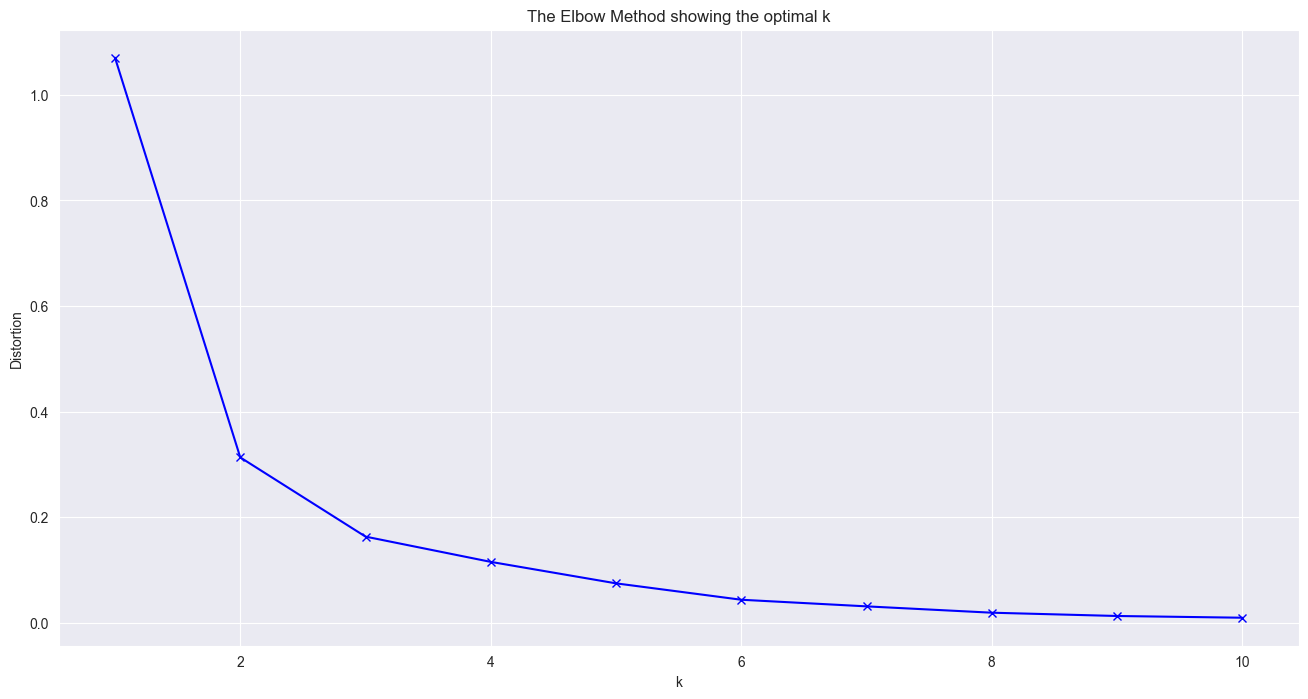

In [203]:
# Elbow method for cosine similarity
distortions = elbow_method(actual_routes_df[['cosine_similarity']].values, max_clusters=10)

### K-Means Clustering

100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


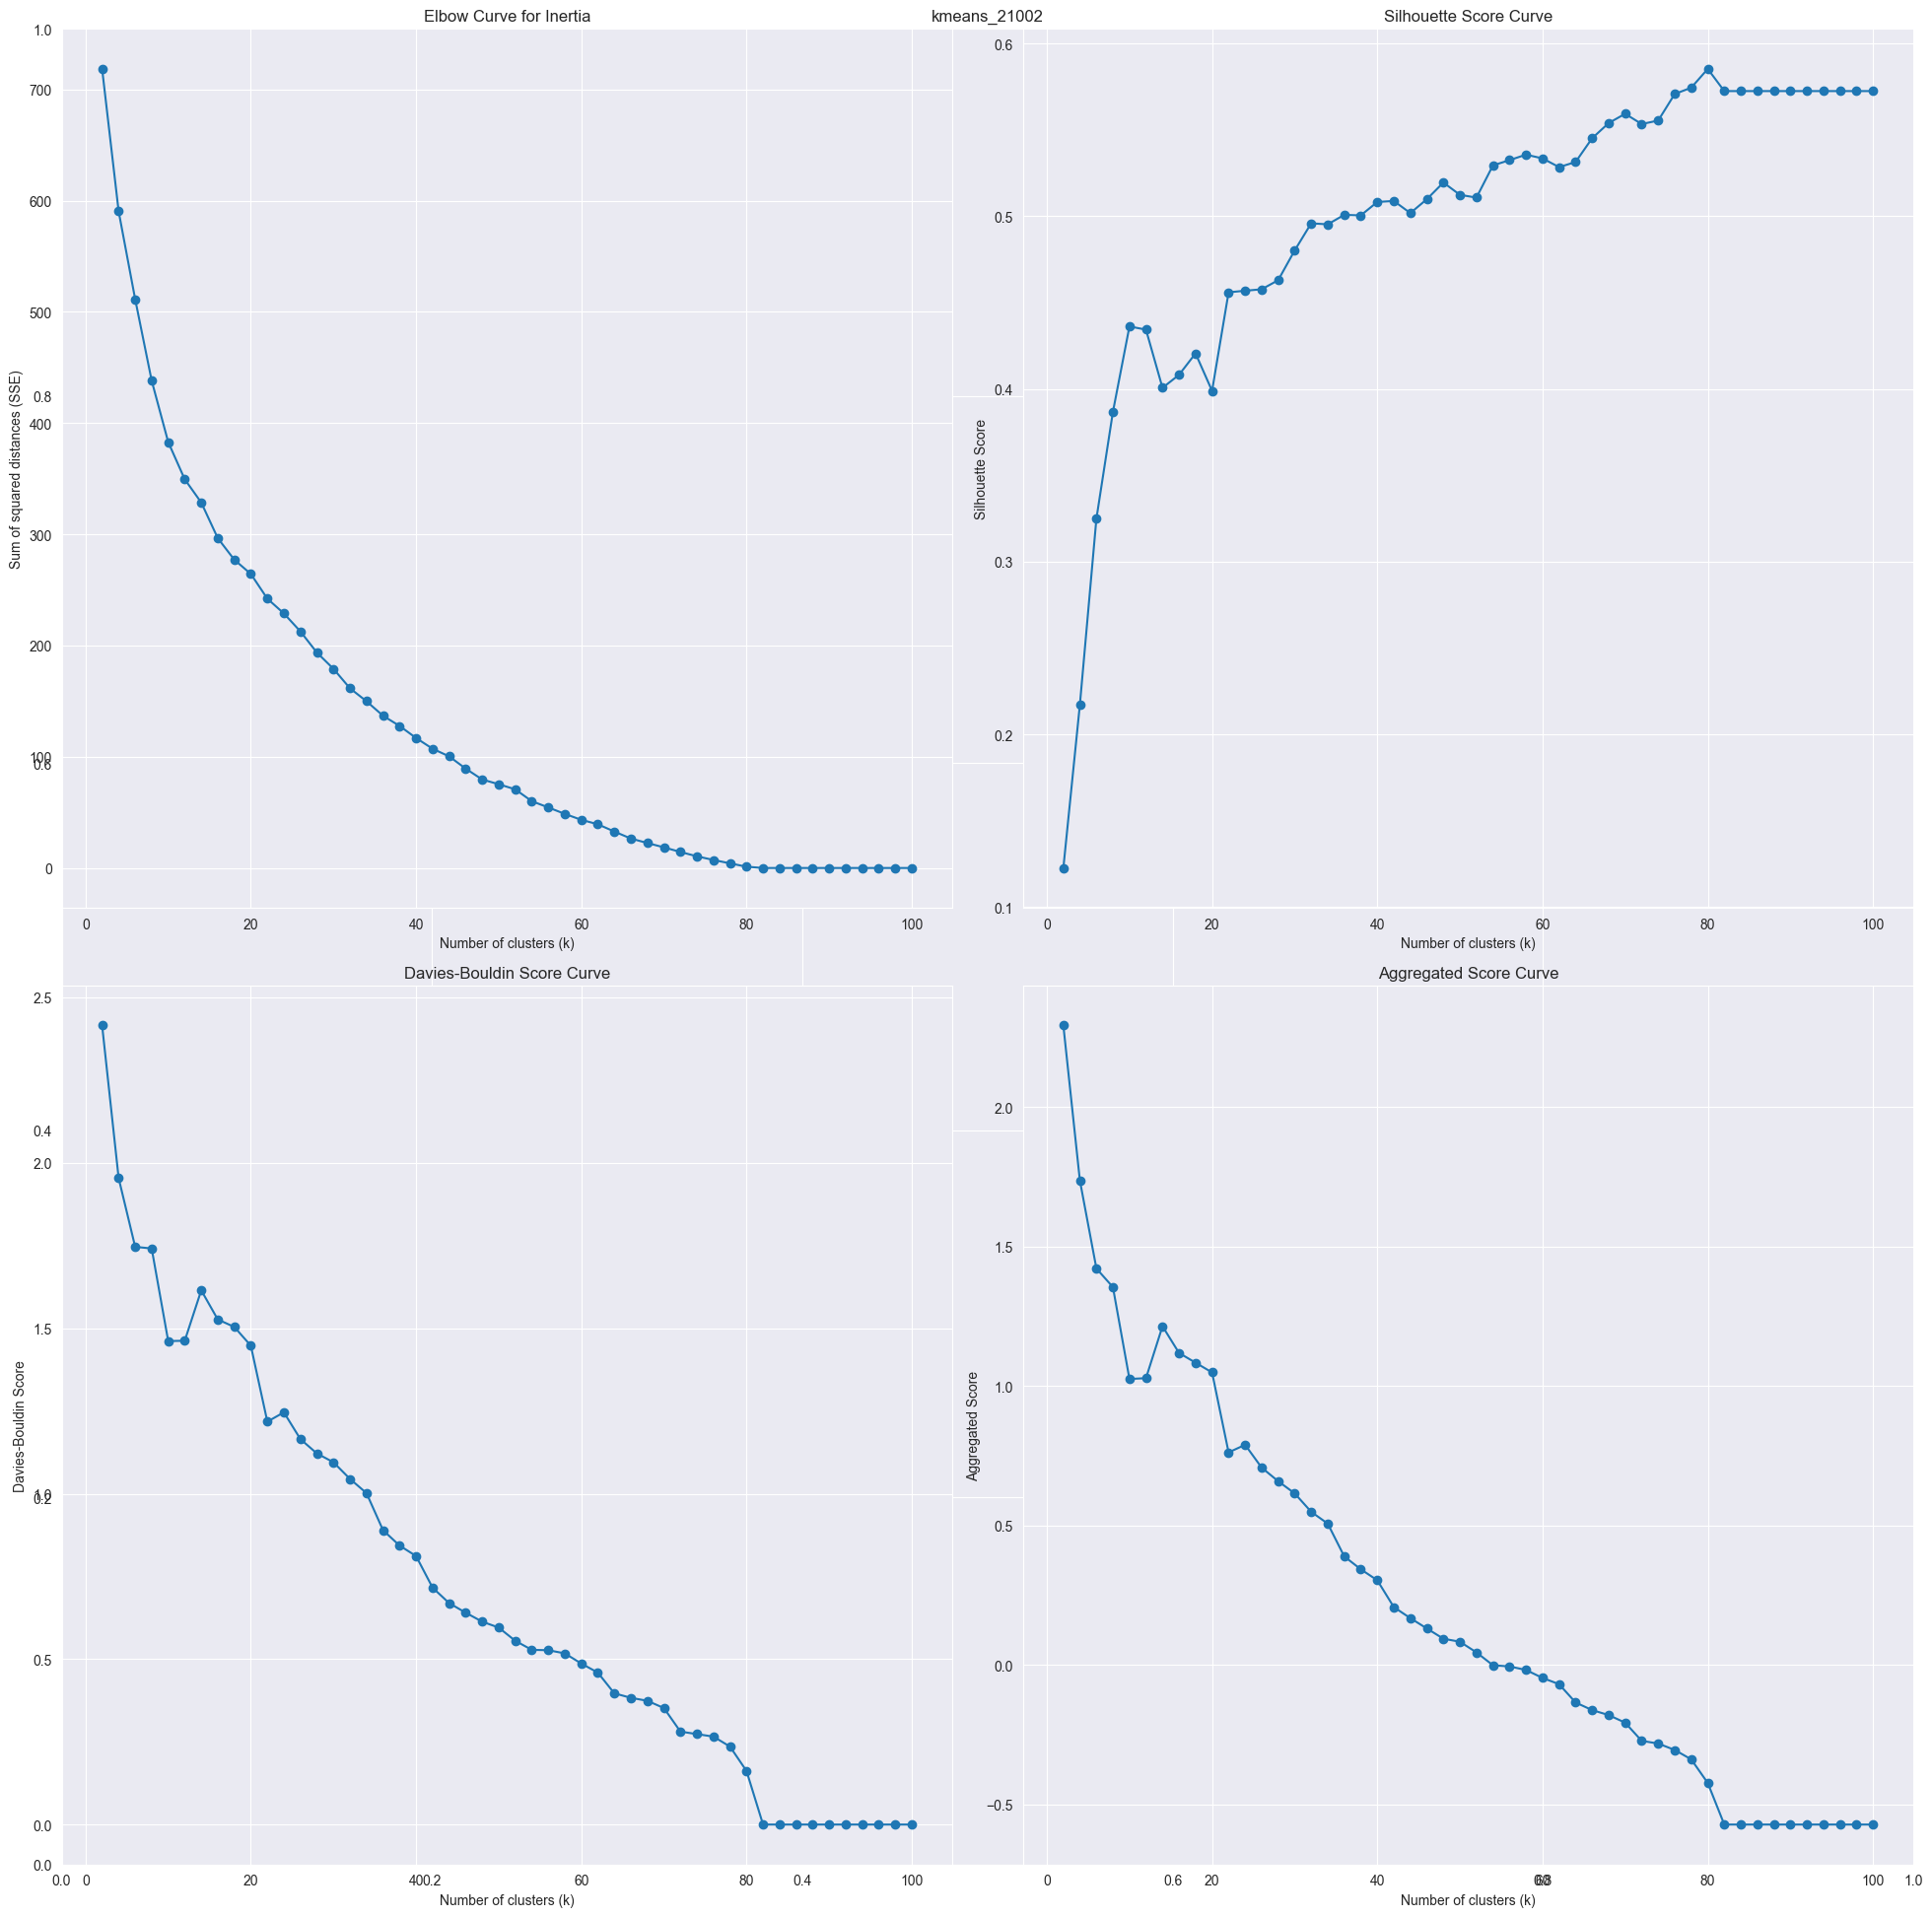

In [205]:
# Find the optimal number of clusters for K-Means
find_optimal_clusters(all_route_vectors, 'kmeans', 'Plots/kmeans_elbow.png', k_min=2, k_max=100, step=2)

100%|██████████| 8/8 [00:00<00:00, 107.90it/s]


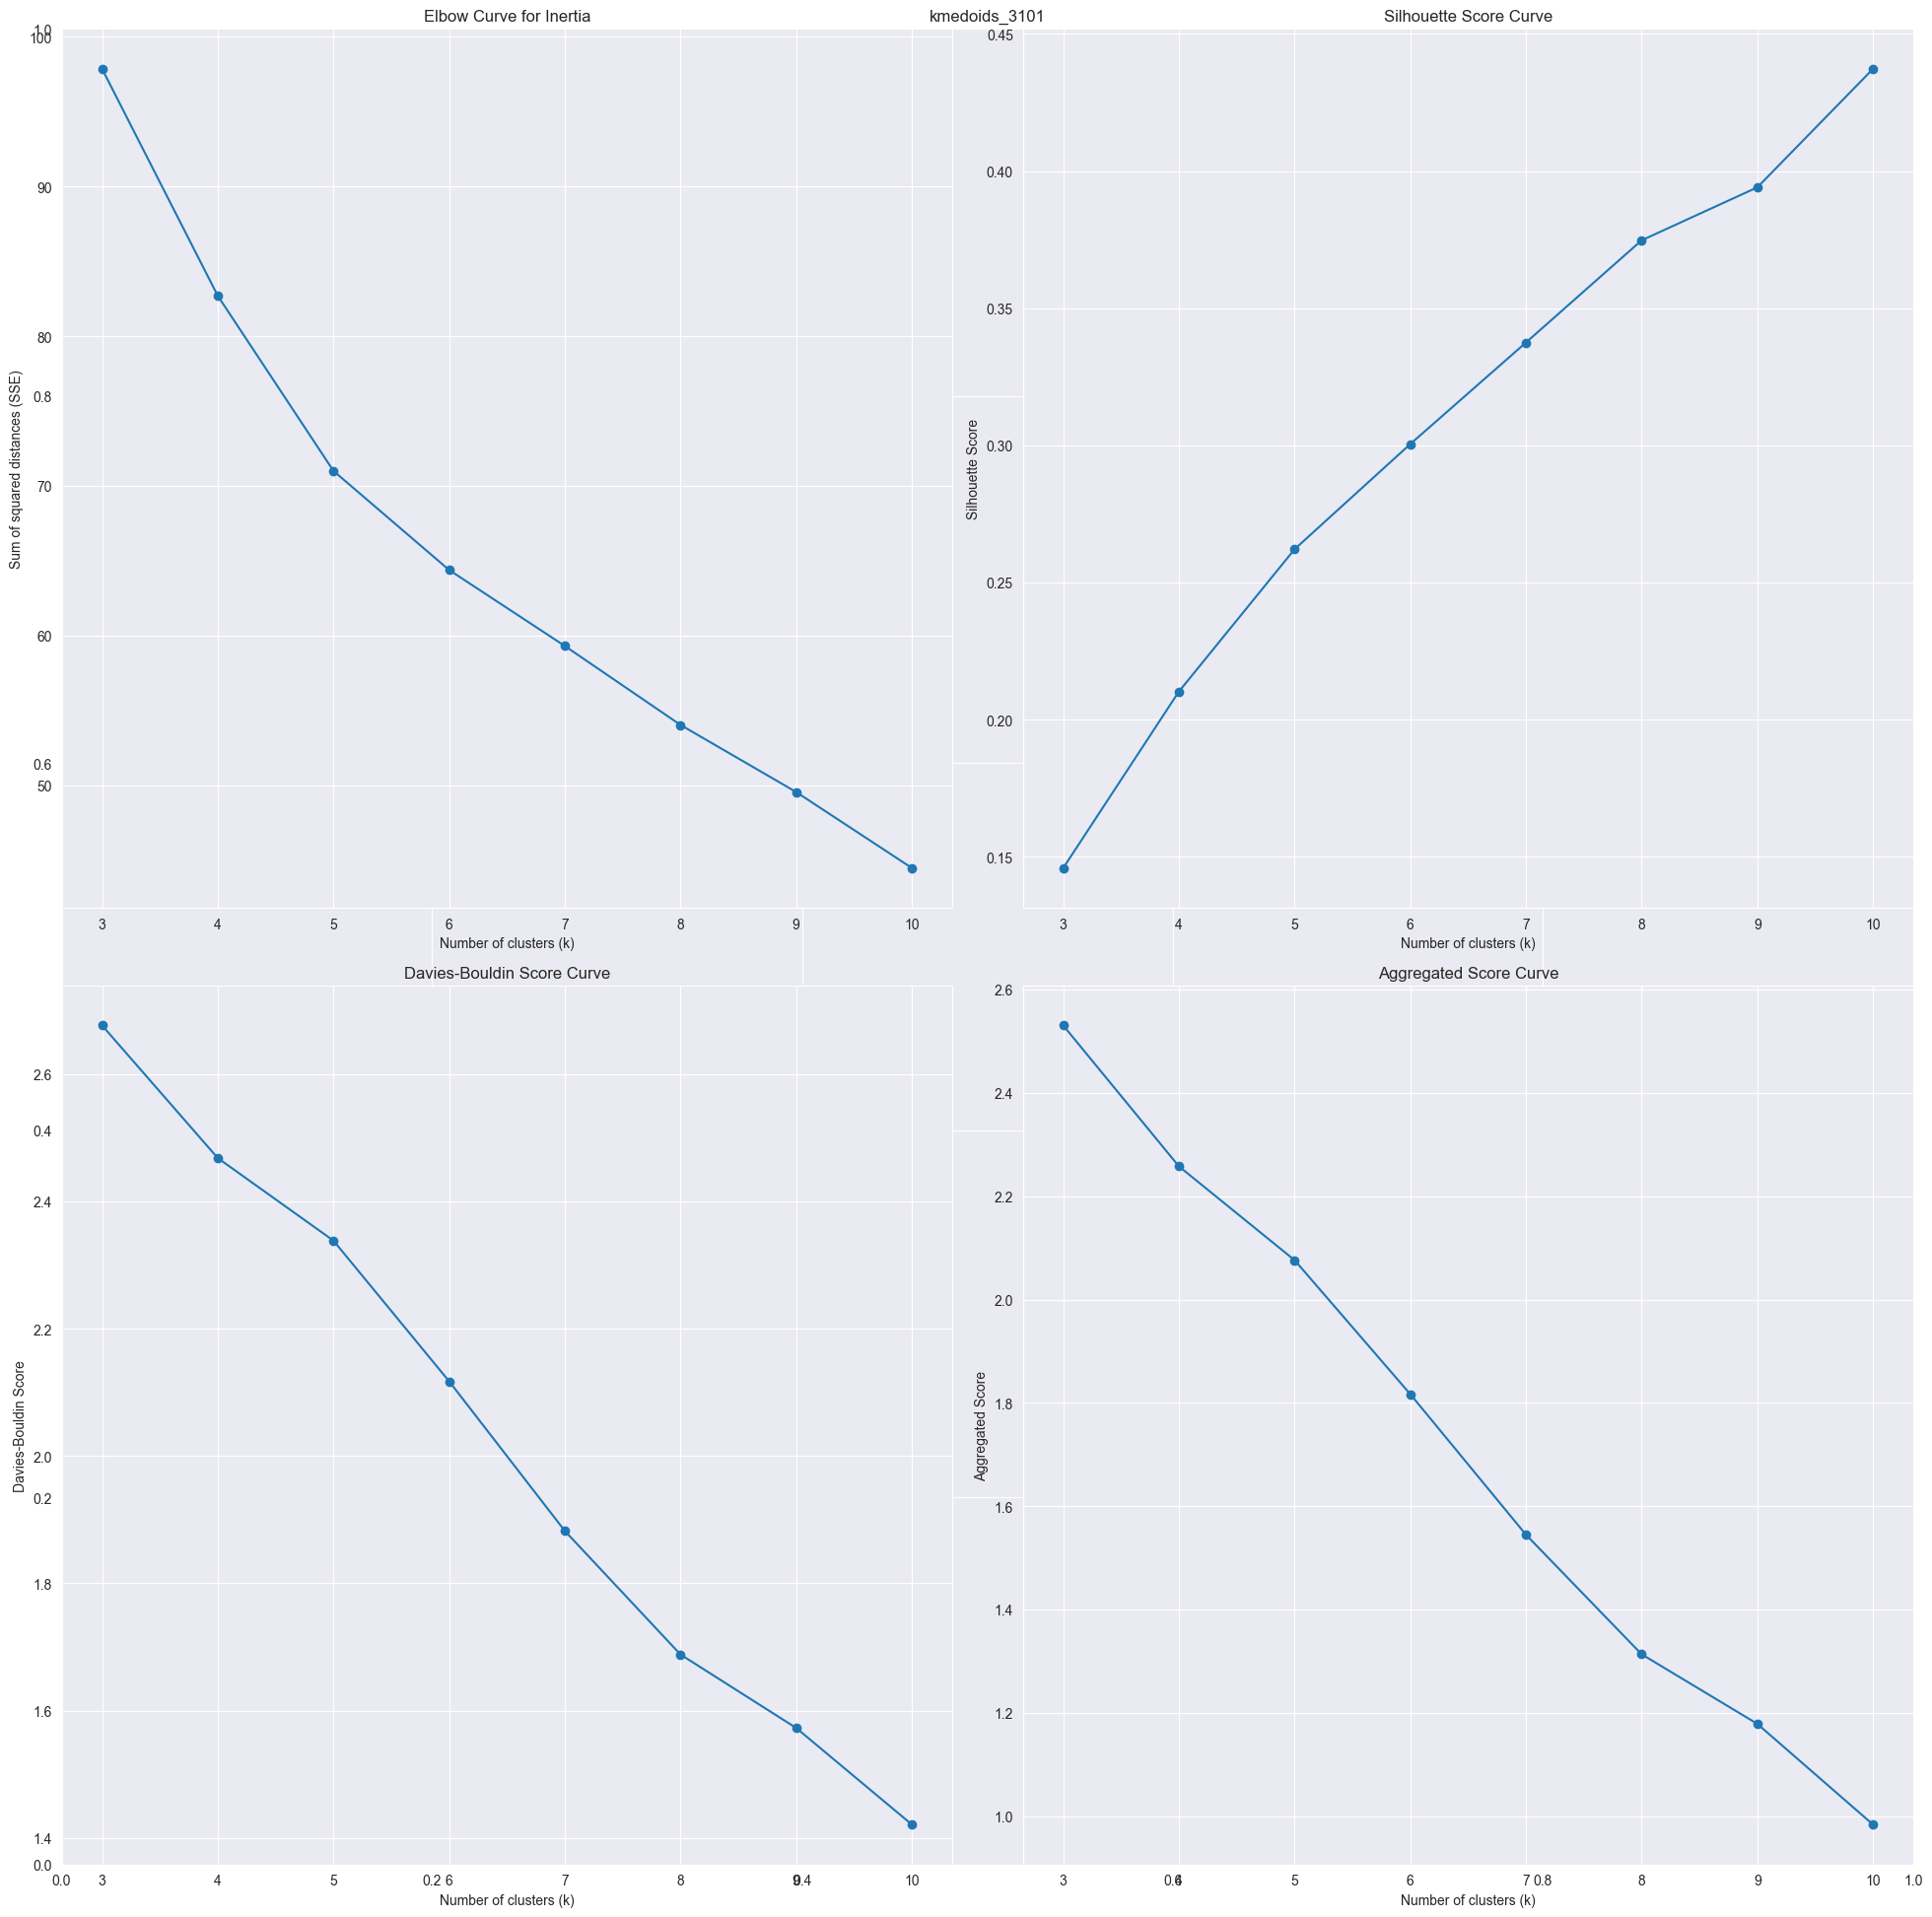

In [206]:
# Find the optimal number of clusters for K-Medoids
find_optimal_clusters(all_route_vectors, 'kmedoids', 'Plots/kmedoids_elbow.png', k_min=3, k_max=10, step=1)

In [207]:
# Common property
cluster_sizes = [50]
CLUSTERING_KEY = 'vector_f1_pca'

# KMEAN
kmeans_parameter_combinations = [
    {'n_clusters': n_clusters, 'tol': tol, 'n_init':n_init, 'init': init, 'algorithm':algorithm, 'max_iter':max_iter}
    for n_clusters in cluster_sizes
    for tol in [1e-4, 1e-5, 1e-3] # default: 1e-4
    for n_init in [10] # default:10
    for init in ['k-means++'] # default:k-means++
    for algorithm in ['lloyd'] # default:lloyd - elkan
    for max_iter in [300, 600, 900] # default:300
]

best_score_kmeans, best_config_kmeans = grid_search(all_routes_df, all_route_vectors, 'kmeans',
                                                    kmeans_parameter_combinations, plot_enabled = False)

Best score: 0 - S:0 - B:0:   0%|          | 0/9 [00:00<?, ?it/s]


Configuration 1/9


Best score: 1.36 - S:0.508 - B:0.651:  11%|█         | 1/9 [00:00<00:02,  2.86it/s]

Parameters: {'n_clusters': 50, 'tol': 0.0001, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 300}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 2/9


Best score: 1.36 - S:0.508 - B:0.651:  22%|██▏       | 2/9 [00:00<00:02,  2.77it/s]

Parameters: {'n_clusters': 50, 'tol': 0.0001, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 600}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 3/9


Best score: 1.36 - S:0.508 - B:0.651:  33%|███▎      | 3/9 [00:01<00:02,  2.70it/s]

Parameters: {'n_clusters': 50, 'tol': 0.0001, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 900}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 4/9


Best score: 1.36 - S:0.508 - B:0.651:  44%|████▍     | 4/9 [00:01<00:01,  2.67it/s]

Parameters: {'n_clusters': 50, 'tol': 1e-05, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 300}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 5/9


Best score: 1.36 - S:0.508 - B:0.651:  56%|█████▌    | 5/9 [00:01<00:01,  2.72it/s]

Parameters: {'n_clusters': 50, 'tol': 1e-05, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 600}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 6/9


Best score: 1.36 - S:0.508 - B:0.651:  67%|██████▋   | 6/9 [00:02<00:01,  2.82it/s]

Parameters: {'n_clusters': 50, 'tol': 1e-05, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 900}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 7/9


Best score: 1.36 - S:0.508 - B:0.651:  78%|███████▊  | 7/9 [00:02<00:00,  2.83it/s]

Parameters: {'n_clusters': 50, 'tol': 0.001, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 300}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 8/9


Best score: 1.36 - S:0.508 - B:0.651:  89%|████████▉ | 8/9 [00:02<00:00,  2.87it/s]

Parameters: {'n_clusters': 50, 'tol': 0.001, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 600}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845

Configuration 9/9


Best score: 1.36 - S:0.508 - B:0.651: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

Parameters: {'n_clusters': 50, 'tol': 0.001, 'n_init': 10, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 900}
Silhouette score: 0.5084806270217881
Davies-Bouldin score: 0.6506604540235845


In [208]:
# Best configurations
print(f'\n\nGrid search analysis for KMeans\nBest configuration:\n - Silhouette score: {best_score_kmeans[1]}\n - Bouldin score: {best_score_kmeans[2]}\n - Hyperparameters:')
for key, el in best_config_kmeans.items():
    print(f' -- {key} : {el}')



Grid search analysis for KMeans
Best configuration:
 - Silhouette score: 0.5084806270217881
 - Bouldin score: 0.6506604540235845
 - Hyperparameters:
 -- n_clusters : 50
 -- tol : 0.0001
 -- n_init : 10
 -- init : k-means++
 -- algorithm : lloyd
 -- max_iter : 300


In [209]:
# KMEDOIDS
kmedoids_parameter_combinations = [
    
    {'n_clusters': n_clusters,  'init':init,  'metric': metric, 'method':method, 'max_iter':max_iter}

    for n_clusters in cluster_sizes
    for init in ['k-medoids++','random','build'] # default:heuristic - random - build
    for metric in ['cosine'] # default:euclidean
    for method in ['alternate'] # default:alternate - pam (has no end)
    for max_iter in [300] # default:300
]

best_score_kmedoids, best_config_kmedoids = grid_search(all_routes_df, all_route_vectors, 'kmedoids', 
                                                        kmedoids_parameter_combinations, plot_enabled = False)


print(f'\n\nGrid search analysis for KMedoids\nBest configuration:\n - Silhouette score: {best_score_kmedoids[1]}\n - Bouldin score: {best_score_kmedoids[2]}\n - Hyperparameters:')
for key, el in best_config_kmedoids.items():
    print(f' -- {key} : {el}')

Best score: 1.357 - S:0.524 - B:0.68: 100%|██████████| 3/3 [00:00<00:00, 41.84it/s]


Configuration 1/3
Parameters: {'n_clusters': 50, 'init': 'k-medoids++', 'metric': 'cosine', 'method': 'alternate', 'max_iter': 300}
Silhouette score: 0.5238568737116623
Davies-Bouldin score: 0.679587953568959

Configuration 2/3
Parameters: {'n_clusters': 50, 'init': 'random', 'metric': 'cosine', 'method': 'alternate', 'max_iter': 300}
Silhouette score: 0.2850957640374027
Davies-Bouldin score: 1.0800165792423433

Configuration 3/3
Parameters: {'n_clusters': 50, 'init': 'build', 'metric': 'cosine', 'method': 'alternate', 'max_iter': 300}
Silhouette score: 0.5562666341951847
Davies-Bouldin score: 0.6728466377813264


Grid search analysis for KMedoids
Best configuration:
 - Silhouette score: 0.5562666341951847
 - Bouldin score: 0.6728466377813264
 - Hyperparameters:
 -- n_clusters : 50
 -- init : build
 -- metric : cosine
 -- method : alternate
 -- max_iter : 300



KMeans Parameters: {'n_clusters': 50, 'init': 'k-means++', 'tol': 0.0001, 'algorithm': 'lloyd', 'max_iter': 300}
Silhouette score: 0.5084806270217881
Davies Bouldin score: 0.6506604540235845

KMedoids Parameters: {'n_clusters': 50, 'init': 'build', 'metric': 'cosine', 'method': 'alternate', 'max_iter': 300}
Silhouette score: 0.5562666341951847
Davies Bouldin score: 0.6728466377813264


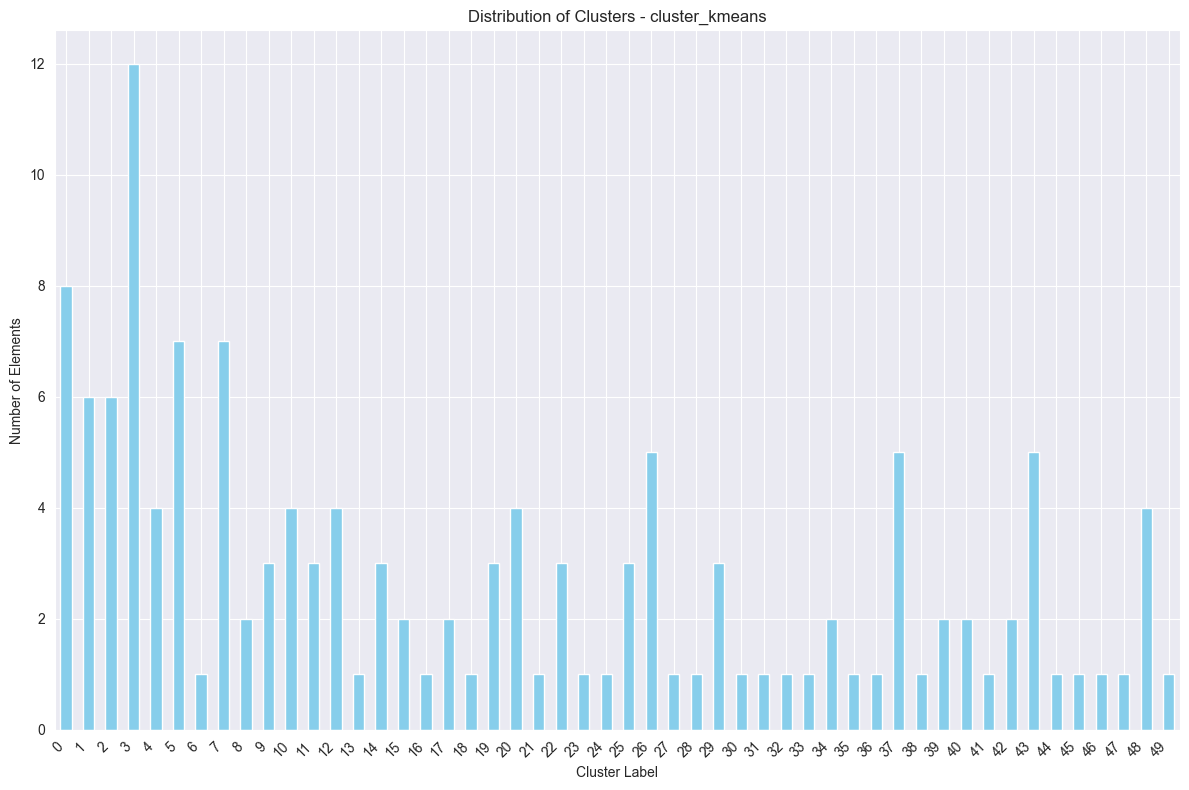

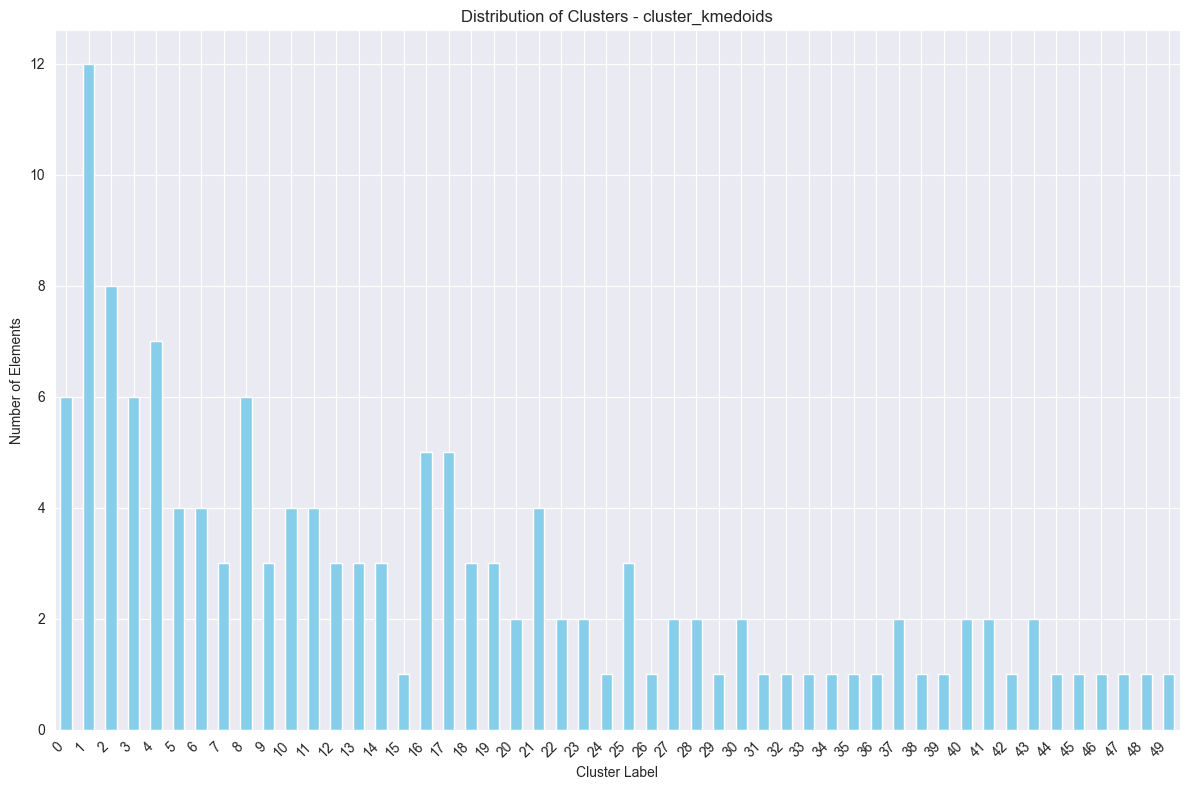

,cluster_label,num_elements,route_ids
0,15,1,[a45589]
1,8,6,"[a51467, a55002, a2952, a57605, a4806, s1]"
2,38,1,[a93801]
3,49,1,[a71048]
4,22,2,"[a29378, a23652]"
5,31,1,[a87286]
6,37,2,"[a92189, a37091]"
7,14,3,"[a96887, a47310, a51868]"
8,41,2,"[a897, s2]"
9,25,3,"[a62665, a88206, a17905]"


In [210]:
#KMEAN_CONFIGURATION = best_config_kmeans
KMEAN_CONFIGURATION = {'n_clusters': 50, 'init': 'k-means++', 'tol': 1e-4, 'algorithm':'lloyd', 'max_iter':300}

#KMEDOIDS_CONFIGURATION = best_config_kmedoids
KMEDOIDS_CONFIGURATION = {'n_clusters': 50, 'init': 'build', 'metric':'cosine', 'method':'alternate', 'max_iter':300}

kmeans_cluster_model, kmeans_silhouette, kmeans_davies_bouldin = clustering(
    all_route_vectors, KMEAN_CONFIGURATION, approach='kmeans')
kmedoids_cluster_model, kmedoids_silhouette, kmedoids_davies_bouldin = clustering(
    all_route_vectors, KMEDOIDS_CONFIGURATION, approach='kmedoids')

# set the cluster labels in the actual routes dataframe
all_routes_df['cluster_kmeans'] = kmeans_cluster_model.labels_
all_routes_df['cluster_kmedoids'] = kmedoids_cluster_model.labels_

print(f'\nKMeans Parameters: {KMEAN_CONFIGURATION}')
print(f'Silhouette score: {kmeans_silhouette}')
print(f'Davies Bouldin score: {kmeans_davies_bouldin}')

print(f'\nKMedoids Parameters: {KMEDOIDS_CONFIGURATION}')
print(f'Silhouette score: {kmedoids_silhouette}')
print(f'Davies Bouldin score: {kmedoids_davies_bouldin}')

clustering_summary(all_routes_df, cluster_column='cluster_kmeans')
clustering_summary(all_routes_df, cluster_column='cluster_kmedoids')

vectors shape:  (138, 176)


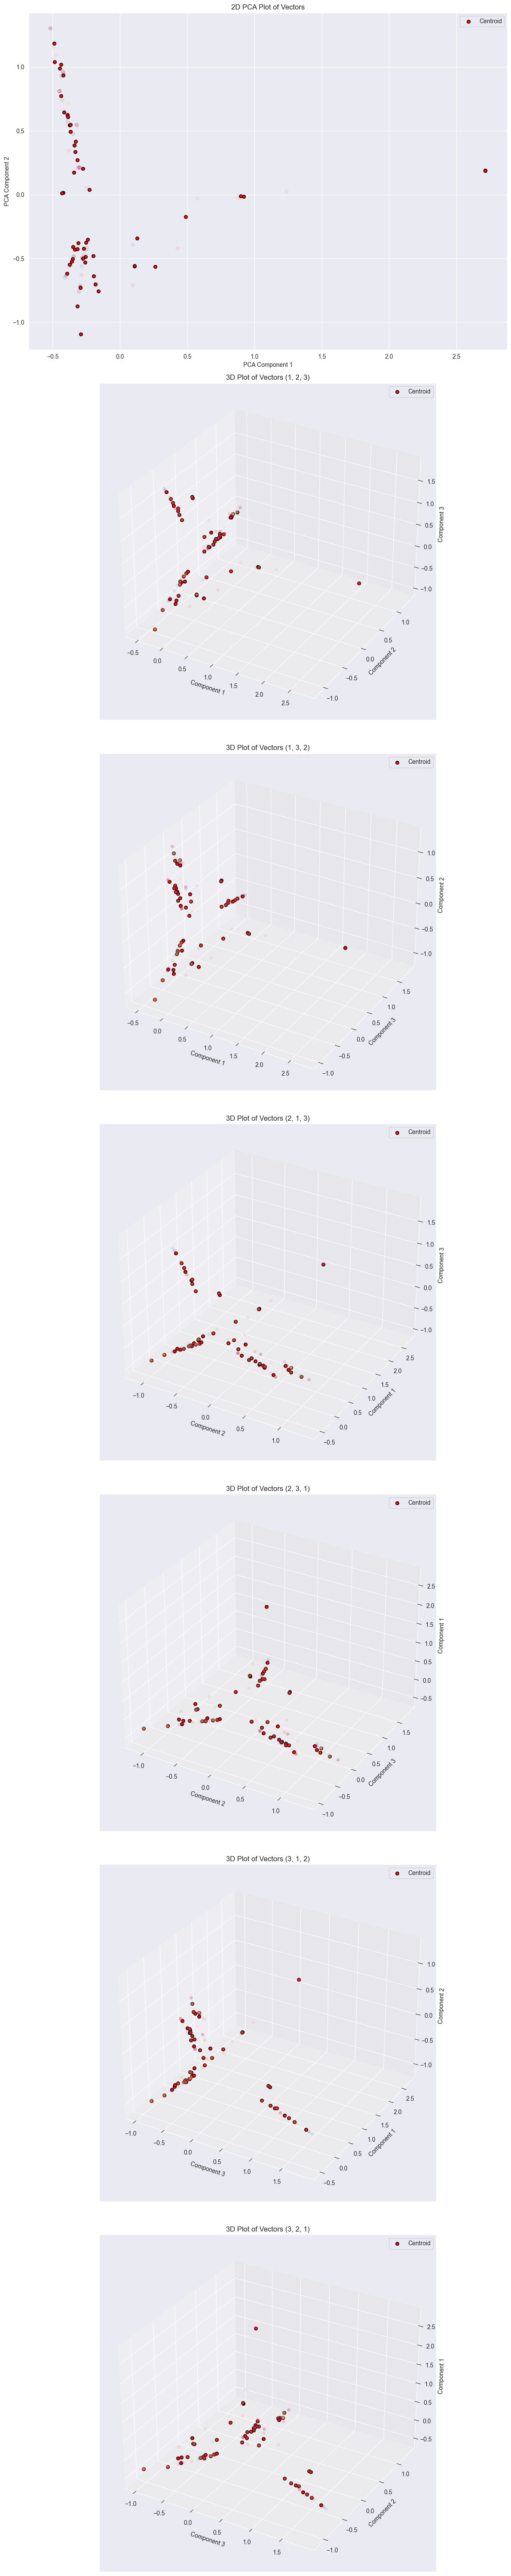

In [211]:
plot_vector_elements(all_routes_df, all_route_vectors, 'cluster_kmeans')

vectors shape:  (138, 176)


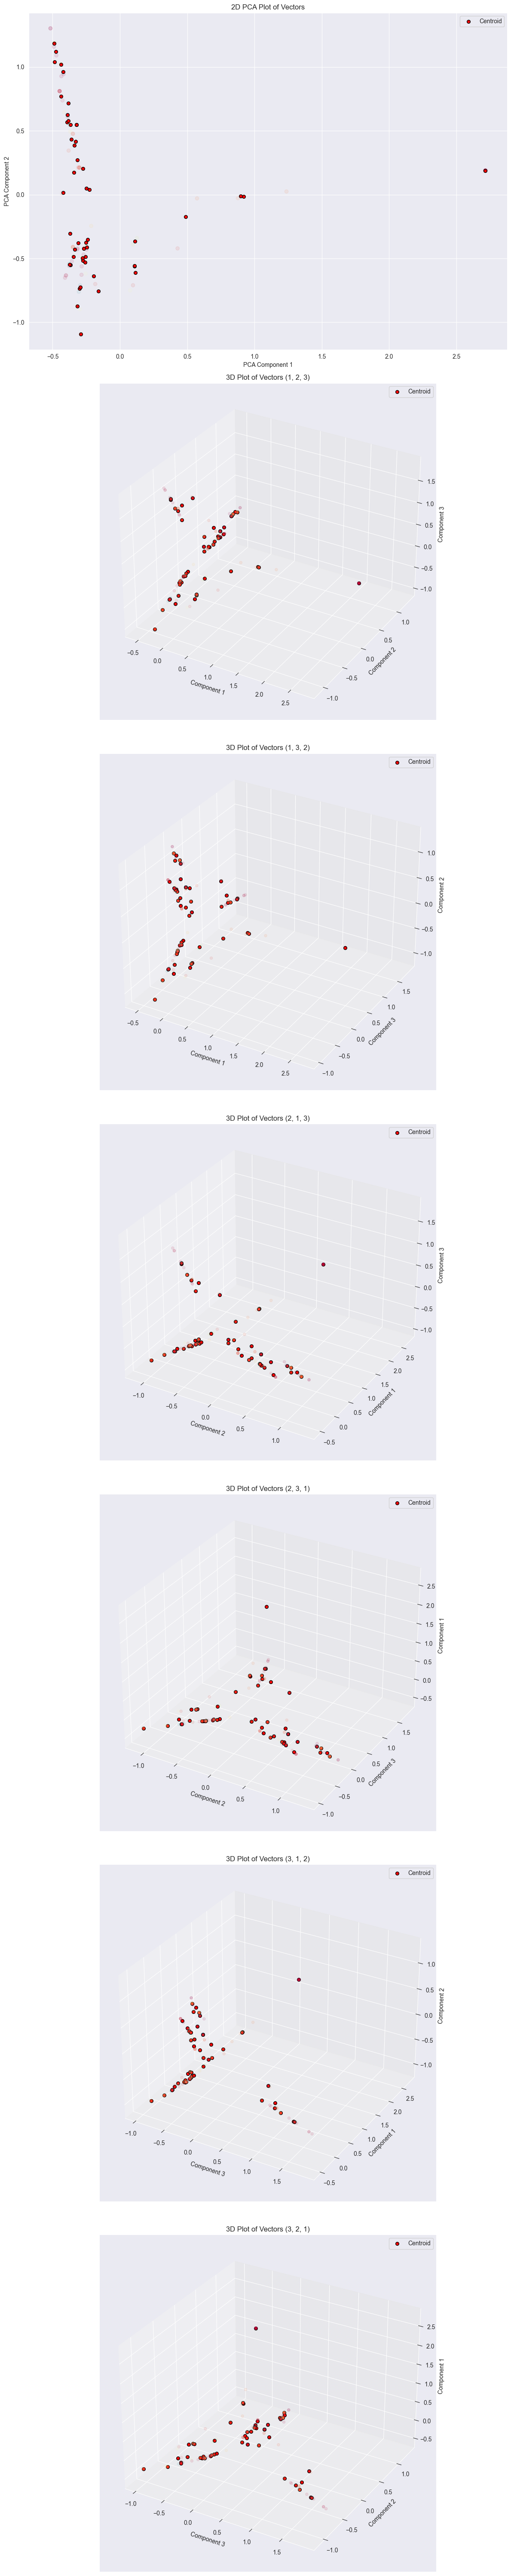

In [212]:
plot_vector_elements(all_routes_df, all_route_vectors, 'cluster_kmedoids')

In [213]:
all_routes_df.sample(10)

,id,driver,route,sroute,route_str,cosine_similarity,is_actual,cluster_kmeans,cluster_kmedoids
102,a14714,D8,"[{'from': 'Parma', 'to': 'Modena', 'merchandis...",s9,Parma-Modena Modena-Reggio_Emilia Reggio_Emili...,0.777778,True,39,2
57,a30965,D2,"[{'from': 'Pescara', 'to': 'Terni', 'merchandi...",s5,Pescara-Terni Terni-Latina Latina-Naples Naple...,0.818182,True,8,7
124,a43733,D6,"[{'from': 'Palermo', 'to': 'Salerno', 'merchan...",s10,Palermo-Salerno Salerno-Giugliano_in_Campania ...,0.714286,True,29,13
65,a27908,D10,"[{'from': 'Reggio di Calabria', 'to': 'Catania...",s6,Reggio_di_Calabria-Catania Catania-Siracusa Si...,0.730988,True,18,32
19,a51868,D1,"[{'from': 'Rome', 'to': 'Foggia', 'merchandise...",s2,Rome-Foggia Foggia-Giugliano_in_Campania Giugl...,0.817630,True,19,14
95,a1157,D8,"[{'from': 'Parma', 'to': 'Piacenza', 'merchand...",s9,Parma-Piacenza Piacenza-Modena Modena-Reggio_E...,0.832050,True,9,10
67,a72572,D5,"[{'from': 'Siracusa', 'to': 'Cagliari', 'merch...",s7,Siracusa-Cagliari Cagliari-Palermo Palermo-Sir...,0.795472,True,3,1
9,a87286,D4,"[{'from': 'Brescia', 'to': 'Bergamo', 'merchan...",s1,Brescia-Bergamo Bergamo-Monza Monza-Parma Parm...,0.509175,True,16,31
108,a30905,D8,"[{'from': 'Parma', 'to': 'Modena', 'merchandis...",s9,Parma-Modena Modena-Reggio_Emilia Reggio_Emili...,1.000000,True,48,2
117,a26523,D6,"[{'from': 'Palermo', 'to': 'Salerno', 'merchan...",s10,Palermo-Salerno Salerno-Giugliano_in_Campania ...,0.928571,True,5,21


### Generating Standard Routes from Clusters

In [214]:
# Clustering - Generate new standard route from centroids and medoids. The new standard route with medoids corresponds to some actual routes.
def create_new_routes(df, column_name, cluster_label):
    """
    Creates new routes for each cluster based on the average vector representations in the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the cluster data.
        column_name (str): The name of the column containing the vector representations of routes.
        cluster_label (str): The name of the column containing the cluster labels.
        
    Returns:
        list: A list of dictionaries, each representing a new route for a cluster.

    The function iterates over each cluster, calculates the mean vector for the routes in that cluster.
    For each mean vector constructs a new route by identifying the most significant city pairs and merchandise for each trip rapresented in the mean vector.
    The merchandise vector's part is decoded using transform_values() function above.
    """
    new_routes = []
    
    city_encoded_length = len(vocabulary.city2id)
    merch_encoded_length = len(vocabulary.merchandise2id)
    trip_vector_len = city_encoded_length + merch_encoded_length
    max_trip = vocabulary.max_trip

    # Iterate over each unique cluster
    for cluster in df[cluster_label].unique():
        # Calculate the mean vector for the routes in the cluster
        mean_vector = df[df[cluster_label] == cluster][column_name].mean()
        trips = []
        previous_start_index = -1

        # Construct each trip in the route
        for trip in range(max_trip):
            low_limit = trip * trip_vector_len
            trip_upper_limit = (trip + 1) * trip_vector_len

            # Initialize variables to find starting and ending cities
            city_start_max_v = 0
            city_start_max_v_index = 0 if previous_start_index == -1 else previous_start_index
            city_end_max_v = 0
            city_end_max_v_index = 0

            # Iterate over city segment of the mean vector
            for i, cell in enumerate(mean_vector[low_limit : trip_upper_limit - merch_encoded_length]):
                if cell != 0 and i < city_encoded_length:
                    if previous_start_index == -1 and cell > city_start_max_v:
                        city_start_max_v = cell
                        city_start_max_v_index = i
                    elif cell > city_end_max_v:
                        city_end_max_v = cell
                        city_end_max_v_index = i

            # Break if the start and end cities are the same
            if city_start_max_v_index == city_end_max_v_index:
                break

            # Process merchandise segment of the mean vector
            merch_decoded_vector = transform_values(mean_vector[trip_upper_limit - merch_encoded_length  : trip_upper_limit], vocabulary)
            merchandise = {}
            for i, cell in enumerate(merch_decoded_vector):
                if cell != 0:
                    merchandise[vocabulary.id2merchandise[i]] = cell

            # Create a trip if merchandise is found
            if merchandise:
                trip = {
                    'from' : vocabulary.id2city.get(city_start_max_v_index),
                    'to' : vocabulary.id2city.get(city_end_max_v_index),
                    'merchandise' : merchandise
                }
                previous_start_index = city_end_max_v_index
                trips.append(trip)

        # Add the constructed route for the cluster
        new_routes.append({
            'id' : f's{cluster}',
            'route': trips
        })

    return new_routes

In [215]:
# Create new standard routes from the clusters
def format_route(city_pairs_):
    route_ = []
    for pair in city_pairs_:
        from_city, to_city = pair.split('-')
        # Note: The merchandise part is not handled here as it's not clear how to reconstruct it from city pairs
        trip = {
            "from": from_city,
            "to": to_city,
            "merchandise": {}  # Placeholder, adjust based on your data specifics
        }
        route_.append(trip)
    return {"route": route_}

In [216]:
def create_standard_routes_from_clusters(cluster_model, vectorizer_, num_clusters):
    new_standard_routes_ = []

    # Get feature names and filter out non-pair features
    feature_names = vectorizer_.get_feature_names_out()
    city_pair_features = [f for f in feature_names if '-' in f]

    for i in range(num_clusters):
        center = cluster_model.cluster_centers_[i]
        # Round the center values and convert to integer for frequency count
        center_rounded = np.round(center).astype(int)

        # Reverse map to city pairs
        city_pairs = [city_pair_features[j] for j in range(len(city_pair_features)) if center_rounded[j] > 0]

        # Create a standard route format from city pairs
        new_route = format_route(city_pairs)
        new_standard_routes_.append(new_route)

    return new_standard_routes_

In [217]:
def create_connected_route(city_pairs):
    # Example function to create a connected route from a list of city pairs
    # This is a simplistic approach and may need enhancements

    if not city_pairs:
        return []

    # Find potential starting points (cities that only appear as 'from')
    all_cities = [city for pair in city_pairs for city in pair.split('-')]
    start_cities = set([pair.split('-')[0] for pair in city_pairs])
    end_cities = set([pair.split('-')[1] for pair in city_pairs])
    potential_starts = list(start_cities - end_cities)
    print(f"Potential starting cities: {potential_starts}")

    # Start from a potential starting city or the first city pair
    if potential_starts:
        current_city = potential_starts[0]
    else:
        current_city = city_pairs[0].split('-')[0]

    connected_route = []
    while city_pairs:
        for i, pair in enumerate(city_pairs):
            if pair.startswith(current_city):
                connected_route.append(pair)
                _, current_city = pair.split('-')
                city_pairs.pop(i)
                break
        else:
            # No connected trip found, break the loop
            break
            
    return connected_route

In [218]:
def extract_city_pairs_from_centroid(centroid, vectorizer):
    # Assuming the centroid is a dense array of feature importances
    # and vectorizer is your TfidfVectorizer or CountVectorizer
    feature_names = vectorizer.get_feature_names_out()
    significant_features = [feature_names[i] for i in range(len(centroid)) if centroid[i] > 0]
    return significant_features

# Extract city pairs for each cluster and create routes
for i in range(kmeans_cluster_model.n_clusters):
    centroid = kmeans_cluster_model.cluster_centers_[i]
    city_pairs = extract_city_pairs_from_centroid(centroid, vectorizer)
    connected_route = create_connected_route(city_pairs)
    print(f"Cluster {i}: {connected_route}")

Potential starting cities: ['milan', 'parma', 'genoa']
Cluster 0: ['milan-piacenza', 'piacenza-reggio_emilia', 'reggio_emilia-bologna', 'bologna-ferrara']
Potential starting cities: ['foggia']
Cluster 1: ['foggia-giugliano_in_campania', 'giugliano_in_campania-latina', 'latina-salerno', 'salerno-pescara', 'pescara-ancona']
Potential starting cities: ['verona']
Cluster 2: ['verona-brescia', 'brescia-monza', 'monza-novara', 'novara-genoa', 'genoa-piacenza']
Potential starting cities: []
Cluster 3: ['bari-salerno', 'salerno-latina']
Potential starting cities: ['parma']
Cluster 4: ['parma-bologna', 'bologna-modena', 'modena-reggio_emilia', 'reggio_emilia-verona', 'verona-padova', 'padova-vicenza']
Potential starting cities: ['palermo']
Cluster 5: ['palermo-salerno', 'salerno-giugliano_in_campania', 'giugliano_in_campania-latina', 'latina-naples', 'naples-terni']
Potential starting cities: ['brescia']
Cluster 6: ['brescia-milan', 'milan-monza', 'monza-turin', 'turin-genoa', 'genoa-piacenza']

In [149]:
# Assuming 'kmeans_cluster_model' is your KMeans model and 'vectorizer' is your CountVectorizer instance
num_clusters = kmeans_cluster_model.n_clusters
new_standard_routes = create_standard_routes_from_clusters(kmeans_cluster_model, vectorizer, num_clusters)

In [151]:
len(new_standard_routes)

50

In [153]:
new_standard_routes[0]

{'route': [{'from': 'foggia', 'to': 'rome', 'merchandise': {}},
  {'from': 'latina', 'to': 'salerno', 'merchandise': {}},
  {'from': 'pescara', 'to': 'ancona', 'merchandise': {}},
  {'from': 'rome', 'to': 'latina', 'merchandise': {}},
  {'from': 'salerno', 'to': 'pescara', 'merchandise': {}}]}

In [154]:
from itertools import chain

In [157]:
# Calculate max_trip
max_trip = all_routes_df['route'].apply(len).max()

# Calculate max_qty
max_qty = max(
    qty for route in all_routes_df['route'] 
    for leg in route 
    for qty in leg['merchandise'].values()
)

# Generate city and merchandise mappings
all_cities = set(chain.from_iterable(
    [leg['from'], leg['to']] for route in all_routes_df['route'] for leg in route
))
city_to_id = {city: idx for idx, city in enumerate(sorted(all_cities))}
id_to_city = {idx: city for city, idx in city_to_id.items()}

all_merchandise = set(chain.from_iterable(
    leg['merchandise'].keys() for route in all_routes_df['route'] for leg in route
))
merchandise_to_id = {merch: idx for idx, merch in enumerate(sorted(all_merchandise))}
id_to_merchandise = {idx: merch for merch, idx in merchandise_to_id.items()}

# Now you have your constants
print(f"Max trip: {max_trip}, Max quantity: {max_qty}")
print("City to ID:", city_to_id)
print("ID to City:", id_to_city)
print("Merchandise to ID:", merchandise_to_id)
print("ID to Merchandise:", id_to_merchandise)

Max trip: 10, Max quantity: 50
City to ID: {'Ancona': 0, 'Bari': 1, 'Bergamo': 2, 'Bologna': 3, 'Brescia': 4, 'Cagliari': 5, 'Catania': 6, 'Ferrara': 7, 'Foggia': 8, 'Forlì': 9, 'Genoa': 10, 'Giugliano in Campania': 11, 'Latina': 12, 'Messina': 13, 'Milan': 14, 'Modena': 15, 'Monza': 16, 'Naples': 17, 'Novara': 18, 'Padova': 19, 'Palermo': 20, 'Parma': 21, 'Perugia': 22, 'Pescara': 23, 'Piacenza': 24, 'Prato': 25, 'Reggio Emilia': 26, 'Reggio di Calabria': 27, 'Rimini': 28, 'Rome': 29, 'Salerno': 30, 'Siracusa': 31, 'Taranto': 32, 'Terni': 33, 'Trento': 34, 'Turin': 35, 'Venice': 36, 'Verona': 37, 'Vicenza': 38}
ID to City: {0: 'Ancona', 1: 'Bari', 2: 'Bergamo', 3: 'Bologna', 4: 'Brescia', 5: 'Cagliari', 6: 'Catania', 7: 'Ferrara', 8: 'Foggia', 9: 'Forlì', 10: 'Genoa', 11: 'Giugliano in Campania', 12: 'Latina', 13: 'Messina', 14: 'Milan', 15: 'Modena', 16: 'Monza', 17: 'Naples', 18: 'Novara', 19: 'Padova', 20: 'Palermo', 21: 'Parma', 22: 'Perugia', 23: 'Pescara', 24: 'Piacenza', 25: 'P

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def transform_values(values, max_qty):
    values = values * max_qty
    values = np.where(values < 1, 0, values)
    return np.round(values).astype(int)


def create_new_routes(df, column_name, cluster_label, max_trip, city_to_id, id_to_city, merchandise_to_id, id_to_merchandise):
    new_routes = []
    city_encoded_length = len(city_to_id)
    merch_encoded_length = len(merchandise_to_id)
    trip_vector_len = city_encoded_length + merch_encoded_length

    for cluster in df[cluster_label].unique():
        mean_vector = df[df[cluster_label] == cluster][column_name].mean()
        trips = []
        previous_start_index = -1

        for trip in range(max_trip):
            low_limit = trip * trip_vector_len
            trip_upper_limit = (trip + 1) * trip_vector_len
            city_start_max_v, city_end_max_v = 0, 0
            city_start_max_v_index, city_end_max_v_index = 0 if previous_start_index == -1 else previous_start_index, 0

            for i, cell in enumerate(mean_vector[low_limit : trip_upper_limit - merch_encoded_length]):
                if cell > city_start_max_v and i < city_encoded_length:
                    city_start_max_v = cell
                    city_start_max_v_index = i
                if cell > city_end_max_v:
                    city_end_max_v = cell
                    city_end_max_v_index = i

            if city_start_max_v_index == city_end_max_v_index:
                break

            merch_decoded_vector = transform_values(mean_vector[trip_upper_limit - merch_encoded_length : trip_upper_limit], max_qty)
            merchandise = {id_to_merchandise[i]: cell for i, cell in enumerate(merch_decoded_vector) if cell != 0}

            if merchandise:
                trip = {
                    'from': id_to_city[city_start_max_v_index],
                    'to': id_to_city[city_end_max_v_index],
                    'merchandise': merchandise
                }
                previous_start_index = city_end_max_v_index
                trips.append(trip)

        new_routes.append({
            'id': f's{cluster}',
            'route': trips
        })

    return new_routes

# Perform clustering (assuming clustering is already done)
# kmeans_cluster_model = KMeans(...).fit(...)

# Create new standard routes
new_standard_routes = create_new_routes(all_routes_df, 'vector', 'cluster_kmeans', max_trip, city_to_id, id_to_city, merchandise_to_id, id_to_merchandise)

# new_standard_routes now contains the newly generated standard routes


In [168]:
def transform_values(values, max_qty):
    # Re-normalize and round the values
    return np.round(values * max_qty).astype(int)

def decode_vector_to_route(mean_vector, max_trip, city_to_id, id_to_city, merchandise_to_id, id_to_merchandise):
    new_route = []
    trip_vector_len = len(city_to_id) + len(merchandise_to_id)
    for trip_index in range(max_trip):
        # Extract the relevant segment of the mean vector for this trip
        trip_vector = mean_vector[trip_index * trip_vector_len : (trip_index + 1) * trip_vector_len]

        # Decode cities
        cities_vector = trip_vector[:len(city_to_id)]
        trip_cities = np.argsort(-cities_vector)[:2]  # Get indices of top 2 cities
        
        print('Length of city_to_id: ', len(trip_cities))
        try:
            print('trip_cities[0]: ', trip_cities[0])
            print('trip_cities[1]: ', trip_cities[1])
        except:
            pass
        
        # Skip if not enough cities are found
        if len(trip_cities) < 2 or trip_cities[0] not in id_to_city or trip_cities[1] not in id_to_city:
            print("Not enough cities found")
            continue

        from_city = id_to_city[trip_cities[0]]
        to_city = id_to_city[trip_cities[1]]
        print(f"From city: {from_city}, To city: {to_city}")

        # Skip if from and to cities are same
        if from_city == to_city:
            continue

        trip = {"from": from_city, "to": to_city, "merchandise": {}}
        new_route.append(trip)

    return {"route": new_route}

def create_standard_routes_from_clusters(df, vectors, cluster_label, max_trip, city_to_id, id_to_city, merchandise_to_id, id_to_merchandise):
    new_standard_routes = []

    for cluster in df[cluster_label].unique():
        print(f"Processing cluster {cluster}")
        # Calculate the mean vector for the cluster
        cluster_vectors = vectors[np.where(df[cluster_label] == cluster)[0], :]
        mean_vector = cluster_vectors.mean(axis=0)

        # Convert to dense array if it's a sparse matrix
        if hasattr(mean_vector, "toarray"):
            mean_vector = mean_vector.toarray()

        # Flatten the vector
        mean_vector = mean_vector.flatten()

        # Decode the mean vector into a route
        new_route = decode_vector_to_route(mean_vector, max_trip, city_to_id, id_to_city, merchandise_to_id, id_to_merchandise)
        new_standard_routes.append(new_route)

    return new_standard_routes

# Generate new standard routes from the clusters
new_standard_routes_kmeans = create_standard_routes_from_clusters(
    all_routes_df, 
    all_route_vectors, 
    'cluster_kmeans', 
    max_trip, 
    city_to_id, 
    id_to_city, 
    merchandise_to_id, 
    id_to_merchandise
)

# Example: Print the first new standard route
print(new_standard_routes_kmeans[0])

Processing cluster 36
Length of city_to_id:  1
trip_cities[0]:  [[ 89  48   9 166 167  79  24 128 112 113 114 115 116 117 124 123 120 111
  121 122 127 126 125 119 118 108 109  91  92  93  94  95  96  97  98  99
  100 101 102 103 104 105 106 107 110 129   0 131 154 155 156 157 158 159
  160 161 153 162 164 165 168 169 170 171 172 173 163 130 152 150  90 133
  134 135 136 137 138 139 151 140 142 143 144 145 146 147 148 149 141 132
   87 174  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
   41  23  22  21  20   1   2   3   4   5   6   7   8  42  10  12  13  14
   15  16  17  18  19  11  88  43  45  69  70  71  72  73  74  75  76  77
   78  80  81  82  83  84  85  86  68  67  66  65  46  47  49  50  51  52
   53  54  44  55  57  58  59  60  61  62  63  64  56 175]]
Not enough cities found
Length of city_to_id:  0
Not enough cities found
Length of city_to_id:  0
Not enough cities found
Length of city_to_id:  0
Not enough cities found
Length of city_to_id:  0
Not enough cit

## Old Code for Clustering and Deviation Analysis

In [ ]:
# Analyzing the resulting kmeans clusters
cluster_analysis = actual_routes_df.groupby('cluster').agg({'cosine_similarity': ['mean', 'min', 'max', 'count']})
cluster_analysis

In [ ]:
# Analyzing the resulting kmedoids clusters
kmedoids_cluster_analysis = actual_routes_df.groupby('kMedoids_cluster').agg({'cosine_similarity': ['mean', 'min', 'max', 'count']})
kmedoids_cluster_analysis

In [ ]:
# Plotting the kmeans clusters
plt.figure(figsize=(16,8))
plt.scatter(actual_routes_df['cosine_similarity'], actual_routes_df['cluster'], c=actual_routes_df['cluster'])
plt.xlabel('Cosine Similarity')
plt.ylabel('Cluster')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
# Plotting the kmedoids clusters
plt.figure(figsize=(16,8))
plt.scatter(actual_routes_df['cosine_similarity'], actual_routes_df['kMedoids_cluster'], c=actual_routes_df['kMedoids_cluster'])
plt.xlabel('Cosine Similarity')
plt.ylabel('Cluster')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
# Function to extract route segments as a list
def extract_route_segments(route):
    """
    Extract route segments as a list.
    :param route: A route
    :return: list of route segments
    """
    return [f"{leg['from']}-{leg['to']}" for leg in route]

In [ ]:
# Extracting route segments for standard routes
standard_routes_df['route_segments'] = standard_routes_df['route'].apply(extract_route_segments)
standard_route_segments = standard_routes_df.set_index('id')['route_segments'].to_dict()

In [ ]:

# Analyzing deviations for Cluster 0 and Cluster 2
deviation_analysis = {
    'cluster': [],
    'actual_route_id': [],
    'standard_route_id': [],
    'deviated_segments': []
}

for cluster in [0, 2]:
    cluster_routes = actual_routes_df[actual_routes_df['cluster'] == cluster]
    for _, row in cluster_routes.iterrows():
        standard_segments = set(standard_route_segments.get(row['sroute'], []))
        actual_segments = set(extract_route_segments(row['route']))
        
        # Identifying deviated segments
        deviations = actual_segments.symmetric_difference(standard_segments)
        
        deviation_analysis['cluster'].append(cluster)
        deviation_analysis['actual_route_id'].append(row['id'])
        deviation_analysis['standard_route_id'].append(row['sroute'])
        deviation_analysis['deviated_segments'].append(list(deviations))

# Convert the analysis into a DataFrame for better visualization
deviation_analysis_df = pd.DataFrame(deviation_analysis)
deviation_analysis_df.head()

In [ ]:
# create a deviation analysis csv file
deviation_analysis_df.to_csv('Dataset/deviation_analysis.csv')

In [ ]:
# Function to calculate the number of deviations
def calculate_deviations(deviations):
    """
    Calculate the number of deviations.
    
    :param deviations: list of deviations
    :return: number of deviations
    """
    return len(deviations)

# Function to calculate the number of deviations
def calculate_deviations_percentage(deviations):
    """
    Calculate the percentage of deviations.
    
    :param deviations: list of deviations
    :return: percentage of deviations
    """
    return len(deviations) / 10 * 100

# Function to calculate the number of deviations
def calculate_deviations_percentage_per_segment(deviations):
    """
    Calculate the percentage of deviations per segment.
    
    :param deviations: list of deviations
    :return: percentage of deviations per segment
    """
    return len(deviations) / len(set(deviations)) * 100

In [ ]:
# Calculate the number of deviations
deviation_analysis_df['deviations'] = deviation_analysis_df['deviated_segments'].apply(calculate_deviations)

# Calculate the percentage of deviations
deviation_analysis_df['deviations_percentage'] = deviation_analysis_df['deviated_segments'].apply(calculate_deviations_percentage)

In [ ]:
deviation_analysis_df.head()

## Route Optimization

In [ ]:
# Function to calculate the distance between two locations
def calculate_distance(location1, location2):
    """
    Calculate the distance between two locations.
    
    :param location1: first location
    :param location2: second location
    :return: distance between the two locations
    """
    return geodesic(location1, location2).km


# Function to calculate the total distance of a route
def calculate_total_distance(route):
    """
    Calculate the total distance of a route.
    
    :param route: route
    :return: total distance of the route
    """
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += calculate_distance(route[i], route[i + 1])
    return total_distance


# Function to calculate the total distance of a route
def calculate_total_distance_from_segments(route_segments):
    """
    Calculate the total distance of a route from its segments.
    
    :param route_segments: route segments
    :return: total distance of the route
    """
    total_distance = 0
    for i in range(len(route_segments) - 1):
        total_distance += calculate_distance(route_segments[i], route_segments[i + 1])
    return total_distance


# Function to calculate the total distance of a route
def calculate_total_distance_from_route(route):
    """
    Calculate the total distance of a route from its route.
    
    :param route: route
    :return: total distance of the route
    """
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += calculate_distance(route[i]['from'], route[i]['to'])
    return total_distance


# Function to calculate the total distance of a route
def calculate_total_distance_from_route_segments(route):
    """
    Calculate the total distance of a route from its route segments.
    
    :param route: route
    :return: total distance of the route
    """
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += calculate_distance(route[i].split('-')[0], route[i].split('-')[1])
    return total_distance

# Data Mining Project

In [175]:
class RouteProcessor:
    def __init__(self, standard_routes_file, actual_routes_file):
        """
        Initializes the RouteProcessor by loading and structuring data from JSON files.

        @param standard_routes_file: path to the JSON file containing standard routes
        @param actual_routes_file: path to the JSON file containing actual routes
        """
        # Data structures for unique entities and mappings
        self.city_set = set()  # Set of all cities (city names)
        self.goods_set = set()  # Set of all goods/items/merchandise
        self.route_pairs = set()  # Set of all route pairs (from_city, to_city)
        self.driver_set = set()  # Set of all drivers (driver names/IDs)
        self.standard_route_ids = set()  # Set of all standard route IDs
        self.actual_route_ids = set()  # Set of all actual route IDs

        # Processing data from files
        self._process_route_data(standard_routes_file, route_type='standard')
        self._process_route_data(actual_routes_file, route_type='actual')

        # Creating mappings
        self.city_to_index, self.index_to_city = self._create_mapping(self.city_set)  # Mapping from city name to index and vice versa
        self.goods_to_index, self.index_to_goods = self._create_mapping(self.goods_set)  # Mapping from goods/merchandise name to index and vice versa
        self.route_pair_to_index, self.index_to_route_pair = self._create_mapping(self.route_pairs)  # Mapping from route pair to index and vice versa
        self.driver_to_index, self.index_to_driver = self._create_mapping(self.driver_set)  # Mapping from driver name to index and vice versa

    def _process_route_data(self, file_path, route_type):
        """
        Reads and processes route data from the specified JSON file.
        
        @param file_path: path to the JSON file containing route data
        @param route_type: type of route (standard or actual)
        
        @return: None
        """
        with open(file_path, 'r') as file_:
            routes_ = json.load(file_)

        for route_ in routes_:
            if route_type == 'actual':
                self.driver_set.add(route_['driver'])
                self.actual_route_ids.add(route_['id'])
            else:
                self.standard_route_ids.add(route_['id'])

            for trip in route_['route']:
                from_city, to_city = trip['from'], trip['to']
                self.city_set.update([from_city, to_city])
                self.route_pairs.add((from_city, to_city))
                self.goods_set.update(trip['merchandise'].keys())
    
    @staticmethod
    def _create_mapping(data):
        """
        Generates a mapping (dictionary) from each unique item in the data to a unique index.
        
        @param data: set of unique items
        
        @return: dictionary mapping each item to a unique index and vice versa
        """
        return {item: idx for idx, item in enumerate(sorted(data))}, {idx: item for idx, item in enumerate(sorted(data))}

    def encode_route(self, route_):
        """
        Encodes a given route into numerical format based on the created mappings.
        
        @param route_: route to encode
        
        @return: encoded route
        """
        encoded_route_ = []
        
        for trip in route_:
            from_city_idx = self.city_to_index[trip['from']]  # Get the index of the 'from' city
            to_city_idx = self.city_to_index[trip['to']]  # Get the index of the 'to' city
            goods_encoded = {self.goods_to_index[item]: qty for item, qty in trip['merchandise'].items()}  # Encode the merchandise
            encoded_route_.append(((from_city_idx, to_city_idx), goods_encoded))  # Append the encoded trip to the encoded route
        
        return encoded_route_

    @staticmethod
    def generate_trip_sequences(route_):
        """
        Generates a sequence of trips from a route.
        """
        return [(trip['from'], trip['to']) for trip in route_]

    def analyze_route_data(self, routes_):
        """
        Analyzes routes to identify common patterns and deviations.
        
        @param routes_: list of routes to analyze
        
        @return: dictionary containing the analysis
        """
        analysis_ = {
            'total_routes': len(routes_),  # Total number of routes
            'total_unique_routes': len(set([self.encode_route(route_) for route_ in routes_])),  # Total number of unique routes
            'total_unique_trip_sequences': len(set([tuple(self.generate_trip_sequences(route_)) for route_ in routes_])),  # Total number of unique trip sequences
            'total_unique_drivers': len(set([route_['driver'] for route_ in routes_])),  # Total number of unique drivers
            'total_unique_cities': len(self.city_set),  # Total number of unique cities
            'total_unique_goods': len(self.goods_set),  # Total number of unique goods
            'total_unique_route_pairs': len(self.route_pairs),  # Total number of unique route pairs
            'total_unique_standard_routes': len(self.standard_route_ids),  # Total number of unique standard routes
            'total_unique_actual_routes': len(self.actual_route_ids),  # Total number of unique actual routes
            'total_unique_drivers_per_route': len(set([(route_['driver'], route_['id']) for route_ in routes_])),  # Total number of unique drivers per route
            'total_unique_drivers_per_standard_route': len(set([(route_['driver'], route_['sroute']) for route_ in routes_])),  # Total number of unique drivers per standard route
            'total_unique_drivers_per_actual_route': len(set([(route_['driver'], route_['id']) for route_ in routes_])),  # Total number of unique drivers per actual route
            'total_unique_drivers_per_route_pair': len(set([(route_['driver'], tuple(self.generate_trip_sequences(route_))) for route_ in routes_])),  # Total number of unique drivers per route pair
            'total_unique_drivers_per_city': len(set([(route_['driver'], city) for route_ in routes_ for city in self.city_set])),  # Total number of unique drivers per city
            'total_unique_drivers_per_good': len(set([(route_['driver'], good) for route_ in routes_ for good in self.goods_set])),  # Total number of unique drivers per good
            'total_unique_drivers_per_route_pair': len(set([(route_['driver'], route_pair) for route_ in routes_ for route_pair in self.route_pairs])),  # Total number of unique drivers per route pair
            'total_unique_drivers_per_standard_route': len(set([(route_['driver'], route_['sroute']) for route_ in routes_])),  # Total number of unique drivers per standard route
            'total_unique_drivers_per_actual_route': len(set([(route_['driver'], route_['id']) for route_ in routes_]))  # Total number of unique drivers per actual route
        }
        
        return analysis_
    
    @staticmethod
    def export_processed_data(data, file_path, file_format='json'):
        """
        Exports processed data to a specified file format.
        """
        if file_format == 'json':
            with open(file_path, 'w') as file:
                json.dump(data, file)
        elif file_format == 'csv':
            data.to_csv(file_path)
        else:
            raise ValueError("Unsupported file format")
    
    # Other methods...

In [187]:
class RouteVectorizer:
    def __init__(self, route_mapping, permutations):
        """
        Initializes the RouteVectorizer with mappings for routes and a number of permutations for MinHash.
        """
        self._permutations = permutations
        self._route_mapping = route_mapping

    def create_route_vector(self, route):
        """
        Vectorizes a route into a numerical representation.
        """
        city_vec_len = len(self._route_mapping.city_to_index)
        goods_vec_len = len(self._route_mapping.goods_to_index)

        route_vector = np.zeros((len(route), city_vec_len + goods_vec_len))

        for idx, (city_pair, goods) in enumerate(route):
            city_indices = [self._route_mapping.city_to_index[city] for city in city_pair]
            goods_vector = self._create_goods_vector(goods, goods_vec_len)

            route_vector[idx, city_indices] = 1  # Mark cities
            route_vector[idx, city_vec_len:] = goods_vector  # Append goods quantities

        return route_vector.flatten()

    def _create_goods_vector(self, goods, goods_vec_len):
        """
        Creates a vector representation of goods.
        """
        goods_vector = np.array([goods.get(self._route_mapping.index_to_goods[i], 0) for i in range(goods_vec_len)])
        return goods_vector

    def generate_minhash_signature(self, vector):
        """
        Generates a MinHash signature for a given vector.
        """
        minhash = MinHash(num_perm=self._permutations)
        minhash.update(vector.astype(np.float64).tobytes())
        return list(minhash.hashvalues)

In [181]:
# load the standard and actual routes data from the JSON files and process them
route_processor = RouteProcessor('Dataset/standard_routes.json', 'Dataset/actual_routes.json')

In [186]:
# print the routes information
print(f"Total number of standard routes: {len(route_processor.standard_route_ids)}")
print(f"Total number of actual routes: {len(route_processor.actual_route_ids)}")

# print the trips information
print(f"Total number of trips: {sum([len(route['route']) for route in standard_routes])}")
print(f"Total number of unique trips: {len(route_processor.route_pairs)}")

# print the cities information
print(f"Total number of cities: {len(route_processor.city_set)}")
print(f"Total number of merchandise: {len(route_processor.goods_set)}")
print(f"Total number of route pairs: {len(route_processor.route_pairs)}")

# print the drivers information
print(f"Total number of drivers: {len(route_processor.driver_set)}")

Total number of standard routes: 10
Total number of actual routes: 128
Total number of trips: 50
Total number of unique trips: 176
Total number of cities: 39
Total number of merchandise: 7
Total number of route pairs: 176
Total number of drivers: 10


In [182]:
# encode the standard and actual routes
encoded_standard_routes = [route_processor.encode_route(route['route']) for route in standard_routes]
encoded_actual_routes = [route_processor.encode_route(route['route']) for route in actual_routes]

[((4, 16), {3: 46, 2: 48}),
 ((16, 35), {2: 1, 5: 1, 4: 21}),
 ((35, 18), {2: 14, 4: 16}),
 ((18, 2), {0: 9, 1: 7, 6: 20}),
 ((2, 10), {0: 1, 1: 11, 6: 2}),
 ((10, 35), {1: 27, 6: 4}),
 ((35, 24), {1: 26, 6: 10})]

In [188]:
# Example usage
# route_mapping should be an instance of RouteProcessor class
route_vectorizer = RouteVectorizer(route_processor, 18)

In [190]:
# Create a vector representation of a route
route_vector = route_vectorizer.create_route_vector(encoded_standard_routes[0])
route_vector

KeyError: 4

In [7]:
import pandas as pd
import numpy as np
from collections import defaultdict

class RouteDataProcessor:
    def __init__(self, standard_route_path, actual_route_path):
        self.standard_route_path = standard_route_path
        self.actual_route_path = actual_route_path

        # Initialize data sets
        self.cities = set()
        self.merchandise = set()
        self.trips_city_pair = set()
        self.drivers = set()
        self.stdroutes = set()
        self.actroutes = set()

        # Process routing data from JSON files
        self.standard_routes = self.process_routes(standard_route_path, self.stdroutes, is_standard=True)
        self.actual_routes = self.process_routes(actual_route_path, self.actroutes, is_standard=False)

    def process_routes(self, file_path, route_set, is_standard):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

            processed_routes = []
            for route in data:
                route_set.add(route['id'])
                if not is_standard:
                    self.drivers.add(route['driver'])

                for trip in route['route']:
                    self.cities.update([trip['from'], trip['to']])
                    self.merchandise.update(trip['merchandise'].keys())
                    self.trips_city_pair.add((trip['from'], trip['to']))
                processed_routes.append(route)
            return processed_routes

        except IOError as e:
            print(f"Error reading file {file_path}: {e}")
            return []

    def get_mappings(self):
        return {
            'city_to_id': {city: idx for idx, city in enumerate(sorted(self.cities))},
            'merchandise_to_id': {merch: idx for idx, merch in enumerate(sorted(self.merchandise))},
            'driver_to_id': {driver: idx for idx, driver in enumerate(sorted(self.drivers))}
        }


class RouteVectorizer:
    def __init__(self, route_processor, num_permutation):
        self.route_processor = route_processor
        self.num_permutation = num_permutation
        self.mappings = self.route_processor.get_mappings()

    def vectorize_route(self, route_data):
        vectors = []
        for route in route_data:
            vector = self.encode_route(route)
            vectors.append(vector)
        return vectors

    def encode_route(self, route):
        city_to_id = self.mappings['city_to_id']
        merchandise_to_id = self.mappings['merchandise_to_id']

        encoded_route = []
        for trip in route['route']:
            start_city = city_to_id[trip['from']]
            end_city = city_to_id[trip['to']]
            encoded_merch = {merchandise_to_id[merch]: qty for merch, qty in trip['merchandise'].items()}
            encoded_route.append(((start_city, end_city), encoded_merch))
        return encoded_route

    # Other methods like MinHash signature generation can be added here


In [8]:
# Initialize the RouteDataProcessor
route_processor = RouteDataProcessor('Dataset/standard_routes.json', 'Dataset/actual_routes.json')
# The processed routes are now accessible as attributes
standard_routes = route_processor.standard_routes
actual_routes = route_processor.actual_routes

# Initialize the RouteVectorizer with number of permutations
route_vectorizer = RouteVectorizer(route_processor, 256)

# Vectorize the routes
vectorized_standard_routes = route_vectorizer.vectorize_route(standard_routes)
vectorized_actual_routes = route_vectorizer.vectorize_route(actual_routes)

In [9]:
vectorized_actual_routes

[[((4, 16), {3: 46, 2: 48}),
  ((16, 35), {2: 1, 5: 1, 4: 21}),
  ((35, 18), {2: 14, 4: 16}),
  ((18, 2), {0: 9, 1: 7, 6: 20}),
  ((2, 10), {0: 1, 1: 11, 6: 2}),
  ((10, 35), {1: 27, 6: 4}),
  ((35, 24), {1: 26, 6: 10})],
 [((4, 16), {3: 50, 2: 34}),
  ((16, 18), {2: 23, 5: 6, 4: 4}),
  ((18, 10), {0: 8, 1: 11, 6: 15}),
  ((10, 26), {1: 31, 6: 15})],
 [((4, 16), {3: 47, 2: 48}),
  ((16, 18), {2: 18, 5: 1, 4: 13}),
  ((18, 10), {0: 1, 1: 1, 6: 2}),
  ((10, 26), {1: 26, 6: 10})],
 [((4, 16), {3: 47, 2: 50}),
  ((16, 18), {2: 9, 4: 13}),
  ((18, 10), {0: 4, 1: 2, 6: 1}),
  ((10, 26), {1: 26, 6: 15})],
 [((4, 16), {3: 46, 2: 48}),
  ((16, 35), {2: 5, 5: 1, 4: 19}),
  ((35, 18), {2: 11, 5: 4, 4: 18}),
  ((18, 21), {0: 12, 1: 13, 6: 2}),
  ((21, 10), {0: 9, 1: 11, 6: 12}),
  ((10, 24), {1: 9, 6: 10})],
 [((4, 16), {3: 50, 2: 48}),
  ((16, 18), {2: 12, 5: 1, 4: 10}),
  ((18, 10), {0: 1, 1: 1, 6: 1}),
  ((10, 26), {1: 1, 6: 15})],
 [((37, 4), {3: 46, 2: 48}),
  ((4, 16), {3: 46, 2: 48}),
  ((1